# **Lung Cancer Classification using Computerized Tomography (CT) Data**

# **Fase 1 — Compreensão do Negócio**

## **Introdução**

O presente projeto foi desenvolvido no âmbito da unidade curricular **Laboratório de Inteligência Artificial e Ciência de Dados (LIACD)**, com o objetivo de aplicar técnicas de **Inteligência Artificial (IA)** e **Ciência de Dados (CD)** na resolução de um problema real de diagnóstico médico.

O trabalho propõe o desenvolvimento de um **sistema de apoio ao diagnóstico do cancro do pulmão**, utilizando **imagens de Tomografia Computorizada (CT)**. Este tipo de cancro é uma das principais causas de mortalidade a nível mundial, sendo a deteção precoce essencial para aumentar a taxa de sobrevivência dos pacientes. Contudo, a avaliação manual das imagens médicas é um processo complexo, demorado e sujeito a variabilidade entre especialistas, o que pode comprometer a precisão do diagnóstico.

Neste contexto, a utilização de **modelos de Inteligência Artificial** surge como uma solução promissora, permitindo automatizar a deteção e classificação de nódulos pulmonares e apoiar os profissionais de saúde na tomada de decisão.

O projeto utiliza o conjunto de dados público **LIDC-IDRI (Lung Image Database Consortium Image Collection)**, composto por exames de tomografia torácica e anotações realizadas por quatro radiologistas. Este dataset é amplamente utilizado na investigação científica para o desenvolvimento e avaliação de sistemas de diagnóstico assistido por computador (CAD) aplicados ao cancro do pulmão.

O principal objetivo é desenvolver e comparar **modelos de aprendizagem supervisionada** capazes de classificar nódulos pulmonares em benignos ou malignos, com base em **características radiômicas** extraídas das imagens CT. Pretende-se ainda avaliar o impacto de diferentes **métodos de seleção de atributos** (como LASSO, PCA e Random Forest) e analisar a robustez e generalização dos modelos através de **validação cruzada por paciente**.

O desenvolvimento do projeto seguiu a metodologia **CRISP-DM (Cross Industry Standard Process for Data Mining)**, amplamente adotada em projetos de Ciência de Dados. Esta metodologia define seis fases principais: compreensão do negócio, compreensão dos dados, preparação dos dados, modelação, avaliação e implementação.

Por fim, dado tratar-se de dados clínicos, o projeto foi conduzido respeitando princípios éticos e de privacidade. A base de dados LIDC-IDRI é pública e anonimizada, garantindo a confidencialidade dos participantes. O modelo desenvolvido visa complementar e não substituir  o julgamento clínico, funcionando como **ferramenta de apoio à decisão médica**.

# **Fase 2 — Compreensão dos Dados**

A segunda fase da metodologia **CRISP-DM** corresponde à **Compreensão dos Dados**, dedicada à análise e exploração inicial das fontes de informação utilizadas. Nesta etapa foram identificadas as variáveis principais, verificada a estrutura e a integridade dos dados e compreendida a forma como os exames e anotações estão organizados. Esta fase permitiu consolidar o entendimento sobre a base **LIDC-IDRI** e sobre as características das imagens de tomografia, constituindo a base para a preparação e transformação dos dados nas fases seguintes.

##  **1º Passo** - Importação das Bibliotecas

Neste passo vamos adicionar todas as **bibliotecas necessárias para a conclusão do trabalho.**

As **versões das dependências estarão presentes num ficheiro "requirements.txt"** dentro da pasta. É crucial ter as **dependências nas versões corretas** de forma a conseguir executar o código corretamente e sem erros!

In [221]:
!pip install openpyxl
!pip install xlrd >= 2.0.1

In [222]:
!pip install pyswarm

In [677]:
!pip install statsmodels

In [663]:
import pandas as pd
import os
import shutil
import pylidc as pl
from sqlalchemy import func
import csv
import statistics
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import SimpleITK as sitk
from radiomics import featureextractor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, confusion_matrix, log_loss, classification_report
)
from sklearn.svm import SVC
from pyswarm import pso
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## **2º Passo** - Análise dos Datasets 

Vamos iniciar o trabalho por **fazer uma análise dos vários datasets fornecidos** de modo a entender os dados presentes neles, permitindo obter um insight aprofundado sobre o tipo de problemas que podemos enfrentar futuramente!

**Os datasets que iremos analisar são os seguintes:**
- Nodule Counts By Patient
- Patient Diagnoses
- Metadata

Os datasets estão acessíveis a partir da mesma fonte online que disponibiliza os CT scans.

### *Nodules Counts by Patient*

**O seguinte dataset contém o número de nódulos por paciente** e será útil para verificarmos se as informações obtidas por outros meios estão de acordo com o dataset, facilitando a deteção de possíveis erros.

Comecemos por ver que colunas tem este dataset.

In [224]:
nodule_counts = "lidc-idri-nodule-counts.xlsx"
nodule_counts_df = pd.read_excel(nodule_counts)
print(nodule_counts_df.columns)

Index(['TCIA Patent ID', 'Total Number of Nodules* ',
       'Number of Nodules >=3mm**', 'Number of Nodules <3mm***', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')


Conseguimos saber então que o **dataset seguinte contêm** o **ID** que **identifica o paciente**, seguido do **número total de nódulos de cada paciente** e a **subdivisão desses nódulos em 2 categorias**: **o número de nódulos com tamanho superior ou igual a 3 mm, e o número de nódulos com tamanho inferior a 3 mm**.

As restantes **colunas 'Unnamed'** são apenas colunas que **explicam a forma como o número de nódulos foi contado**.
Sendo a forma usada para contar a seguinte:

- **Para o número total de nódulos por paciente**: Número total de lesões que **receberam uma marcação de “nódulo < 3 mm” ou “nódulo ≥ 3 mm”** por **pelo menos um dos quatro radiologistas do LIDC**.

- **Para o número de nódulos ≥ 3mm**: Número total de lesões que **receberam uma marcação de “nódulo ≥ 3 mm”** por **pelo menos um dos quatro radiologistas do LIDC (independentemente de como os outros radiologistas classificaram a lesão)**.

- **Para o número de nódulos < 3mm**: Número total de lesões que **receberam uma marcação de “nódulo < 3 mm”** por **pelo menos um dos quatro radiologistas do LIDC (sem que nenhum radiologista tenha classificado a lesão como “nódulo ≥ 3 mm”)**.

Uma vez que já sabemos o método usado para a contagem de colunas podemos então eliminar as colunas 4 e 5, pois não nos vão ser úteis para a exploração dos dados!

Também verificamos que a última linha do dataset é apenas o total das linhas e portanto podemos retirar também.

In [ ]:
nodule_counts_df = nodule_counts_df.iloc[:, :-2]
nodule_counts_df = nodule_counts_df.drop(nodule_counts_df.index[-1])

In [226]:
nodule_counts_df.head()

TCIA Patent ID  Total Number of Nodules*   Number of Nodules >=3mm**  \
0  LIDC-IDRI-0001                          4                          1   
1  LIDC-IDRI-0002                         12                          1   
2  LIDC-IDRI-0003                          4                          4   
3  LIDC-IDRI-0004                          4                          1   
4  LIDC-IDRI-0005                          9                          3   

   Number of Nodules <3mm***  
0                          3  
1                         11  
2                          0  
3                          3  
4                          6

Verificamos que **retiramos as colunas desnecessárias do dataset!** Porém o **nome de todas as colunas** parecem **desformatados**, vamos tratar disso!

In [227]:
print(nodule_counts_df.columns.tolist())

['TCIA Patent ID', 'Total Number of Nodules* ', 'Number of Nodules >=3mm**', 'Number of Nodules <3mm***']


Vemos então que o **nome da 1ª coluna** está **mal escrito**, e que o **nome da 2ª coluna** **tem um espaço a mais no nome**, além disso vamos **eliminar também os asteriscos** dos nomes das colunas para termos um dataset mais coerente.

In [228]:
nodule_counts_df.columns = (
    nodule_counts_df.columns
    .str.strip()
    .str.replace('*', '', regex=False)
    .str.replace('**', '', regex=False)
    .str.replace('***', '', regex=False)
)

nodule_counts_df = nodule_counts_df.rename(columns={'TCIA Patent ID': 'TCIA Patient ID'})

Vamos verificar se o processo foi bem executado!

In [229]:
print(nodule_counts_df.columns.tolist())

['TCIA Patient ID', 'Total Number of Nodules', 'Number of Nodules >=3mm', 'Number of Nodules <3mm']


Com os nomes das colunas escritos corretamente podemos continuar.

Vamos ver o **tamanho do nosso dataset!**

In [230]:
print (nodule_counts_df.shape)

(1018, 4)


Verificamos que **existem 1018 entradas** porém **só deviam existir 1010**, que é o número total de pacientes.

Vamos verificar quantos ID's únicos de pacientes existe!

In [231]:
nodule_counts_df['TCIA Patient ID'].nunique()

1010

Verificamos que **existem 1010 ID's únicos, correspondendo a 1010 pacientes**. 

Para investigar a origem deste possível erro, analisámos a **existência de valores duplicados no conjunto de dados**.

In [232]:
nodule_counts_df[nodule_counts_df['TCIA Patient ID'].duplicated(keep=False)]

TCIA Patient ID  Total Number of Nodules  Number of Nodules >=3mm  \
131  LIDC-IDRI-0132                       14                        6   
132  LIDC-IDRI-0132                       12                        8   
151  LIDC-IDRI-0151                        3                        1   
152  LIDC-IDRI-0151                        7                        1   
315  LIDC-IDRI-0315                       13                        7   
316  LIDC-IDRI-0315                        8                        5   
333  LIDC-IDRI-0332                        6                        5   
334  LIDC-IDRI-0332                        3                        2   
357  LIDC-IDRI-0355                        4                        1   
358  LIDC-IDRI-0355                        3                        2   
368  LIDC-IDRI-0365                        8                        1   
369  LIDC-IDRI-0365                        5                        1   
446  LIDC-IDRI-0442                        4                        3   
447  LIDC-IDRI-0442                        3                        3   
489  LIDC-IDRI-0484                       33                        2   
490  LIDC-IDRI-0484                        4                        2   

     Number of Nodules <3mm  
131                       8  
132                       4  
151                       2  
152                       6  
315                       6  
316                       3  
333                       1  
334                       1  
357                       3  
358                       1  
368                       7  
369                       4  
446                       1  
447                       0  
489                      31  
490                       2

Confirmámos a hipótese anterior: de facto, **existem pacientes com mais do que uma entrada** no conjunto de dados. Contudo, essas entradas apresentam **valores distintos**.

Iremos manter esta informação em consideração nas análises seguintes.

O próximo passo é procurar saber se existem **valores 'NaN'** presentes no dataset.

In [233]:
print(nodule_counts_df.isna().sum())

TCIA Patient ID            0
Total Number of Nodules    0
Number of Nodules >=3mm    0
Number of Nodules <3mm     0
dtype: int64


**Não temos valores em falta**, o que é ótimo!

Será que existem pacientes cujo **número de nódulos seja nulo**? Vamos descobrir.

In [234]:
ids_com_0 = nodule_counts_df[nodule_counts_df['Total Number of Nodules'] == 0][['TCIA Patient ID', 'Total Number of Nodules']]

print(ids_com_0)

     TCIA Patient ID  Total Number of Nodules
306   LIDC-IDRI-0306                        0
307   LIDC-IDRI-0307                        0
323   LIDC-IDRI-0322                        0
367   LIDC-IDRI-0364                        0
445   LIDC-IDRI-0441                        0
512   LIDC-IDRI-0506                        0
546   LIDC-IDRI-0540                        0
570   LIDC-IDRI-0564                        0
579   LIDC-IDRI-0573                        0
617   LIDC-IDRI-0612                        0
673   LIDC-IDRI-0668                        0
694   LIDC-IDRI-0689                        0
721   LIDC-IDRI-0716                        0
736   LIDC-IDRI-0731                        0
765   LIDC-IDRI-0760                        0
892   LIDC-IDRI-0887                        0
905   LIDC-IDRI-0900                        0
942   LIDC-IDRI-0937                        0
980   LIDC-IDRI-0975                        0
1000  LIDC-IDRI-0995                        0


De facto, existem **20 pacientes** no total que **não têm nenhum nódulo**. Como o objetivo do trabalho é estudar pacientes com a presença de nódulos, estes serão eventualmente descartados da nossa análise.

### *Diagnosis Data*

Este dataset contém informação sobre o **diagnóstico de cada paciente** e indica se os seus **nódulos são malignos ou não**.

Comecemos por verificar que colunas tem este dataset!

In [235]:
diagnosis_data = "tcia-diagnosis-data.xls"
diagnosis_data_df = pd.read_excel(diagnosis_data)
print(diagnosis_data_df.columns)

Index(['TCIA Patient ID',
       'Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n',
       'Diagnosis Method\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response',
       'Primary tumor site for metastatic disease',
       'Nodule 1\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 1\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 = review of radiological images to show 2 years of stable nodule\n2 = biopsy\n3 = surgical resection\n4 = progression or response\n',
       'Nodule 2\nDiagnosis at the Nodule Level \n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic)\n',
       'Nodule 2\nDiagnosis Method at the Nodule Level\n0 = unknown\n1 =

Verificámos que os **nomes das colunas se encontram desformatados** e **excessivamente longos**, incluindo **descrições detalhadas** dos valores codificados.

Para **facilitar a análise**, procedemos à **renomeação das colunas**, adotando nomes mais simples e intuitivos.

Em seguida, apresentamos a explicação dos significados associados a cada valor:

**Diagnóstico ao nível do paciente:**

0 → Desconhecido

1 → Benigno ou doença não maligna

2 → Maligno (cancro primário do pulmão)

3 → Maligno metastático;

**Método de diagnóstico ao nível do paciente:**

0 → Desconhecido

1 → Revisão de imagens radiológicas que mostram nódulo estável por 2 anos

2 → Biópsia

3 → Resseção cirúrgica

4 → Progressão ou resposta observada;


**Local do tumor primário (em caso de doença metastática);**

**Diagnóstico e método ao nível dos nódulos (Nódulos 1 a 5), onde para cada nódulo existem duas colunas:**

- Diagnóstico ao nível do nódulo:

0 → Desconhecido

1 → Benigno ou não maligno

2 → Maligno (cancro primário do pulmão)

3 → Maligno metastático;


- Método de diagnóstico ao nível do paciente:

0 → Desconhecido

1 → Revisão de imagens radiológicas (nódulo estável por 2 anos)

2 → Biópsia

3 → Resseção cirúrgica

4 → Progressão ou resposta observada.


In [236]:
diagnosis_data_df.columns = ['TCIA Patient ID', 'Diagnosis at the Patient Level', 'Diagnosis Method at the Nodule', 
                         'Primary tumor site for metastatic disease',
                         'Nodule 1 Diagnosis at the Nodule Level', 'Nodule 1 Diagnosis Method at the Nodule Level', 
                         'Nodule 2 Diagnosis at the Nodule Level', 'Nodule 2 Diagnosis Method at the Nodule Level', 
                         'Nodule 3 Diagnosis at the Nodule Level', 'Nodule 3 Diagnosis Method at the Nodule Level',
                         'Nodule 4 Diagnosis at the Nodule Level', 'Nodule 4 Diagnosis Method at the Nodule Level',
                         'Nodule 5 Diagnosis at the Nodule Level', 'Nodule 5 Diagnosis Method at the Nodule Level']

Vamos agora verificar se, após as alterações realizadas, o dataset se apresenta de forma mais **legível**.

In [237]:
diagnosis_data_df.head() 

TCIA Patient ID  Diagnosis at the Patient Level  \
0  LIDC-IDRI-0068                               3   
1  LIDC-IDRI-0071                               3   
2  LIDC-IDRI-0072                               2   
3  LIDC-IDRI-0088                               3   
4  LIDC-IDRI-0090                               2   

   Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
0                               4                        Head & Neck Cancer   
1                               1                              Head & Neck    
2                               4                               Lung Cancer   
3                               0                            Uterine Cancer   
4                               3                                     NSCLC   

   Nodule 1 Diagnosis at the Nodule Level  \
0                                     3.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     2.0   

   Nodule 1 Diagnosis Method at the Nodule Level  \
0                                            4.0   
1                                            1.0   
2                                            4.0   
3                                            0.0   
4                                            3.0   

   Nodule 2 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 2 Diagnosis Method at the Nodule Level  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

  Nodule 3 Diagnosis at the Nodule Level  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

  Nodule 3 Diagnosis Method at the Nodule Level  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   Nodule 4 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 4 Diagnosis Method at the Nodule Level  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Nodule 5 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 5 Diagnosis Method at the Nodule Level  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN

Tendo melhorado a legibilidade do dataset, iremos agora proceder à **análise dos dados**.

Vamos começar por ver o **tamanho do nosso dataset**!

In [238]:
print(diagnosis_data_df.shape)

(157, 14)


O dataset apresenta **apenas 157 entradas** de um estudo onde existem 1010 pacientes, e também parecem existir **muitos valores em falta**, vamos verificar.

In [239]:
print(diagnosis_data_df.isna().sum())

TCIA Patient ID                                    0
Diagnosis at the Patient Level                     0
Diagnosis Method at the Nodule                     0
Primary tumor site for metastatic disease          0
Nodule 1 Diagnosis at the Nodule Level            20
Nodule 1 Diagnosis Method at the Nodule Level     20
Nodule 2 Diagnosis at the Nodule Level           137
Nodule 2 Diagnosis Method at the Nodule Level    137
Nodule 3 Diagnosis at the Nodule Level           156
Nodule 3 Diagnosis Method at the Nodule Level    156
Nodule 4 Diagnosis at the Nodule Level           157
Nodule 4 Diagnosis Method at the Nodule Level    157
Nodule 5 Diagnosis at the Nodule Level           157
Nodule 5 Diagnosis Method at the Nodule Level    157
dtype: int64


Verifica-se a **existência de diversos valores em falta** no dataset. Considerando que este contém **apenas 157 entradas**, é possível confirmar que as **quatro últimas colunas apresentam exclusivamente valores ausentes**, podendo ser eliminadas.

In [240]:
diagnosis_data_df = diagnosis_data_df.iloc[:, :-4]
diagnosis_data_df.head()

TCIA Patient ID  Diagnosis at the Patient Level  \
0  LIDC-IDRI-0068                               3   
1  LIDC-IDRI-0071                               3   
2  LIDC-IDRI-0072                               2   
3  LIDC-IDRI-0088                               3   
4  LIDC-IDRI-0090                               2   

   Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
0                               4                        Head & Neck Cancer   
1                               1                              Head & Neck    
2                               4                               Lung Cancer   
3                               0                            Uterine Cancer   
4                               3                                     NSCLC   

   Nodule 1 Diagnosis at the Nodule Level  \
0                                     3.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     2.0   

   Nodule 1 Diagnosis Method at the Nodule Level  \
0                                            4.0   
1                                            1.0   
2                                            4.0   
3                                            0.0   
4                                            3.0   

   Nodule 2 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 2 Diagnosis Method at the Nodule Level  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

  Nodule 3 Diagnosis at the Nodule Level  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

  Nodule 3 Diagnosis Method at the Nodule Level  
0                                           NaN  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN

Através da análise dos valores em falta, verificamos também que as **colunas referentes ao nódulo 3 contêm apenas um valor presente**. Vamos, portanto, investigar esses valores.

In [241]:
# Filtrar linhas onde o Nódulo 3 tem valor
linha_nodulo3 = diagnosis_data_df[
    diagnosis_data_df["Nodule 3 Diagnosis at the Nodule Level"].notna() |
    diagnosis_data_df["Nodule 3 Diagnosis Method at the Nodule Level"].notna()
]

print(linha_nodulo3.to_string(index=False))


TCIA Patient ID  Diagnosis at the Patient Level  Diagnosis Method at the Nodule Primary tumor site for metastatic disease  Nodule 1 Diagnosis at the Nodule Level  Nodule 1 Diagnosis Method at the Nodule Level  Nodule 2 Diagnosis at the Nodule Level  Nodule 2 Diagnosis Method at the Nodule Level Nodule 3 Diagnosis at the Nodule Level Nodule 3 Diagnosis Method at the Nodule Level
 LIDC-IDRI-0285                               3                               3                                  melanoma                                     3.0                                            3.0                                     0.0                                            0.0                                                                                     


Os **valores pertencem à mesma linha**, porém não parece haver **nenhum dado válido**.

Após analisarmos o dataset, verificámos que o **valor presente corresponde apenas a um espaço (' ')**, pelo que podemos eliminar também as colunas referentes aos nódulos 3.

In [242]:
diagnosis_data_df = diagnosis_data_df.iloc[:, :-2]
diagnosis_data_df.head()

TCIA Patient ID  Diagnosis at the Patient Level  \
0  LIDC-IDRI-0068                               3   
1  LIDC-IDRI-0071                               3   
2  LIDC-IDRI-0072                               2   
3  LIDC-IDRI-0088                               3   
4  LIDC-IDRI-0090                               2   

   Diagnosis Method at the Nodule Primary tumor site for metastatic disease  \
0                               4                        Head & Neck Cancer   
1                               1                              Head & Neck    
2                               4                               Lung Cancer   
3                               0                            Uterine Cancer   
4                               3                                     NSCLC   

   Nodule 1 Diagnosis at the Nodule Level  \
0                                     3.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     2.0   

   Nodule 1 Diagnosis Method at the Nodule Level  \
0                                            4.0   
1                                            1.0   
2                                            4.0   
3                                            0.0   
4                                            3.0   

   Nodule 2 Diagnosis at the Nodule Level  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   Nodule 2 Diagnosis Method at the Nodule Level  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN

Ainda através da análise dos valores em falta, verificamos que **apenas 20 pacientes** presentes neste dataset **possuem mais do que um nódulo**. Vamos, portanto, **identificar quais são esses pacientes**.

In [243]:
mask = (
    diagnosis_data_df["Nodule 2 Diagnosis at the Nodule Level"].notna() &
    diagnosis_data_df["Nodule 2 Diagnosis Method at the Nodule Level"].notna()
)

pacientes_com_2_nodulos = diagnosis_data_df.loc[mask, "TCIA Patient ID"]

print("Pacientes com 2 nódulos:")
print(pacientes_com_2_nodulos.to_list())
print(f"\nTotal: {len(pacientes_com_2_nodulos)} pacientes")


Pacientes com 2 nódulos:
['LIDC-IDRI-0171', 'LIDC-IDRI-0174', 'LIDC-IDRI-0185', 'LIDC-IDRI-0190', 'LIDC-IDRI-0194', 'LIDC-IDRI-0203', 'LIDC-IDRI-0210', 'LIDC-IDRI-0214', 'LIDC-IDRI-0223', 'LIDC-IDRI-0234', 'LIDC-IDRI-0258', 'LIDC-IDRI-0265', 'LIDC-IDRI-0267', 'LIDC-IDRI-0272', 'LIDC-IDRI-0285', 'LIDC-IDRI-0289', 'LIDC-IDRI-0290', 'LIDC-IDRI-0332', 'LIDC-IDRI-0470', 'LIDC-IDRI-1011']

Total: 20 pacientes


Verificamos então que existem 20 pacientes que têm mais do que um nódulo. Vamos ver **quantos pacientes distintos temos neste dataset**.

In [244]:
diagnosis_data_df['TCIA Patient ID'].nunique()

157

Sabemos, portanto, que **não existem pacientes duplicados** neste dataset, uma vez que ele possui 157 entradas, correspondentes a 157 pacientes distintos.

Como o dataset apresenta poucos dados, não vamos entrar em detalhe sobre os valores contidos em cada coluna.

Vamos, portanto, avançar para o próximo dataset!

### *Metadata*

Este dataset contêm **informações sobre as imagens de Tomografia Computorizada (CT Scans)**.

In [245]:
metadata = pd.read_csv('metadata.csv')

Vamos averiguar que informação é que podemos encontrar neste dataset!

In [246]:
metadata.head()

Series UID  Collection  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  LIDC-IDRI         NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  LIDC-IDRI         NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  LIDC-IDRI         NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  LIDC-IDRI         NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  LIDC-IDRI         NaN   

                                                                               3rd Party Analysis  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   

                                                   Data Description URI  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...       LIDC-IDRI-0002   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...       LIDC-IDRI-0001   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...       LIDC-IDRI-0001   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...       LIDC-IDRI-0003   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...       LIDC-IDRI-0003   

                                                                                           Subject ID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  1.3.6.1.4.1.14519.5.2.1.6279.6001.202063331127...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   

                                                   Study UID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...       NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...       NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...       NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...       NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...       NaN   

                                                   Study Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...        01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...        01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...        01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...        01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...        01-01-2000   

                                                   Study Date  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...        NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...        NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...        NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...        NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...        NaN   

                                                    Series Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  GE MEDICAL SYSTEMS   

                                                   Manufacturer  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...           DX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...           DX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736

Podemos observar informações sobre a **coleção**, incluindo o **ID do paciente**, a **data**, a **modalidade**, o **nome da SOP Class**, o **número de imagens**, entre outros dados.

O ficheiro está **desformatado**, logo as **colunas não correspondem às informações corretas**. O nosso primeiro passo vai ser corrigir a formatação!

Para isso, vamos **deslocar** todos os nomes das colunas para a coluna imediatamente à sua esquerda.

In [247]:
colunas = list(metadata.columns)
novas_colunas = colunas[1:] + ['']
metadata.columns = novas_colunas

Vamos confirmar se resultou!

In [248]:
metadata.head()

Collection  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  LIDC-IDRI   

                                                    3rd Party Analysis  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...                 NaN   

                                                                             Data Description URI  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   

                                                        Subject ID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  LIDC-IDRI-0002   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  LIDC-IDRI-0001   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  LIDC-IDRI-0001   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  LIDC-IDRI-0003   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  LIDC-IDRI-0003   

                                                                                            Study UID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  1.3.6.1.4.1.14519.5.2.1.6279.6001.202063331127...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...   

                                                   Study Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...               NaN   

                                                    Study Date  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...  01-01-2000   

                                                   Series Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...                NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...                NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...                NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1420268123909...                NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1707067576152...                NaN   

                                                          Manufacturer  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.4935629499002...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1413657568180...  GE MEDICAL SYSTEMS   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1790493736364...  GE MEDICAL SY

Uma vez corrigido podemos ver **quantos pacientes se encontram neste dataset**!

In [249]:
metadata['Subject ID'].value_counts()

Subject ID
LIDC-IDRI-0132    3
LIDC-IDRI-0151    3
LIDC-IDRI-0025    2
LIDC-IDRI-0002    2
LIDC-IDRI-0484    2
                 ..
LIDC-IDRI-1007    1
LIDC-IDRI-1009    1
LIDC-IDRI-1008    1
LIDC-IDRI-1006    1
LIDC-IDRI-1004    1
Name: count, Length: 1010, dtype: int64

Verificamos que existem então **1010 ID's únicos** que corresponde aos **1010 pacientes esperados**.
Porém **temos pacientes que apresentam mais do que uma entrada**, vamos tentar entender o porquê!

In [250]:
ids_repetidos = metadata['Subject ID'].value_counts()
ids_repetidos = ids_repetidos[ids_repetidos != 1].index.tolist()
print(ids_repetidos)

['LIDC-IDRI-0132', 'LIDC-IDRI-0151', 'LIDC-IDRI-0025', 'LIDC-IDRI-0002', 'LIDC-IDRI-0484', 'LIDC-IDRI-0032', 'LIDC-IDRI-0031', 'LIDC-IDRI-0030', 'LIDC-IDRI-0029', 'LIDC-IDRI-0042', 'LIDC-IDRI-0001', 'LIDC-IDRI-0003', 'LIDC-IDRI-0004', 'LIDC-IDRI-0005', 'LIDC-IDRI-0006', 'LIDC-IDRI-0007', 'LIDC-IDRI-0008', 'LIDC-IDRI-0009', 'LIDC-IDRI-0010', 'LIDC-IDRI-0011', 'LIDC-IDRI-0012', 'LIDC-IDRI-0013', 'LIDC-IDRI-0014', 'LIDC-IDRI-0015', 'LIDC-IDRI-0027', 'LIDC-IDRI-0058', 'LIDC-IDRI-0059', 'LIDC-IDRI-0060', 'LIDC-IDRI-0061', 'LIDC-IDRI-0062', 'LIDC-IDRI-0063', 'LIDC-IDRI-0064', 'LIDC-IDRI-0033', 'LIDC-IDRI-0034', 'LIDC-IDRI-0035', 'LIDC-IDRI-0036', 'LIDC-IDRI-0037', 'LIDC-IDRI-0038', 'LIDC-IDRI-0039', 'LIDC-IDRI-0040', 'LIDC-IDRI-0041', 'LIDC-IDRI-0074', 'LIDC-IDRI-0076', 'LIDC-IDRI-0075', 'LIDC-IDRI-0077', 'LIDC-IDRI-0078', 'LIDC-IDRI-0079', 'LIDC-IDRI-0080', 'LIDC-IDRI-0049', 'LIDC-IDRI-0050', 'LIDC-IDRI-0051', 'LIDC-IDRI-0052', 'LIDC-IDRI-0053', 'LIDC-IDRI-0054', 'LIDC-IDRI-0055', 'LIDC-IDR

Os seguintes pacientes têm mais do que uma entrada no dataset, vamos **averiguar quantas entradas cada um destes pacientes tem**.

In [251]:
id_counts = metadata['Subject ID'].value_counts()

id_counts = id_counts[id_counts != 1]

print(id_counts)


Subject ID
LIDC-IDRI-0132    3
LIDC-IDRI-0151    3
LIDC-IDRI-0025    2
LIDC-IDRI-0002    2
LIDC-IDRI-0484    2
                 ..
LIDC-IDRI-0278    2
LIDC-IDRI-0279    2
LIDC-IDRI-0280    2
LIDC-IDRI-0281    2
LIDC-IDRI-0016    2
Name: count, Length: 296, dtype: int64


Sabemos então que temos **294 pacientes com entradas duplicadas** e **2 pacientes com entradas triplicadas**!

Vamos usar um dos paciente com entrada triplicada para ver o que pode **diferenciar nas informações presentes**.

In [252]:
metadata[metadata['Subject ID'] == 'LIDC-IDRI-0132']

Collection  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  LIDC-IDRI   

                                                    3rd Party Analysis  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...                 NaN   

                                                                             Data Description URI  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   

                                                        Subject ID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  LIDC-IDRI-0132   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  LIDC-IDRI-0132   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  LIDC-IDRI-0132   

                                                                                            Study UID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  1.3.6.1.4.1.14519.5.2.1.6279.6001.218658642102...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  1.3.6.1.4.1.14519.5.2.1.6279.6001.300027087262...   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  1.3.6.1.4.1.14519.5.2.1.6279.6001.314138616411...   

                                                   Study Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...               NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...               NaN   

                                                    Study Date  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  01-01-2000   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  01-01-2000   

                                                         Series Description  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  ChestRoutine  3.0  B31f   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...               W Chest PA   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...   ThorRoutine  3.0  B31f   

                                                   Manufacturer Modality  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...      SIEMENS       CT   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...      SIEMENS       CR   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...      SIEMENS       CT   

                                                                        SOP Class Name  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...                    CT Image Storage   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  Computed Radiography Image Storage   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...                    CT Image Storage   

                                                                SOP Class UID  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  1.2.840.10008.5.1.4.1.1.2   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...  1.2.840.10008.5.1.4.1.1.1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  1.2.840.10008.5.1.4.1.1.2   

                                                    Number of Images  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...               127   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...                 1   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...               116   

                                                    File Size File Location  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...         66         85 MB   
1.3.6.1.4.1.14519.5.2.1.6279.6001.5131145484086...         15         05 MB  

Parece que os **dados variam em quase todas as colunas**, exceto na **Collection**, na **Data Description URI**, no **Subject ID** e no **Study Date**.

Isto sugere que estamos a analisar dados de um **mesmo paciente que realizou múltiplos exames no mesmo dia**, diferenciando apenas a **modalidade** e o **local específico do exame no tórax**.

O que nos faz pensar, **será que todos as entradas presentes neste dataset são uteis**, ou será que existem entradas que podemos remover?

Vamos verificar através da **coluna "Modality"**, uma vez que é a única que nos permite fazer essa separação!

In [253]:
metadata['Modality'].value_counts()

Modality
CT    1018
DX     237
CR      53
Name: count, dtype: int64

Verificamos que **apenas 1018 entradas** deste dataset são relevantes para o nosso estudo, pois o objetivo é **utilizar apenas CT scans**. Consequentemente, todos os dados obtidos por outros meios não são pertinentes e podem ser eliminados da análise.

In [254]:
metadata = metadata[metadata['Modality'] == 'CT'] 

Uma vez que já dispomos apenas dos **dados relevantes para o trabalho**, constatamos que o **número total de entradas (1018) é superior ao esperado (1010)**. Este desvio deve-se à existência de **pacientes com entradas duplicadas ou triplicadas**, tal como identificado anteriormente.

Vamos, portanto, analisar esses casos para **compreender o que diferencia as informações presentes em cada entrada**.

In [255]:
metadata[metadata['Subject ID'].duplicated(keep=False)]

Collection  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4539460997506...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.7688560699226...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4065087555094...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3226826760649...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3169004210024...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1599961044660...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1703443119409...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1479796881216...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2075444738520...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.8028469698237...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2268134470468...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3357990171224...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1456002172639...  LIDC-IDRI   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1324351344146...  LIDC-IDRI   

                                                    3rd Party Analysis  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4539460997506...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.7688560699226...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4065087555094...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3226826760649...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3169004210024...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1599961044660...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1703443119409...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1479796881216...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2075444738520...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.8028469698237...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2268134470468...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3357990171224...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1456002172639...                 NaN   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1324351344146...                 NaN   

                                                                             Data Description URI  \
1.3.6.1.4.1.14519.5.2.1.6279.6001.1516473382419...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2541768532787...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4539460997506...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.7688560699226...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.4065087555094...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3226826760649...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3169004210024...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1599961044660...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1703443119409...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1479796881216...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2075444738520...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.8028469698237...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.2268134470468...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.3357990171224...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1456002172639...  https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX   
1.3.6.1.4.1.14519.5.2.1.6279.6001.1324351344146...  https://doi.org/10

Após analisarmos o dataset, constatámos que os **pacientes com entradas duplicadas correspondem exatamente aos mesmos identificados no dataset “Nodule Counts by Patient”**.

Verificou-se também que as **diferenças entre as entradas de um mesmo paciente** ocorrem principalmente nas colunas **“Series Description”**, **“Manufacturer”**  e no **número de imagens associadas a cada estudo**.

Falta agora verificar se **existem valores em falta** no dataset.

In [256]:
print(metadata.isna().sum())

Collection                 0
3rd Party Analysis      1018
Data Description URI       0
Subject ID                 0
Study UID                  0
Study Description        549
Study Date                 0
Series Description       706
Manufacturer               0
Modality                   0
SOP Class Name             0
SOP Class UID              0
Number of Images           0
File Size                  0
File Location              0
Download Timestamp         0
                           0
dtype: int64


Verificamos que, de facto, **existem valores em falta**, incluindo uma **coluna composta apenas por valores vazios**. No entanto, estas colunas são de **pouca relevância**, pelo que não faremos mais transformações no dataset.

A **exploração** e **análise** dos **três datasets** permitiu-nos obter uma visão mais sólida do problema e constitui uma **base para a resolução de conflitos futuros**.

Prosseguimos para a **fase de extração de informação a partir das anotações**.

# **Fase 3 — Preparação dos Dados**

A terceira fase da metodologia **CRISP-DM** corresponde à **Preparação dos Dados**, etapa em que os dados brutos são transformados, organizados e enriquecidos de forma a garantir que se encontram prontos para a modelação. Nesta fase, foram realizadas operações essenciais de extração, limpeza, normalização e integração de informação proveniente das anotações médicas e das imagens de tomografia, assegurando a consistência e qualidade do conjunto de dados final utilizado nos modelos de aprendizagem.  
Foram ainda extraídos e processados atributos **2D e 3D** através da biblioteca **PyRadiomics**, de forma a capturar diferentes níveis de detalhe e representação espacial dos nódulos pulmonares.

## **3º Passo** - Extração de informação das anotações usando Pylidc 

Uma vez **concluída a análise dos datasets**, vamos prosseguir para a **extração de informação das anotações fornecidas pelos vários radiologistas**. Para isso, utilizaremos a **biblioteca Pylidc**, específica para esta coleção de dados, que permite manipular e analisar informações sobre os nódulos em CT scans de forma estruturada.

Mas **antes de extrairmos as informações** precisamos de fazer um **pré-processamento dos dados**!

Inicialmente vamos **averiguar se existem pacientes sem anotações associadas** e se existirem vamos **removê-los do nosso dataset**.

In [257]:
# Caminho principal dos pacientes
input_directory = "LIDC-IDRI"
# Pasta onde serão movidos os pacientes sem nódulos
output_directory = "Pacientes sem Nódulos"

# Cria a pasta de destino, se não existir
os.makedirs(output_directory, exist_ok=True)

moved_patients = []  # lista para guardar os IDs movidos

# Obter todas as pastas de pacientes (ordenadas)
patient_folders = sorted(os.listdir(input_directory))

for patient_folder in patient_folders:
    patient_folder_path = os.path.join(input_directory, patient_folder)

    # ID de cada paciente (ex: 'LIDC-IDRI-0001')
    patient_id = os.path.basename(patient_folder_path)

    # Obter todos os scans associados a esse paciente
    patient_scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id)

    # Contador de anotações (nódulos) para este paciente
    total_annotations = 0

    # Percorrer todos os scans do paciente e somar as anotações
    for scan in patient_scans:
        anns = scan.annotations
        total_annotations += len(anns)

    # Só move se o total for zero (ou seja, nenhum scan tem nódulos)
    if total_annotations == 0:
        source_folder = os.path.join(input_directory, patient_id)
        destination_folder = os.path.join(output_directory, patient_id)

        if os.path.exists(source_folder) and os.path.isdir(source_folder):
            shutil.move(source_folder, destination_folder)  # move a pasta
            moved_patients.append(patient_id)
        else:
            print(f"Pasta '{patient_id}' não encontrada ou não é diretório.")

# Guarda os IDs dos pacientes movidos num ficheiro
output_file = "Pacientes_movidos.txt"

with open(output_file, 'w') as arquivo:
    for element in moved_patients:
        arquivo.write(element + '\n')

print(f"\nProcesso concluído. {len(moved_patients)} pacientes foram movidos.")


Pasta 'LICENSE' não encontrada ou não é diretório.

Processo concluído. 0 pacientes foram movidos.


Concluímos que existem **135 pacientes sem anotações associadas**, ou seja, **sem nódulos pulmonares**.

Como já movemos os pacientes sem nódulos para outra pasta, podemos prosseguir.

O próximo passo é **verificar se existem pacientes com mais de um scan associado**. Esta etapa é importante para garantir que não utilizamos exames repetidos do mesmo paciente, mantendo o dataset limpo e coerente.

In [258]:
# Criar sessão SQLAlchemy do pylidc
session = pl.query(pl.Scan).session

# Conta o número de scans por paciente e mantém apenas quem tem mais de 1
patient_scan_count = dict(
    session.query(pl.Scan.patient_id, func.count(pl.Scan.id))
    .group_by(pl.Scan.patient_id)
    .having(func.count(pl.Scan.id) > 1)
    .all()
)

# Converter para DataFrame ordenado por PatientID
multiple_scans_df = (
    pd.DataFrame(list(patient_scan_count.items()), columns=["PatientID", "ScanCount"])
    .sort_values(by="PatientID")
    .reset_index(drop=True)
)

# Exibir resultados
print(f"Foram encontrados {len(multiple_scans_df)} pacientes com múltiplos scans.\n")
display(multiple_scans_df.head(len(multiple_scans_df)))

Foram encontrados 8 pacientes com múltiplos scans.



PatientID  ScanCount
0  LIDC-IDRI-0132          2
1  LIDC-IDRI-0151          2
2  LIDC-IDRI-0315          2
3  LIDC-IDRI-0332          2
4  LIDC-IDRI-0355          2
5  LIDC-IDRI-0365          2
6  LIDC-IDRI-0442          2
7  LIDC-IDRI-0484          2

Concluímos que **temos 8 pacientes com mais do que um scan associado**, os pacientes **são os mesmos dos dataset analisados anteriormente**, como o caso do **'*Nodule Counts by Patient*'** e do **'*Metadata*'**!

Uma vez que sabemos que os **exames são todos CT scans** então vamos escolher o **primeiro exame que aparece no dataset**! O que **coincide com o exame onde aparece maior número de nódulos por paciente**.

Uma vez esta análise feita podemos extrair os dados das anotações.

In [ ]:
# Compatibilidade (evita warnings com versões antigas do numpy)
if not hasattr(np, "int"):
    np.int = int

# Funções robustas para moda ou média
def moda_ou_media(valores):
    if not valores:
        return np.nan
    try:
        return statistics.mode(valores)
    except statistics.StatisticsError:
        return round(np.mean(valores))

def moda_ou_primeiro(valores):
    if not valores:
        return np.nan
    try:
        return statistics.mode(valores)
    except statistics.StatisticsError:
        return valores[0]

# Lista para armazenar as informações de cada nódulo
nodule_data = []

# Obter todos os patient_ids disponíveis no dataset
print("A carregar todos os pacientes do dataset...")
scans = pl.query(pl.Scan).all()
patient_ids = sorted(set(scan.patient_id for scan in scans))
print(f"Total de pacientes encontrados: {len(patient_ids)}")

# Iterar sobre todos os pacientes
for idx, patient_id in enumerate(patient_ids, start=1):

    # Reiniciar o contador de nódulos para este paciente
    nodule_id = 0

    # Buscar todos os scans do paciente com anotações
    patient_scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()
    patient_scans = [s for s in patient_scans if len(s.annotations) > 0]

    if not patient_scans:
        continue

    scan = patient_scans[0]  # Apenas o primeiro scan anotado

    # Iterar sobre as anotações dos nódulos (clusters)
    for nodule_list in scan.cluster_annotations():
        if len(nodule_list) == 0:
            print(f"Cluster vazio em {patient_id}")
            continue

        quantidade_anotacoes = len(nodule_list)
        mais_de_4 = quantidade_anotacoes > 4

        # Garantir no máximo 4 anotações (consistência LIDC)
        if quantidade_anotacoes > 4:
            nodule_list = nodule_list[:4]

        # Incrementar o ID local do nódulo
        nodule_id += 1

        # Inicializar listas para armazenar as características
        internal_structure_list = []
        sphericity_list = []
        calcification_list = []
        subtlety_list = []
        lobulation_list = []
        margin_list = []
        spiculation_list = []
        texture_list = []
        malignancy_list = []

        # Iterar sobre as anotações dos radiologistas (até 4, se truncado)
        for nodule in nodule_list:
            internal_structure_list.append(nodule.internalStructure)
            sphericity_list.append(nodule.sphericity)
            calcification_list.append(nodule.calcification)
            subtlety_list.append(nodule.subtlety)
            lobulation_list.append(nodule.lobulation)
            margin_list.append(nodule.margin)
            spiculation_list.append(nodule.spiculation)
            texture_list.append(nodule.texture)
            malignancy_list.append(nodule.malignancy)

        # Calcular valores agregados e guardar (mantendo a contagem original)
        nodule_data.append({
            'PatientID': patient_id,
            'NoduleID': nodule_id,
            'QuantidadeAnotacoes': quantidade_anotacoes,
            'MaisDe4Anotacoes': mais_de_4,
            'InternalStructure': moda_ou_primeiro(internal_structure_list),
            'Sphericity': moda_ou_media(sphericity_list),
            'Calcification': moda_ou_primeiro(calcification_list),
            'Subtlety': moda_ou_media(subtlety_list),
            'Lobulation': moda_ou_media(lobulation_list),
            'Margin': moda_ou_media(margin_list),
            'Spiculation': moda_ou_media(spiculation_list),
            'Texture': moda_ou_media(texture_list),
            'Malignancy': moda_ou_media(malignancy_list)
        })

# Converter para DataFrame
nodule_df = pd.DataFrame(nodule_data)

# Salvar em CSV (UTF-8)
nodule_df.to_csv('Dados_Pylidc.csv', index=False, encoding='utf-8')

print("Extração concluída com sucesso!")
print("Total de nódulos:", len(nodule_df))

Agora vamos fazer a **análise dos dados extraídos**!

In [260]:
pylidc_df = pd.read_csv('Dados_Pylidc.csv')

In [261]:
pylidc_df.head()

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
0  LIDC-IDRI-0001         1                    4             False   
1  LIDC-IDRI-0002         1                    2             False   
2  LIDC-IDRI-0003         1                    1             False   
3  LIDC-IDRI-0003         2                    4             False   
4  LIDC-IDRI-0003         3                    4             False   

   InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  Margin  \
0                  1           3              6         5           3       4   
1                  1           5              6         2           1       1   
2                  1           5              6         1           1       2   
3                  1           4              6         5           2       3   
4                  1           3              6         4           1       4   

   Spiculation  Texture  Malignancy  
0            5        5           5  
1            1        1           5  
2            1        1           2  
3            2        4           5  
4            1        5           4

In [262]:
print(pylidc_df.shape)

(2625, 13)


Verificamos que temos **2625 entradas, uma para cada nódulo**, e **13 colunas uma para cada atributo**!

Os **valores dos atributos "InternalStructure", "Sphericity", "Calcification", "Subtlety", "Lobulation", "Margin", "Spiculation", "Texture", "Malignancy"** foram **calculados** a partir das **múltiplas anotações de cada nódulo feitas pelos radiologistas**. Para **cada atributo**, usamos uma **função de agregação**:

- **moda_ou_media → retorna a moda se houver, ou a média arredondada caso haja empate (para atributos contínuos ou ordinais, como Sphericity, Malignancy).**

- **moda_ou_primeiro → retorna a moda se houver, ou o primeiro valor da lista (para atributos categóricos, como InternalStructure e Calcification).**

O campo **QuantidadeAnotacoes** indica o **número de anotações presentes para cada nódulo**, e **MaisDe4Anotacoes** **sinaliza se um nódulo teve mais de quatro anotações**. Isto não seria esperado, uma vez que existem apenas quatro radiologistas, mas o campo permite assim, no futuro, **identificar e excluir esses nódulos da análise**.


Desta forma, **cada nódulo no dataset final possui um valor representativo por atributo, consolidando as opiniões de todos os radiologistas que o anotaram**.

Vamos averiguar se estão **todos os pacientes desejados no dataset**.

In [263]:
pylidc_df['PatientID'].nunique()

875

Verificamos que **todos os 875 pacientes com nódulos estão presentes**. Os **outros 135 pacientes**, que foram movidos anteriormente, **não possuem nódulos e, portanto, também não têm anotações**, daí não aparecerem nos dados extraídos.

Vamos verificar **quantos pacientes têm mais do que um nódulo**!

In [264]:
duplicados = (
    pylidc_df['PatientID']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'PatientID', 'PatientID': 'Count'})
)

duplicados = (
    pylidc_df['PatientID']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'PatientID', 'PatientID': 'Count'})
)

# Mas o valor_counts devolve contagens no índice — vamos corrigir a ordem:
duplicados = pylidc_df['PatientID'].value_counts().reset_index()
duplicados.columns = ['PatientID', 'Count']

# Agora filtra apenas os duplicados (quem tem mais de uma linha)
duplicados = duplicados[duplicados['Count'] > 1]

# Ordenar por frequência
duplicados = duplicados.sort_values('Count', ascending=False).reset_index(drop=True)

print(duplicados)


          PatientID  Count
0    LIDC-IDRI-0583     23
1    LIDC-IDRI-0686     21
2    LIDC-IDRI-0855     16
3    LIDC-IDRI-0049     15
4    LIDC-IDRI-0129     15
..              ...    ...
569  LIDC-IDRI-0030      2
570  LIDC-IDRI-0276      2
571  LIDC-IDRI-0278      2
572  LIDC-IDRI-0962      2
573  LIDC-IDRI-0020      2

[574 rows x 2 columns]


Existem então **574 pacientes com mais do que um nódulo**.

Verificamos que a **informação sobre os nódulos** está de acordo com o dataset “Nodule Counts by Patient”, onde o **número de nódulos por paciente neste dataset corresponde ao número de nódulos com tamanho ≥ 3 mm no outro dataset**. Isto faz sentido, uma vez que os **radiologistas apenas anotaram nódulos ≥ 3 mm**.

**Considerando o total de nódulos com tamanho ≥ 3 mm**, e **subtraindo os casos de nódulos duplicados**, obtemos os **2625 nódulos únicos neste dataset, o que significa que apenas utilizamos o primeiro scan de cada paciente duplicado** como queriamos!

Vamos também ver **quais nódulos têm mais do que 4 anotações** para futuramente na junção de datasets podermos eliminá-los por incoerência.

In [265]:
# Filtrar nódulos com >4 anotações e mostrar PatientID, NoduleID e QuantidadeAnotacoes
mais_de_4 = nodule_df[nodule_df['MaisDe4Anotacoes'] == True][['PatientID','NoduleID','QuantidadeAnotacoes']]

# Mostrar na consola
print(mais_de_4.to_string(index=False))

     PatientID  NoduleID  QuantidadeAnotacoes
LIDC-IDRI-0055         1                    6
LIDC-IDRI-0092         2                    5
LIDC-IDRI-0137         3                    5
LIDC-IDRI-0204         1                    6
LIDC-IDRI-0252         1                    5
LIDC-IDRI-0340         1                    8
LIDC-IDRI-0366         1                    7
LIDC-IDRI-0404         5                    7
LIDC-IDRI-0608         6                    5
LIDC-IDRI-0815         1                    5
LIDC-IDRI-0863         2                    5
LIDC-IDRI-0865         1                    5
LIDC-IDRI-0942         1                    7


Estes **nódulos têm mais do que 4 anotações o que vamos retirar do nosso estudo**, verificamos também que o **número de nódulos com mais de 4 anotações é igual ao número de mensagens "Failed to reduce all groups to <= 4 Annotations. Some nodules may be close and must be grouped manually."** que aparecem ao extrair as informações das anotações.

Uma vez confirmados todos os dados com os restantes datasets, podemos prosseguir para a próxima etapa.

## **4º Passo** - Classificação dos Nódulos por Malignidade

Neste passo vamos **classificar os nódulos** que temos como **benignos (0)** ou como **malignos (1)** com base no **valor do atributo "Malignacy"**!

A base de dados LIDC-IDRI disponibiliza CT scans com anotações feitas por radiologistas. Mas é **importante salientar que esta coleção não inclui confirmações histológicas nem diagnóstico clínico definitivo de malignidade**.
Em vez disso, **cada radiologista atribuiu a cada nódulo uma pontuação subjetiva de probabilidade de malignidade**, conforme a escala abaixo:

- 1 = Muito pouco provável de ser maligno
- 2 = Pouco provável de ser maligno
- 3 = Indeterminado
- 4 = Provável de ser maligno
- 5 = Muito provável de ser maligno

Estas notas refletem a **interpretação dos radiologistas** sobre as imagens contudo, **devem ser tratadas como estimativas probabilísticas e não como diagnóstico confirmatório**.

Vamos analisar agora **quais são os valores atribuídos à coluna Malignancy** e **quantas ocorrências existem de cada um**, de forma a compreender melhor a distribuição das classificações de malignidade entre os nódulos.

In [266]:
contagem_valores = pylidc_df['Malignancy'].value_counts()
contagem_valores

Malignancy
3    1063
2     644
1     412
4     285
5     221
Name: count, dtype: int64

Após vermos a distribuição dos valores optámos por definir **nódulos que tenham um valor de malignidade entre 1 e 2 como benignos** e **nódulos com valores entre 3 e 5 como malignos**.

**Decidimos tratar o valor 3 (indeterminado) como maligno** por ser uma opção conservadora: **preferimos aumentar a sensibilidade e reduzir falsos negativos**, uma vez que **falhar um possível cancro do pulmão pode ter consequências graves**, devido à sua alta taxa de mortalidade. Classificar indeterminados como malignos garante que esses nódulos sejam encaminhados para investigação clínica, ainda que isso possa aumentar o número de falsos positivos.

Também **poderíamos retirar todos os nódulos com o valor de malignidade igual a 3**, porém vemos que representam maior parte dos dados e **correriamos o risco de overfitting e perderíamos poder estatístico**.

In [267]:
binary_values = {4: 1, 5: 1, 3: 1, 1: 0, 2: 0}
pylidc_df['Malignancy'] = pylidc_df['Malignancy'].map(binary_values)

Depois de efetuada esta alteração, vamos **analisar a distribuição das classes**.

Contagens por classe:
Malignancy
0    1056
1    1569
Name: count, dtype: int64


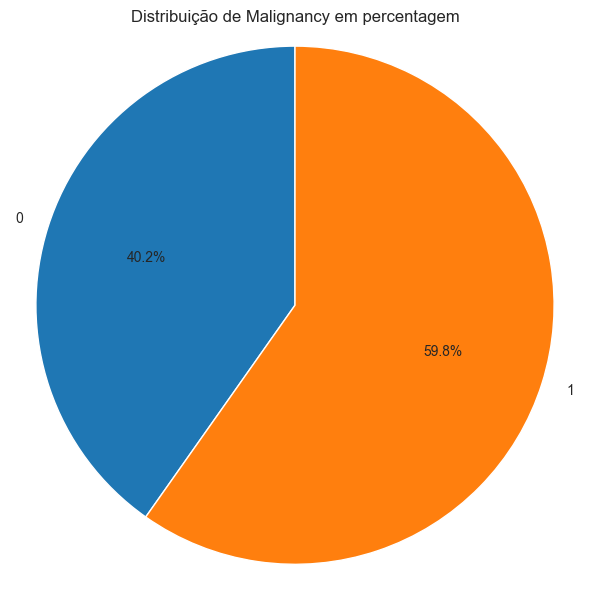

In [268]:
counts = pylidc_df['Malignancy'].value_counts(dropna=True).sort_index()
perc = pylidc_df['Malignancy'].value_counts(normalize=True, dropna=True).sort_index() * 100

print("Contagens por classe:")
print(counts)

labels = [str(idx) for idx in counts.index]

# plotar pizza — as percentagens aparecem dentro das fatias (autopct)
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(edgecolor='w'))
ax.set_title('Distribuição de Malignancy em percentagem')
ax.axis('equal')  # círculo perfeito
plt.tight_layout()
plt.show()

Temos uma distribuição de aproximadamente 60/40, o que é **apenas ligeiramente desequilibrado**, não sendo necessário aplicar técnicas de balanceamento!

In [269]:
# Guardar o novo dataset
pylidc_df.to_csv("data_final.csv", encoding='utf-8', index=True)

## **5º Passo** - Pré-Processamento de Imagens

Uma vez que já escolhemos os **875 pacientes e os nódulos correspondentes**, vamos prosseguir para o **pré-processamento de imagens** que é **uma das etapas mais importantes em qualquer projeto de análise radiológica**.

Sem um pré-processamento adequado podemos **perder precisão e ter inconsistência** nas etapas seguintes!

Vamos definir as funções que vamos utilizar e explicar o porquê das mesmas serem cruciais!

***Hounsfield Units (HU)***

**Hounsfield Units (HU) são a unidade de medida usada em tomografias computadorizadas (CT) para quantificar a densidade dos tecidos**. Cada voxel da imagem CT recebe um valor HU que representa a atenuação do raio-X naquele ponto. Em termos simples, **quanto mais denso for o tecido, maior será o valor HU; quanto mais “vazio” ou gasoso for, mais negativo será**.

Estas **unidades de medida são essenciais** para:
- **Extração de características (radiomics)**: muitas métricas, como a média, desvio ou textura dos nódulos, dependem dos valores de intensidade. Garantir que os HU são consistentes permite que essas métricas reflitam as diferenças reais nos tecidos;

- **Segmentação precisa**: thresholds baseados em HU permitem separar pulmão, vasos e nódulos de forma confiável. Sem essa padronização, a segmentação automática poderia incluir regiões irrelevantes ou perder partes importantes do nódulo.

In [270]:
def convert_to_hu(image):
    # Aceder a Rescale Intercept e Rescale Slope
    intercept = -1024
    slope = 1
    
    # Aplicar a fórmula de conversão
    hu_image = image * slope + intercept
    hu_image = np.clip(hu_image, -1000, 400)  # Limitar a faixa de HU
    return hu_image

***Normalização***

A normalização é **essencial para o pré-processamento de imagens pois mesmo após a conversão para Hounsfield Units (HU), as intensidades podem variar entre exames devido a diferenças no scanner ou no protocolo de aquisição**.
Logo a normalização é especialmente útil para:
- **Padronizar a escala de intensidades**, ajustando os valores HU para uma faixa comum como [0,1].

- **Garantir consistência entre amostras**, evitando que variações técnicas influenciem as análises radiómicas.

- **Melhorar o desempenho de algoritmos de machine learning** que convergem mais facilmente quando os dados têm distribuições semelhantes.

In [271]:
def norm(hu_image):
    # Normalização dos valores HU para o intervalo [0, 1]
    normalized_image = (hu_image - np.min(hu_image)) / (np.max(hu_image) - np.min(hu_image))
    return normalized_image

***Segmentação 2D***

Aqui vamos definir a função que vamos utilizar para a segmentação de imagens, esta é também uma **etapa essencial pois permite isolar as áreas de interesse na fatia correspondente ao centro do nódulo usando as coordenadas do seu centroide**.

As **máscaras são cruciais para garantir que as medições e extrações de características sejam feitas apenas na região relevante do nódulo**, evitando influência de tecidos vizinhos e retirando assim informação irrelevante.

In [272]:
# Esta função devolve a imagem e a máscara a serem usadas num determinado nó.
def segmentation_2d(scan, annotation):
    
    volume = scan.to_volume()

    # Obter o centro do nódulo (i, j, k) - k é a slice correspondente ao centro
    i, j, k = annotation.centroid
    slice_idx = int(k)  # Convertendo k para índice da slice

    # Gerar a máscara binária para a slice correspondente
    mascara_binaria = np.zeros(volume[:, :, slice_idx].shape, dtype=np.uint8)

    for contour in annotation.contours:
        if contour.image_k_position == slice_idx:
            # Obter as coordenadas do contorno e convertê-las em 2D
            ii, jj = contour.to_matrix(include_k=False).T
            mascara_binaria[ii.astype(int), jj.astype(int)] = 1

    # Aplicar a máscara na imagem original da slice
    imagem_slice = volume[:, :, slice_idx]
    
    return imagem_slice, mascara_binaria

***Segmentação 3D***

Esta função tem o **mesmo objetivo que a função anterior porém num contexto 3D**, onde isola o nódulo com uma representação espacial completa, ele faz isto considerando todas as fatias e usando máscaras.

In [273]:
# Esta função devolve o volume 3d e a máscara 3d do nódulo.
def segmentation_3d(scan, annotation):
    
    # Obter o volume completo do scan em HU
    volume = scan.to_volume()

    # Obter os limites de cada fatia do contorno
    mascara_binaria_3d = np.zeros(volume.shape, dtype=np.uint8)  # Máscara 3D para o volume completo

    # Iterar sobre os contornos e preencher a máscara 3D
    for contour in annotation.contours:
        slice_idx = np.argmin(np.abs(scan.slice_zvals - contour.image_z_position))  # Encontra o índice da slice

        # Obter as coordenadas do contorno e convertê-las em 2D
        ii, jj = contour.to_matrix(include_k=False).T  # Coordenadas do contorno em 2D
        mascara_binaria_3d[ii.astype(int), jj.astype(int), slice_idx] = 1  # Preencher a máscara 3D na slice correta

    # O volume HU já está pronto para ser retornado
    return volume, mascara_binaria_3d

## **6º Passo** - Isolamento dos nódulos usando máscaras

Uma vez definidas todas as funções, podemos prosseguir.

Vamos testar se as **segmentações 2D e 3D estão a funcionar corretamente** e, caso o resultado seja satisfatório, **aplicaremos o processo a todos os pacientes**!

Vamos começar pela segmentação 2D!

Loading dicom files ... This may take a moment.


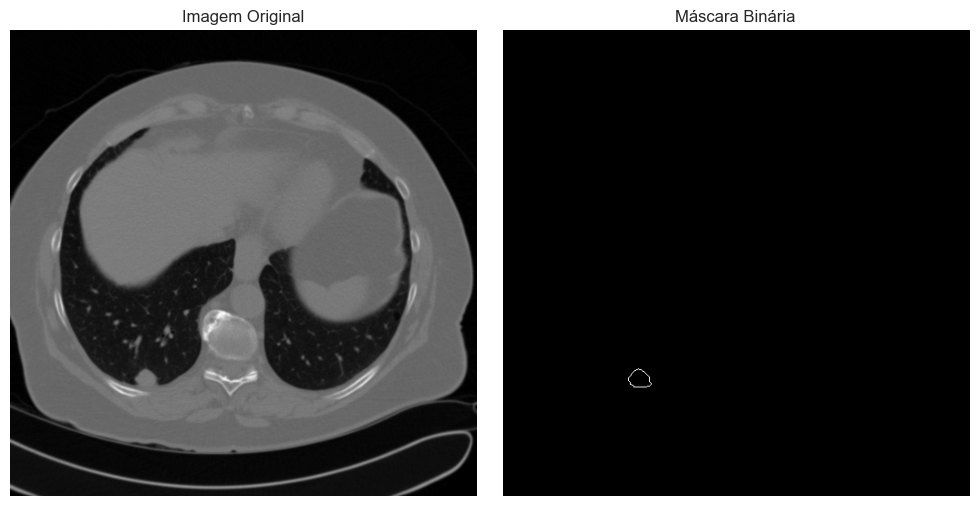

In [274]:
scan = pl.query(pl.Scan).filter(
    pl.Scan.patient_id == 'LIDC-IDRI-0484'
).first()


annotation = scan.annotations[0]
# Chamar a função para processar cada nódulo
imagem, mascara = segmentation_2d(scan, annotation)

# Criar um subplot para exibir as duas imagens lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar a imagem original no primeiro eixo
axes[0].imshow(imagem, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')  # Esconder os eixos

# Mostrar a máscara binária no segundo eixo
axes[1].imshow(mascara, cmap='gray')
axes[1].set_title('Máscara Binária')
axes[1].axis('off')  # Esconder os eixos

# Mostrar a figura com as duas imagens
plt.tight_layout()
plt.show()

Confirmamos então que **o código consegue isolar o nódulo usando uma máscara**!

Vamos continuar para a segmentação 3D!

Loading dicom files ... This may take a moment.


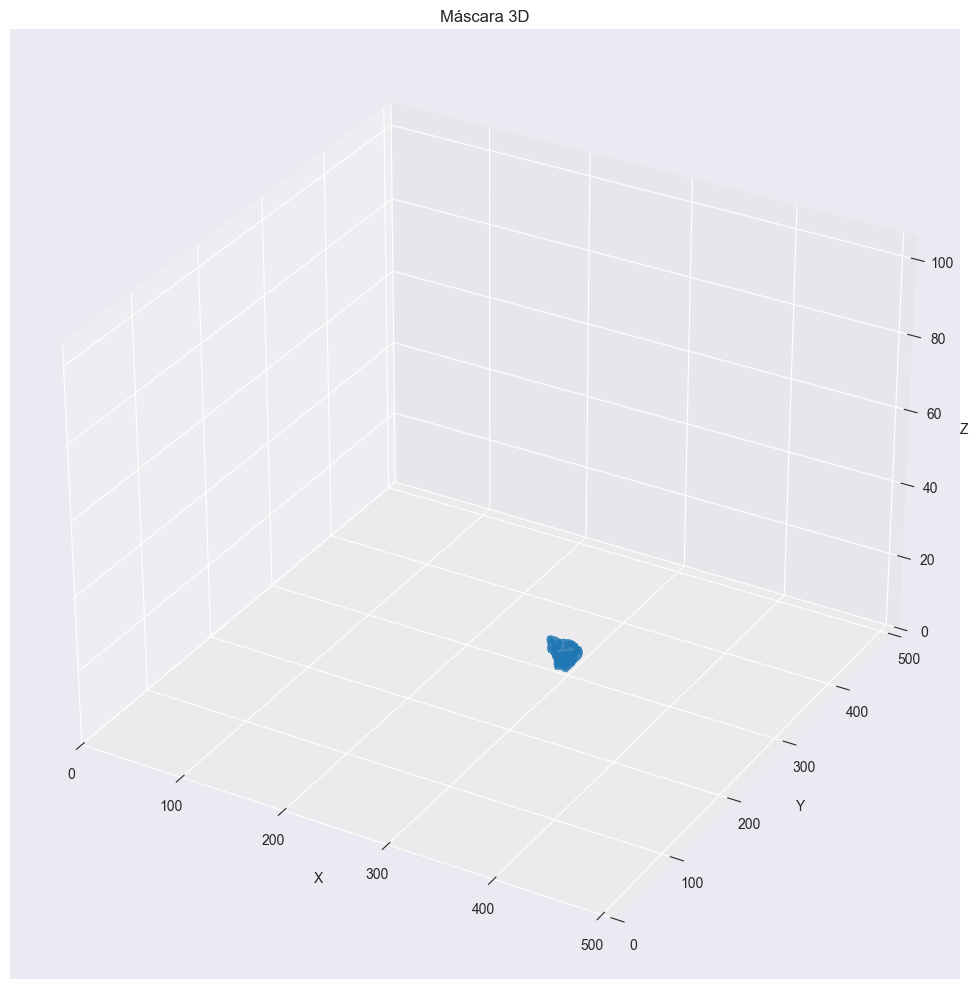

In [275]:
scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0484').all()[0]
annotations = scan.annotations
_, mascara_3d = segmentation_3d(scan, annotation)


# Encontrar a superfície da máscara binária usando marching cubes
verts, faces, _, _ = measure.marching_cubes(mascara_3d, level=0)

# Criar a figura e o eixo 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Renderizar a superfície 3D da máscara
mesh = Poly3DCollection(verts[faces], alpha=0.7)
ax.add_collection3d(mesh)

# Definir os limites do gráfico
ax.set_xlim(0, mascara_3d.shape[0])
ax.set_ylim(0, mascara_3d.shape[1])
ax.set_zlim(0, mascara_3d.shape[2])

# Ajustar a visualização
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Máscara 3D")

plt.tight_layout()
plt.show()

Vimos que **tudo está a correr como esperado**! Vamos passar para o próximo passo.

## **7º Passo** - Extração, Processamento e Seleção de Atributos 2D com PyRadiomics

Vamos iniciar a **extração das features radiômicas 2D**!

Vamos usar o nosso **ficheiro csv com os dados obtidos das anotações usando o Pylidc** para este passo.

In [276]:
df= pd.read_csv("Dados_Pylidc.csv")
df['NoduleID'] = df['NoduleID'].astype(int)

Vamos **criar um dicionário que associa o ID de cada paciente aos respetivos ID's dos nódulos**, permitindo aceder facilmente aos nódulos correspondentes a cada paciente.

In [277]:
patient_dict = df.groupby('PatientID')['NoduleID'].apply(lambda x: list(set(x))).to_dict()

Inicialmente vamos **extrair todas as features** e só **após a extração das mesmas** é que vamos avançar para uma **seleção das melhores features**.

In [ ]:
extractor_2d = featureextractor.RadiomicsFeatureExtractor()
extractor_2d.enableAllFeatures()
feature_list = []

def processar_pacientes(patient_dict, extractor):
    feature_list = []
    
    for patient_id in patient_dict:
        print(patient_id)
        # Obter os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans):            
            # Obter todas as anotações (nódulos) para esse scan
            annotations = scan.annotations

            # Iterar dentro dos nódulos
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]:                    
                    # Chamar a função para processar cada nódulo
                    imagem, mascara = segmentation_2d(scan, annotation)
                    
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem)
                    
                    # Converter a imagem e a máscara para SimpleITK
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas
                    features = extractor.execute(imagem_sitk, mascara_sitk)
                    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário de features
                    feature_dict['Patient_ID'] = patient_id
                    feature_dict['Nodule_ID'] = nodule_idx + 1
                    
                    # Adicionar o dicionário à lista de features
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # Salvar o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features.csv', index=False, encoding='utf-8')
    
    return df_features

# Chamar a função principal para processar os pacientes e salvar o resultado no CSV
result_features = processar_pacientes(patient_dict, extractor_2d)

Uma vez **concluído o processo vamos fazer o processamento dos dados**!

In [279]:
radiomics_df = pd.read_csv("radiomics_features.csv")

In [280]:
radiomics_df.head()

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                      2.2.6   
1                           v3.0.1                      2.2.6   
2                           v3.0.1                      2.2.6   
3                           v3.0.1                      2.2.6   
4                           v3.0.1                      2.2.6   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.5.2                          1.8.0   
1                          2.5.2                          1.8.0   
2                          2.5.2                          1.8.0   
3                          2.5.2                          1.8.0   
4                          2.5.2                          1.8.0   

  diagnostics_Versions_Python  \
0                     3.10.11   
1                     3.10.11   
2                     3.10.11   
3                     3.10.11   
4                     3.10.11   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  6a4838357bc6f2d070314113e53ad10a6773983d   
1  449ab6385a4d56b24b85267a6582dcb52f817a58   
2  edfba81cb31657af3253f1a41ac507b37463ba44   
3  e690ec733adecd1b08ae397a5d1b54da427c1eb2   
4  155ae61b240d8d9aa62de12ed6eebdb53313af53   

  diagnostics_Image-original_Dimensionality  \
0                                        2D   
1                                        2D   
2                                        2D   
3                                        2D   
4                                        2D   

  diagnostics_Image-original_Spacing  ... original_glszm_ZoneEntropy  \
0                         (1.0, 1.0)  ...               1.584963e+00   
1                         (1.0, 1.0)  ...              -3.203427e-16   
2                         (1.0, 1.0)  ...               1.000000e+00   
3                         (1.0, 1.0)  ...              -3.203427e-16   
4                         (1.0, 1.0)  ...              -3.203427e-16   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.018293                  5760.222222   
1                       0.010526                     0.000000   
2                       0.025316                  1482.250000   
3                       0.030303                     0.000000   
4                       0.022727                     0.000000   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0                 0.510938                  0.501529   
1                 0.000000            1000000.000000   
2                 0.519737                  1.000000   
3                 0.000000            1000000.000000   
4                 0.000000            1000000.000000   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  \
0                  0.091389                0.000306                1.992683   
1                  0.000000                0.000000                0.000000   
2                  0.025316                0.000316                1.000000   
3                  0.000000                0.000000                0.000000   
4                  0.000000                0.000000                0.000000   

       Patient_ID  Nodule_ID  
0  LIDC-IDRI-0001          1  
1  LIDC-IDRI-0002          1  
2  LIDC-IDRI-0003          1  
3  LIDC-IDRI-0003          2  
4  LIDC-IDRI-0003   

Vemos então que **conseguimos extrair 124 features** usando o Pyradiomics, porém **muitas colunas parecem ser irrelevantes**!

Vamos **renomear as colunas do Patient_ID e do Nodule_ID** para ficarem em concordância com o nosso dataset dos dados obtidos das anotações usando o Pylidc!

In [281]:
radiomics_df.rename(columns={
    'Patient_ID': 'PatientID',
    'Nodule_ID': 'NoduleID'
}, inplace=True)

Uma vez renomeadas vamos verificar **sobre quantos nódulos conseguimos extrair informação**.

In [282]:
print(radiomics_df.shape)

(2648, 126)


Verificamos que temos **2648 entradas quando esperávamos apenas 2625**, isto deve-se aos **casos duplicados** que temos visto anteriormente! Quando fizermos a junção de datasets vamos proceder à eliminação dos casos duplicados.

Vamos avançar para a procura de **valores nulos** no nosso dataset.

In [283]:
radiomics_df.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
original_ngtdm_Complexity           0
original_ngtdm_Contrast             0
original_ngtdm_Strength             0
PatientID                           0
NoduleID                            0
Length: 126, dtype: int64

Uma vez que **não temos valores nulos**, vamos proceder para a **eliminação de colunas com valores únicos e com informações irrelevantes**, como as versões das bibliotecas!

Vamos começar pelas colunas com valores único, estas colunas podem ser eliminadas uma vez que **não nos fornecem nenhuma informação nova**.

In [284]:
colunas_contagem = radiomics_df.nunique()
colunas_valor_unico = colunas_contagem[colunas_contagem == 1].index
print(colunas_valor_unico)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size'],
      dtype='object')


Vamos eliminá-los do nosso dataset!

In [285]:
radiomics_df.drop(columns = colunas_valor_unico, inplace = True)
print(radiomics_df.shape)

(2648, 113)


**Retiramos 13 colunas do nosso dataset**, porém podemos também **remover colunas que servem de identificação das máscaras e das imagens**, pois são irrelevantes para o nosso estudo. 

In [286]:
colunas_irrelevantes = [
    'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Mean',
    'diagnostics_Mask-original_Hash',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass',
]

Uma vez encontradas estas features podemos eliminá-las também.

In [287]:
radiomics_df = radiomics_df.drop(columns=colunas_irrelevantes)
print(radiomics_df.shape)

(2648, 105)


Após eliminarmos estas colunas vamos **verificar se existem colunas que não têm dados do tipo 'int' ou 'float'**.

In [288]:
# Filtramos as colunas que não têm dados do tipo int ou float
colunas_nao_numericas = radiomics_df.select_dtypes(exclude=['int', 'float',]).columns
print(colunas_nao_numericas)

Index(['PatientID'], dtype='object')


Só temos o coluna **'PatientID'** que vamos manter pois vai servir de **identificador** para a junção de datasets!

Ficamos então com apenas **103 features relevantes, das 124 originais**!

Uma vez este processo concluído podemos **criar a junção do dataset com o dataset que contêm os dados obtidos através das anotações**, vamos fazer a junção usando **dois identificadores: 'PatientID' e 'NoduleID'** e como método vamos utilizar o **'inner'** que mantêm apenas as entradas cujos identificadores existem em **ambos os dataframes simultaneamente**, ou seja, a sua **interseção**.

In [289]:
radiomics_final_all_2d = pd.merge(pylidc_df, radiomics_df, on = ['PatientID', 'NoduleID'], how = 'inner')

Vamos verificar se funcionou!

In [290]:
radiomics_final_all_2d.head()

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
0  LIDC-IDRI-0001         1                    4             False   
1  LIDC-IDRI-0002         1                    2             False   
2  LIDC-IDRI-0003         1                    1             False   
3  LIDC-IDRI-0003         2                    4             False   
4  LIDC-IDRI-0003         3                    4             False   

   InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  Margin  \
0                  1           3              6         5           3       4   
1                  1           5              6         2           1       1   
2                  1           5              6         1           1       2   
3                  1           4              6         5           2       3   
4                  1           3              6         4           1       4   

   ...  original_glszm_SmallAreaHighGrayLevelEmphasis  \
0  ...                                       4.333346   
1  ...                                       0.000111   
2  ...                                       2.000082   
3  ...                                       0.000918   
4  ...                                       0.000517   

   original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
0                                      0.120383                1.584963e+00   
1                                      0.000111               -3.203427e-16   
2                                      0.125082                1.000000e+00   
3                                      0.000918               -3.203427e-16   
4                                      0.000517               -3.203427e-16   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.018293                  5760.222222   
1                       0.010526                     0.000000   
2                       0.025316                  1482.250000   
3                       0.030303                     0.000000   
4                       0.022727                     0.000000   

   original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0                 0.510938                   0.501529   
1                 0.000000             1000000.000000   
2                 0.519737                   1.000000   
3                 0.000000             1000000.000000   
4                 0.000000             1000000.000000   

   original_ngtdm_Complexity  original_ngtdm_Contrast  original_ngtdm_Strength  
0                   0.091389                 0.000306                 1.992683  
1                   0.000000                 0.000000                 0.000000  
2                   0.025316                 0.000316                 1.000000  
3                   0.000000                 0.000000                 0.000000  
4                   0.000000                 0.000000                 0.000000  

[5 rows x 116 columns]

In [291]:
print(radiomics_final_all_2d.shape)

(2648, 116)


Confirmamos que temos as **116 features esperadas**, que são as 103 do nosso dataset mais as 11 features do dataset pylidc_df, mais os 2 identificadores.

Vemos que os **casos duplicados** se mantiveram após a junção dos datasets, vamos entende-los e proceder à sua **eliminação**, se assim for possível!

In [292]:
duplicados = radiomics_final_all_2d[radiomics_final_all_2d.duplicated(subset=['PatientID', 'NoduleID'], keep=False)]
duplicados

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
386   LIDC-IDRI-0132         1                    3             False   
387   LIDC-IDRI-0132         1                    3             False   
388   LIDC-IDRI-0132         2                    2             False   
389   LIDC-IDRI-0132         2                    2             False   
390   LIDC-IDRI-0132         3                    1             False   
391   LIDC-IDRI-0132         3                    1             False   
392   LIDC-IDRI-0132         4                    4             False   
393   LIDC-IDRI-0132         4                    4             False   
394   LIDC-IDRI-0132         5                    1             False   
395   LIDC-IDRI-0132         5                    1             False   
396   LIDC-IDRI-0132         6                    1             False   
397   LIDC-IDRI-0132         6                    1             False   
465   LIDC-IDRI-0151         1                    3             False   
466   LIDC-IDRI-0151         1                    3             False   
815   LIDC-IDRI-0315         1                    1             False   
816   LIDC-IDRI-0315         1                    1             False   
817   LIDC-IDRI-0315         2                    1             False   
818   LIDC-IDRI-0315         2                    1             False   
819   LIDC-IDRI-0315         3                    1             False   
820   LIDC-IDRI-0315         3                    1             False   
821   LIDC-IDRI-0315         4                    4             False   
822   LIDC-IDRI-0315         4                    4             False   
823   LIDC-IDRI-0315         5                    4             False   
824   LIDC-IDRI-0315         5                    4             False   
825   LIDC-IDRI-0315         6                    4             False   
826   LIDC-IDRI-0315         6                    4             False   
827   LIDC-IDRI-0315         7                    3             False   
828   LIDC-IDRI-0315         7                    3             False   
851   LIDC-IDRI-0332         1                    4             False   
852   LIDC-IDRI-0332         1                    4             False   
853   LIDC-IDRI-0332         2                    4             False   
854   LIDC-IDRI-0332         2                    4             False   
911   LIDC-IDRI-0355         1                    1             False   
912   LIDC-IDRI-0355         1                    1             False   
939   LIDC-IDRI-0365         1                    4             False   
940   LIDC-IDRI-0365         1                    4             False   
1152  LIDC-IDRI-0442         1                    3             False   
1153  LIDC-IDRI-0442         1                    3             False   
1154  LIDC-IDRI-0442         2                    3             False   
1155  LIDC-IDRI-0442         2                    3             False   
1156  LIDC-IDRI-0442         3                    4             False   
1157  LIDC-IDRI-0442         3                    4             False   
1280  LIDC-IDRI-0484         1                    4             False   
1281  LIDC-IDRI-0484         1                    4             False   
1282  LIDC-IDRI-0484         2                    1             False   
1283  LIDC-IDRI-0484         2                    1             False   

      InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
386                   1           4              6         3           1   
387                   1           4              6         3           1   
388                   1           3              6         4           1   
389                   1           3              6         4           1   
390                   1           3              6         4           4   
391                   1           3              6         4           4   
392                   1           4            

Podemos observar que, **para os pacientes que possuem dois scans**, cada **nódulo aparece duplicado**. Isto ocorre porque os nódulos **mantêm o mesmo ID de paciente e de nódulo**, apesar de pertencerem a scans diferentes. No entanto, iremos manter apenas as **primeiras ocorrências de cada duplicado**, correspondentes aos nódulos do primeiro scan de cada paciente.

Vamos observar o **caso do paciente 'LIDC-IDRI-0132'** para corroborar a informação anterior.

In [293]:
radiomics_final_all_2d[radiomics_final_all_2d['PatientID'] == 'LIDC-IDRI-0132']

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
386  LIDC-IDRI-0132         1                    3             False   
387  LIDC-IDRI-0132         1                    3             False   
388  LIDC-IDRI-0132         2                    2             False   
389  LIDC-IDRI-0132         2                    2             False   
390  LIDC-IDRI-0132         3                    1             False   
391  LIDC-IDRI-0132         3                    1             False   
392  LIDC-IDRI-0132         4                    4             False   
393  LIDC-IDRI-0132         4                    4             False   
394  LIDC-IDRI-0132         5                    1             False   
395  LIDC-IDRI-0132         5                    1             False   
396  LIDC-IDRI-0132         6                    1             False   
397  LIDC-IDRI-0132         6                    1             False   

     InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
386                  1           4              6         3           1   
387                  1           4              6         3           1   
388                  1           3              6         4           1   
389                  1           3              6         4           1   
390                  1           3              6         4           4   
391                  1           3              6         4           4   
392                  1           4              6         5           2   
393                  1           4              6         5           2   
394                  1           3              6         4           3   
395                  1           3              6         4           3   
396                  1           2              6         4           3   
397                  1           2              6         4           3   

     Margin  ...  original_glszm_SmallAreaHighGrayLevelEmphasis  \
386       3  ...                                       0.000049   
387       3  ...                                       0.000083   
388       5  ...                                       0.000072   
389       5  ...                                       0.000453   
390       2  ...                                       0.001890   
391       2  ...                                       0.001600   
392       5  ...                                       0.001479   
393       5  ...                                       0.001078   
394       1  ...                                       0.000657   
395       1  ...                                       0.001276   
396       3  ...                                       0.000595   
397       3  ...                                       0.000865   

     original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
386                                      0.000049               -3.203427e-16   
387                                      0.000083               -3.203427e-16   
388                                      0.000072               -3.203427e-16   
389                                      0.000453               -3.203427e-16   
390                                      0.001890               -3.203427e-16   
391                                      0.001600               -3.203427e-16   
392                                      0.001479               -3.203427e-16   
393                                      0.001078                1.000000e+00   
394                                      0.000657               -3.203427e-16   
395                                      0.001276               -3.203427e-16   
396                                      0.000595               -3.203427e-16   
397                                      0.000865               -3.203427e-16   

     original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
386                       0.006993                         0.00   
387                       0.009091   

De facto temos **6 nódulos duplicados** que é o **número de nódulos com tamanho maior a 3mm do primeiro scan do paciente 'LIDC-IDRI-0132', no dataset 'Nodule Counts by Patient'**! Vamos portanto eliminá-los.

In [294]:
radiomics_final_all_2d.drop_duplicates(subset=['PatientID', 'NoduleID'], keep='first', inplace=True)

In [295]:
print(radiomics_final_all_2d.shape)

(2625, 116)


Agora temos os **2625 nódulos** que encontramos com os dados das anotações!

Agora que os dados se encontram coerentes, vamos **eliminar as entradas que possuem mais de quatro anotações**!

Como o dataset original conta apenas com quatro radiologistas, **qualquer nódulo com mais do que quatro anotações indica a presença de informação duplicada, redundante ou potencialmente incorreta**. Devido a esses factos, decidimos que essas entradas serão removidas para garantir a **consistência e a credibilidade da nossa análise**.

In [296]:
print(radiomics_final_all_2d['MaisDe4Anotacoes'].value_counts())

MaisDe4Anotacoes
False    2612
True       13
Name: count, dtype: int64


Temos portanto **13 entradas** que vamos eliminar da nossa análise!

In [297]:
radiomics_final_all_2d = radiomics_final_all_2d[radiomics_final_all_2d['MaisDe4Anotacoes'] == False]

Uma vez que a limpeza está concluída, podemos também **eliminar as colunas 'QuantidadeAnotacoes' e 'MaisDe4Anotacoes'** pois já **não possuem informação relevante** para a análise futura.

Vamos também reiniciar o index para não haver erros.

In [298]:
radiomics_final_all_2d.drop(columns=['QuantidadeAnotacoes'], inplace=True)
radiomics_final_all_2d.drop(columns=['MaisDe4Anotacoes'], inplace=True)

radiomics_final_all_2d.reset_index(drop=True, inplace=True)

In [299]:
radiomics_final_all_2d

PatientID  NoduleID  InternalStructure  Sphericity  Calcification  \
0     LIDC-IDRI-0001         1                  1           3              6   
1     LIDC-IDRI-0002         1                  1           5              6   
2     LIDC-IDRI-0003         1                  1           5              6   
3     LIDC-IDRI-0003         2                  1           4              6   
4     LIDC-IDRI-0003         3                  1           3              6   
...              ...       ...                ...         ...            ...   
2607  LIDC-IDRI-1011         1                  4           5              6   
2608  LIDC-IDRI-1011         2                  1           3              6   
2609  LIDC-IDRI-1011         3                  1           4              6   
2610  LIDC-IDRI-1011         4                  1           4              6   
2611  LIDC-IDRI-1012         1                  1           4              6   

      Subtlety  Lobulation  Margin  Spiculation  Texture  ...  \
0            5           3       4            5        5  ...   
1            2           1       1            1        1  ...   
2            1           1       2            1        1  ...   
3            5           2       3            2        4  ...   
4            4           1       4            1        5  ...   
...        ...         ...     ...          ...      ...  ...   
2607         5           1       4            5        4  ...   
2608         5           3       4            1        5  ...   
2609         5           1       3            1        5  ...   
2610         1           1       2            1        1  ...   
2611         4           1       2            1        5  ...   

      original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          4.333346   
1                                          0.000111   
2                                          2.000082   
3                                          0.000918   
4                                          0.000517   
...                                             ...   
2607                                       9.500713   
2608                                       0.000098   
2609                                       0.000160   
2610                                       2.250080   
2611                                       0.002268   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.120383   
1                                         0.000111   
2                                         0.125082   
3                                         0.000918   
4                                         0.000517   
...                                            ...   
2607                                      0.067842   
2608                                      0.000098   
2609                                      0.000160   
2610                                      0.375080   
2611                                      0.002268   

      original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
0                   1.584963e+00                       0.018293   
1                  -3.203427e-16                       0.010526   
2                   1.000000e+00                       0.025316   
3                  -3.203427e-16                       0.030303   
4                  -3.203427e-16                       0.022727   
...                          ...                            ...   
2607                2.584963e+00                       0.115385   
2608               -3.203427e-16                       0.009901   
2609               -3.203427e-16                       0.012658   
2610                1.500000e+00                       0.067797   
2611               -3.203427e-16                       0.047619   

      original_glszm_ZoneVariance  original_ngtdm_Busyness  \
0                     5760.222222                 0.510938   
1                        0.000

Temos então **2612 nódulos** para investigação, **112 features** que contêm informação relevante, e **2 identificadores**!

Vamos avançar para a **seleção das features** que têm mais **importância para o valor da Malignancy**.

### Seleção e Importância das Features – 2D

Vamos aplicar **seis métodos de seleção de features, de forma independente** — **LASSO (L1)**, **t-test**, **Análise de Componentes Principais (PCA)**, **seleção por correlação** e **Random Forest**, obtendo, para cada método, um **conjunto das melhores features**.

Cada conjunto será usado para treinar e avaliar os **mesmos modelos preditivos**, o que permite **comparar diretamente o impacto das diferentes estratégias de seleção** no desempenho:

- **LASSO (Regularização L1)**: O LASSO aplica **penalização L1 aos coeficientes do modelo**, promovendo a **redução a zero das variáveis menos relevantes** e originando modelos mais esparsos e interpretáveis. Quando se usa uma **implementação baseada em LogisticRegression com penalização L1**, C controla a **intensidade da regularização de forma inversa**, ou seja, **valores mais baixos reforçam a penalização e conduzem a menos features selecionadas**; **valores mais altos relaxam a penalização**. Testaremos **diferentes valores de C** para encontrar o compromisso entre simplicidade e desempenho.

- **Testes de hipótese (t-test)**: Para **cada feature realizamos um t-test** para avaliar se as médias das duas classes diferem significativamente. **Manteremos as features cujo p-valor seja inferior a 0,005**.

- **Análise de Componentes Principais (PCA)**: A PCA **reduz a dimensionalidade** ao transformar as **features originais em componentes lineares não correlacionadas** que explicam a maior parte da variância. Ajustámos então um PCA completo para obter a **variância explicada acumulada**. Selecionámos o **menor número de componentes capaz de explicar pelo menos 95% da variância total** e refizemos a transformação com esse número de componentes

- **Correlação**: Calculamos a **correlação entre cada feature e Malignancy**. E vamos selecionar as features cuja correlação seja superior a um certo valor.

- **Random Forest**: O algoritmo Random Forest também é **usado para selecionar as features mais relevantes ao problema de classificação**. Para tal, **atribui determinada importância** a cada feature na fase de treino do modelo, que corresponde à **contribuição de cada feature para a classificação**.


Vamos iniciar por criar uma **cópia do DataFrame** original para evitar alterações acidentais, **preservando-o para a análise final**!

In [300]:
radiomics_final_selected_2d = radiomics_final_all_2d
data_all_2d = radiomics_final_selected_2d.drop(columns=['Malignancy', 'PatientID', 'NoduleID'])  # Features
y_all_2d = radiomics_final_selected_2d['Malignancy']
groups = radiomics_final_selected_2d["PatientID"]

Fazemos já a **divisão das features e do alvo 'Malignancy'**, para podermos usar futuramente, nos **modelos de classificação**.

#### **Lasso - L1 regularization**

Vamos testar **3 valores diferentes do parâmetro C** para a intensidade da regularização L1. Os **valores que decidimos utilizar são 0.05, 0.1 e 1.0**.

In [301]:
X_lasso = radiomics_final_selected_2d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_lasso = radiomics_final_selected_2d['Malignancy']  # Alvo

# Normalizamos os dados usando o StandardScaler
scaler = StandardScaler()
X_lasso_scaled = scaler.fit_transform(X_lasso)

# Dividimos em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_lasso_scaled, y_lasso, test_size=0.3, random_state=42)

# Valores de C para testar
C_values = [0.05, 0.1, 1.0]

# Listas para armazenar as features selecionadas
selected_features_L1_005 = []
selected_features_L1_01 = []
selected_features_L1_1 = []

# Testamos com cada valor de C
for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_train, y_train)

    coef = model.coef_

    # Se coef for uma matriz 2D (problema multiclasse), use apenas os coeficientes da primeira classe
    if coef.ndim > 1:
        coef = coef[0]

    # Selecionamos as features com coeficientes diferentes de zero
    selected_features = X_lasso.columns[(coef != 0).ravel()]

    if C == 0.05:
        selected_features_L1_005 = selected_features
    elif C == 0.1:
        selected_features_L1_01 = selected_features
    elif C == 1.0:
        selected_features_L1_1 = selected_features

# Por fim imprimimos as features selecionadas para cada valor de C
print("Selected features after L1 Regularization for C=0.05:", selected_features_L1_005)
print("Selected features after L1 Regularization for C=0.1:", selected_features_L1_01)
print("Selected features after L1 Regularization for C=1.0:", selected_features_L1_1)

Selected features after L1 Regularization for C=0.05: Index(['Calcification', 'Subtlety', 'Lobulation', 'Margin', 'Spiculation',
       'Texture', 'diagnostics_Image-original_Maximum',
       'original_shape2D_Elongation', 'original_shape2D_PerimeterSurfaceRatio',
       'original_shape2D_Sphericity', 'original_firstorder_10Percentile',
       'original_firstorder_Minimum',
       'original_glrlm_ShortRunLowGrayLevelEmphasis'],
      dtype='object')
Selected features after L1 Regularization for C=0.1: Index(['InternalStructure', 'Calcification', 'Subtlety', 'Lobulation',
       'Margin', 'Spiculation', 'Texture',
       'diagnostics_Image-original_Maximum', 'original_shape2D_Elongation',
       'original_shape2D_PerimeterSurfaceRatio', 'original_shape2D_Sphericity',
       'original_firstorder_10Percentile', 'original_firstorder_Kurtosis',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glrlm_RunVariance', 'original_glrlm_ShortRunEmphasis',
       '

Concluímos que **valores mais baixos como C=0,05** levaram a uma **seleção demasiado restritiva de features**, enquanto **valores altos como C=1.0**, mantiveram um **número excessivos de features**.

Assim, **optamos por um valor intermédio C=0,1** que escolheu um **menor número de features sem perda de informação importante**.

In [302]:
print ("Número de features selecionadas para 2D:", len(selected_features_L1_01))
print("Dataset com features significativas 2D:")
data_lasso_2d = radiomics_final_selected_2d[selected_features_L1_01]
features_lasso_2d = pd.concat([data_lasso_2d, y_lasso], axis=1)
features_lasso_2d

Número de features selecionadas para 2D: 19
Dataset com features significativas 2D:


InternalStructure  Calcification  Subtlety  Lobulation  Margin  \
0                     1              6         5           3       4   
1                     1              6         2           1       1   
2                     1              6         1           1       2   
3                     1              6         5           2       3   
4                     1              6         4           1       4   
...                 ...            ...       ...         ...     ...   
2607                  4              6         5           1       4   
2608                  1              6         5           3       4   
2609                  1              6         5           1       3   
2610                  1              6         1           1       2   
2611                  1              6         4           1       2   

      Spiculation  Texture  diagnostics_Image-original_Maximum  \
0               5        5                               400.0   
1               1        1                               400.0   
2               1        1                               400.0   
3               2        4                               400.0   
4               1        5                               400.0   
...           ...      ...                                 ...   
2607            5        4                               145.0   
2608            1        5                               241.0   
2609            1        5                               238.0   
2610            1        1                               145.0   
2611            1        5                               245.0   

      original_shape2D_Elongation  original_shape2D_PerimeterSurfaceRatio  \
0                        0.780478                                2.595471   
1                        0.875037                                2.884337   
2                        0.837449                                2.883393   
3                        0.784334                                2.896964   
4                        0.883528                                3.218951   
...                           ...                                     ...   
2607                     0.834938                                3.206197   
2608                     0.561402                                2.851203   
2609                     0.798296                                2.882234   
2610                     0.848707                                3.178396   
2611                     0.650249                                3.259801   

      original_shape2D_Sphericity  original_firstorder_10Percentile  \
0                        0.116476                           -1000.0   
1                        0.140517                           -1000.0   
2                        0.154282                           -1000.0   
3                        0.237705                           -1000.0   
4                        0.191705                           -1000.0   
...                           ...                               ...   
2607                     0.178190                           -1000.0   
2608                     0.138573                           -1000.0   
2609                     0.154955                           -1000.0   
2610                     0.167193                           -1000.0   
2611                     0.276215                           -1000.0   

      original_firstorder_Kurtosis  original_firstorder_Minimum  \
0                       113.421045                      -1000.0   
1                         0.000000                      -1000.0   
2                        77.012821                      -1000.0   
3                         0.000000                      -1000.0   
4                         0.000000                      -1000.0   
...                            ...                          ...   
2607                     20.701325                      -1000.0   
2608                      0.000000

Encontramos portanto, **19 features relevantes**!

#### **T-test**

Vamos continuar para o método T-test! Escolhemos como **limite o valor = 0.005**, e **manteremos todas as features cujo p-value seja inferior a esse limite**!

In [303]:
X_ttest = radiomics_final_selected_2d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_ttest_2d = radiomics_final_selected_2d['Malignancy']  # Alvo
benigno_ttest = X_ttest[y_ttest_2d == 0]
maligno_ttest = X_ttest[y_ttest_2d == 1]

t_test_results = {}
for feature in X_ttest.columns:
    t_stat, p_value = ttest_ind(benigno_ttest[feature], maligno_ttest[feature], equal_var=False)
    t_test_results[feature] = p_value
sorted_t_test_results = pd.Series(t_test_results).sort_values()
print("2D Features ranked by significance (p-value):")
print(sorted_t_test_results)

2D Features ranked by significance (p-value):
Calcification                                      1.369260e-71
Lobulation                                         1.554864e-31
Spiculation                                        1.054391e-27
Margin                                             6.177384e-21
original_shape2D_Sphericity                        6.718513e-16
                                                       ...     
original_glszm_SizeZoneNonUniformityNormalized     6.061250e-01
original_glcm_MCC                                  6.067186e-01
original_shape2D_Elongation                        8.348420e-01
original_firstorder_Median                         9.254301e-01
original_glrlm_RunLengthNonUniformityNormalized    9.343409e-01
Length: 111, dtype: float64


c:\Users\pedro\Desktop\Laboratorio de IA e CD\trabalho_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [304]:
features_ttest = sorted_t_test_results[sorted_t_test_results < 0.005].index.tolist()
print ("Número de features selecionadas para 2D:", len(features_ttest))
print("Dataset com features significativas 2D:")
data_ttest_2d = radiomics_final_selected_2d[features_ttest]
features_ttest_2d = pd.concat([data_ttest_2d, y_ttest_2d], axis=1)
features_ttest_2d

Número de features selecionadas para 2D: 46
Dataset com features significativas 2D:


Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape2D_Sphericity  original_gldm_DependenceNonUniformity  \
0                        0.116476                             110.097561   
1                        0.140517                              95.000000   
2                        0.154282                              69.430380   
3                        0.237705                              33.000000   
4                        0.191705                              44.000000   
...                           ...                                    ...   
2607                     0.178190                              24.346154   
2608                     0.138573                              66.584158   
2609                     0.154955                              61.531646   
2610                     0.167193                              46.118644   
2611                     0.276215                              17.380952   

      original_glrlm_GrayLevelNonUniformity  \
0                                113.551582   
1                                 71.250000   
2                                 57.533811   
3                                 24.750000   
4                                 33.000000   
...                                     ...   
2607                              30.577463   
2608                              73.000000   
2609                              58.000000   
2610                              41.178608   
2611                              15.500000   

      original_gldm_GrayLevelNonUniformity  Subtlety  \
0                               160.036585         5   
1                                95.000000         2   
2                                77.025316         1   
3                                33.000000         5   
4                                44.000000         4   
...                                    ...       ...   
2607                             42.692308         5   
2608                            101.000000         5   
2609                             79.000000         5   
2610                             55.135593         1   
2611                             21.000000         4   

      original_shape2D_MajorAxisLength  ...  \
0                            57.542760  ...   
1                            47.916558  ...   
2                            38.992455  ...   
3                            17.090541  ...   
4                            23.317369  ...   
...                                ...  ...   
2607                         26.398245  ...   
2608                         51.164214  ...   
2609                         41.452617  ...   
2610                         29.974686  ...   
2611                         12.494295  ...   

      original_glrlm_GrayLevelNonUniformityNormalized  original_glcm_Idmn  \
0                                            0.966060            0.996393   
1                                            1.000000            1.000000   
2                                            0.966764            0.995370   
3                                            1.000000            1.000000   
4                                            1.000000            1.000000   
...                                               ...                 ...   
2607                                         0.778570            0.988566   
2

Vemos portanto que usando o método T-test conseguimos **46 features relevantes**!

#### **Principal Component Analysis**

Para o método PCA vamos manter o **menor número de componentes que seja capaz de explicar pelo menos 95% da variância total**!

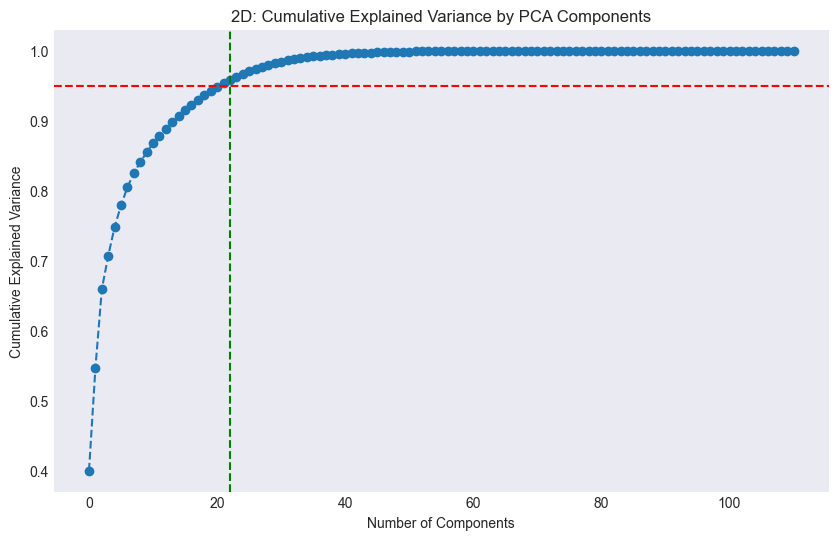

In [305]:
X_pca = radiomics_final_selected_2d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_pca_2d = radiomics_final_selected_2d['Malignancy']  # Alvo
scaler_2d = StandardScaler()
X_scaled_pca = scaler_2d.fit_transform(X_pca)
pca_2d = PCA()
X_pca_2d = pca_2d.fit_transform(X_scaled_pca)

explained_variance_2d = pca_2d.explained_variance_ratio_
cumulative_variance_2d = explained_variance_2d.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_2d, marker='o', linestyle='--')
plt.title('2D: Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold line
plt.axvline(x=np.argmax(cumulative_variance_2d >= 0.95) + 1, color='g', linestyle='--')  # Number of components for 95%
plt.show()

In [306]:
n_components_2d = np.argmax(cumulative_variance_2d >= 0.95) + 1 # quantidade de componentes que explica 95% da variância)
pca_final_2d = PCA(n_components = n_components_2d)
reduced_features_2d = pca_final_2d.fit_transform(X_scaled_pca)
print("Número de features selecionadas 2D: ", n_components_2d)
data_pca_2d = pd.DataFrame(data=reduced_features_2d, columns=[f'PC{i}' for i in range(n_components_2d)])
features_pca_2d = pd.concat([data_pca_2d, y_pca_2d.reset_index(drop=True)], axis=1)
features_pca_2d

Número de features selecionadas 2D:  22


PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     2.940010  18.430755  6.971970 -5.305699  2.359204  0.910508  8.332709   
1    -1.986601   7.594077  6.591035  1.996285 -1.000592  0.719544 -1.469020   
2     2.020623   8.222577  1.119425 -2.603072 -1.804638  2.141331  5.740737   
3    -1.983425  -0.821853  0.377891  0.729857 -0.151230 -1.585481  0.588032   
4    -1.951841   0.655908  1.338934  1.223112 -1.435798 -0.754853 -0.034606   
...        ...        ...       ...       ...       ...       ...       ...   
2607  7.250143   4.883816 -3.318700 -2.649773  1.169158 -0.393980  0.796710   
2608 -1.827461   7.835941  6.416450  0.372486  2.487625 -1.696200 -1.171867   
2609 -1.832153   4.994345  4.326983  0.619211  1.211798 -1.881902 -0.668762   
2610  4.413054   6.097318 -2.943503 -1.731531 -1.789203  0.983187  3.928351   
2611 -2.274648  -2.063480 -0.266352 -0.109914  0.192440  1.230530 -0.622005   

           PC7       PC8       PC9  ...      PC13      PC14      PC15  \
0     2.336693 -2.915547  0.017969  ...  1.981433 -5.861229  5.753884   
1    -2.647705  1.424797 -2.969977  ...  0.739599  1.027169 -0.545074   
2    -1.366194 -1.168388 -4.157199  ...  1.128979 -1.873654  2.122376   
3    -0.464691 -0.329500  0.748224  ...  0.414916  0.264112  0.357385   
4     0.208923 -0.082535 -0.266395  ...  0.251880  0.272272 -0.154137   
...        ...       ...       ...  ...       ...       ...       ...   
2607  0.139595 -4.568912  2.072729  ... -8.181715  8.048030  7.926626   
2608  0.578392  1.075440  0.815441  ... -0.711455  0.434569 -1.253925   
2609  0.885214  0.610669 -0.603051  ... -0.564258  0.267869 -0.729283   
2610 -2.399115 -0.647537 -4.097041  ... -1.990781 -1.120333  0.793302   
2611 -0.668275 -0.055742 -0.043713  ... -0.799118  0.096911 -0.454650   

          PC16      PC17      PC18      PC19      PC20      PC21  Malignancy  
0    -2.144556  1.532330 -1.172926  5.587918 -2.286055  1.929889           1  
1     0.036286  0.262718  0.634654 -0.139583  0.431204  0.283702           1  
2    -0.794198  0.584232  1.454060 -0.437333 -0.499048  0.014856           0  
3     0.327355  0.225480  0.253487 -0.078950  0.075219  0.897225           1  
4     0.396402 -0.259846 -1.228032 -0.490167  0.246650  0.409252           1  
...        ...       ...       ...       ...       ...       ...         ...  
2607  2.526727 -5.147892  0.756594  0.728031 -4.034499  0.548797           1  
2608  0.200226 -0.320893  0.193077 -0.249144  0.459411  0.146271           1  
2609  0.205014 -0.080115 -0.223995 -0.817165  0.380958  0.953935           1  
2610 -1.287269 -0.969464  0.947751 -0.520690  2.901461 -0.437681           0  
2611 -0.123594  0.232184  0.821024 -0.054793 -0.111634  0.866164           0  

[2612 rows x 23 columns]

Temos então **22 features que conseguem explicar pelo menos 95% da variância total**!

#### **Correlação**

Vamos observar qual a **correlação de cada feature** com o atributo alvo 'Malignancy'! Vamos escolher o **valor mínimo de 0.20 para realizarmos uma busca mais exploratória**.

Top 15 features:
Index(['Malignancy', 'Calcification', 'Lobulation'], dtype='object')


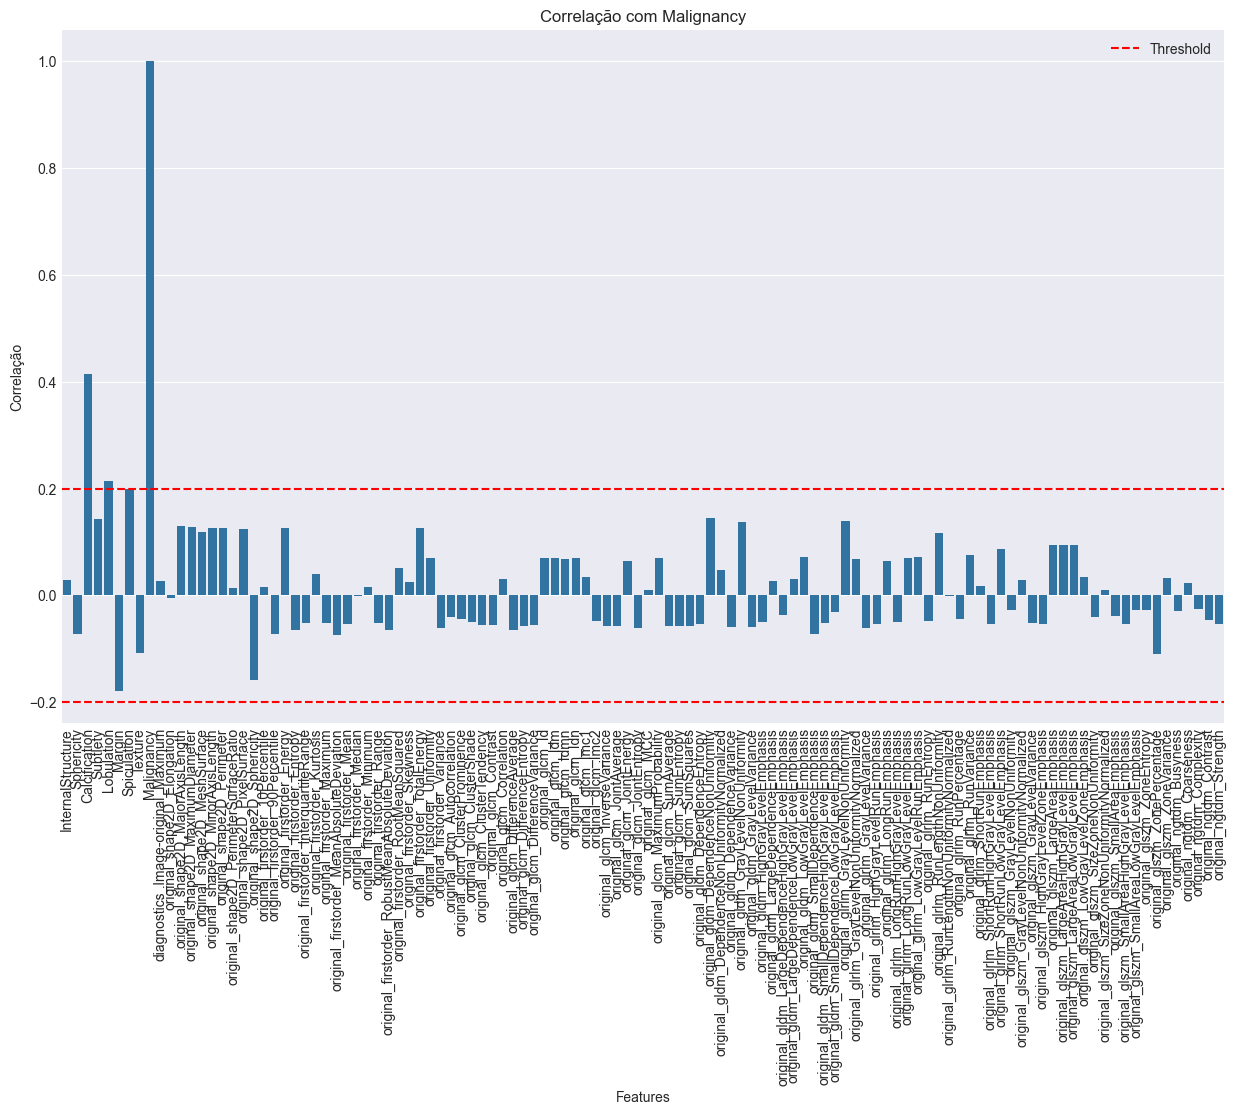

In [307]:
# Definimos o threshold para a correlação
correlation_threshold = 0.2

features_correlacao = radiomics_final_selected_2d.iloc[:, 2:]

# Calculamos a correlação de cada features em relação ao atributo 'Malignancy' 
correlation_with_malignancy = features_correlacao.corr()['Malignancy']

high_correlation_features = correlation_with_malignancy[correlation_with_malignancy.abs() >= correlation_threshold]

# Obtemos as 15 features com correlação mais alta
high_correlation_features = high_correlation_features.abs().nlargest(15).index

print("Top 15 features:")
print(high_correlation_features)

plt.figure(figsize=(15, 9))
sns.barplot(x=correlation_with_malignancy.index, y=correlation_with_malignancy)
plt.xticks(rotation=90)
plt.title('Correlação com Malignancy')
plt.xlabel('Features')
plt.ylabel('Correlação')
plt.axhline(y=correlation_threshold, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-correlation_threshold, color='r', linestyle='--')
plt.legend()
plt.show()

Verificámos que apenas **três features apresentam correlação absoluta superior a 0.2** com a variável alvo.

Esta **fraca associação** pode dever-se, ao **ruído introduzido** por termos tratado **1013 nódulos rotulados como 3 (indeterminados) como malignos**, ou seja, alguns desses casos poderão ser verdadeiramente benignos, o que tende a **atenuar as correlações**.

Portanto, a seleção por correlação **não será utilizada**, pois só retornou três features,o que **não é suficiente nem confiável para a etapa de modelagem**.

#### **Random Forest**

Procedemos para o Random Forest como **método de seleção de features**!

In [308]:
X_randomforest = radiomics_final_selected_2d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_randomforest_2d = radiomics_final_selected_2d['Malignancy']  # Alvo
rf_features_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_features_2d.fit(X_randomforest, y_randomforest_2d)

RandomForestClassifier(random_state=42)

Vamos ver quais as **features mais importantes e organizá-las sobre um gráfico**!

Feature Importances 2D:
                                   Feature  Importance
2                            Calcification    0.097933
3                                 Subtlety    0.031931
4                               Lobulation    0.030072
86              original_glrlm_RunVariance    0.028893
9              original_shape2D_Elongation    0.028755
..                                     ...         ...
22  original_firstorder_InterquartileRange    0.000435
0                        InternalStructure    0.000253
28             original_firstorder_Minimum    0.000000
27              original_firstorder_Median    0.000000
18        original_firstorder_10Percentile    0.000000

[111 rows x 2 columns]


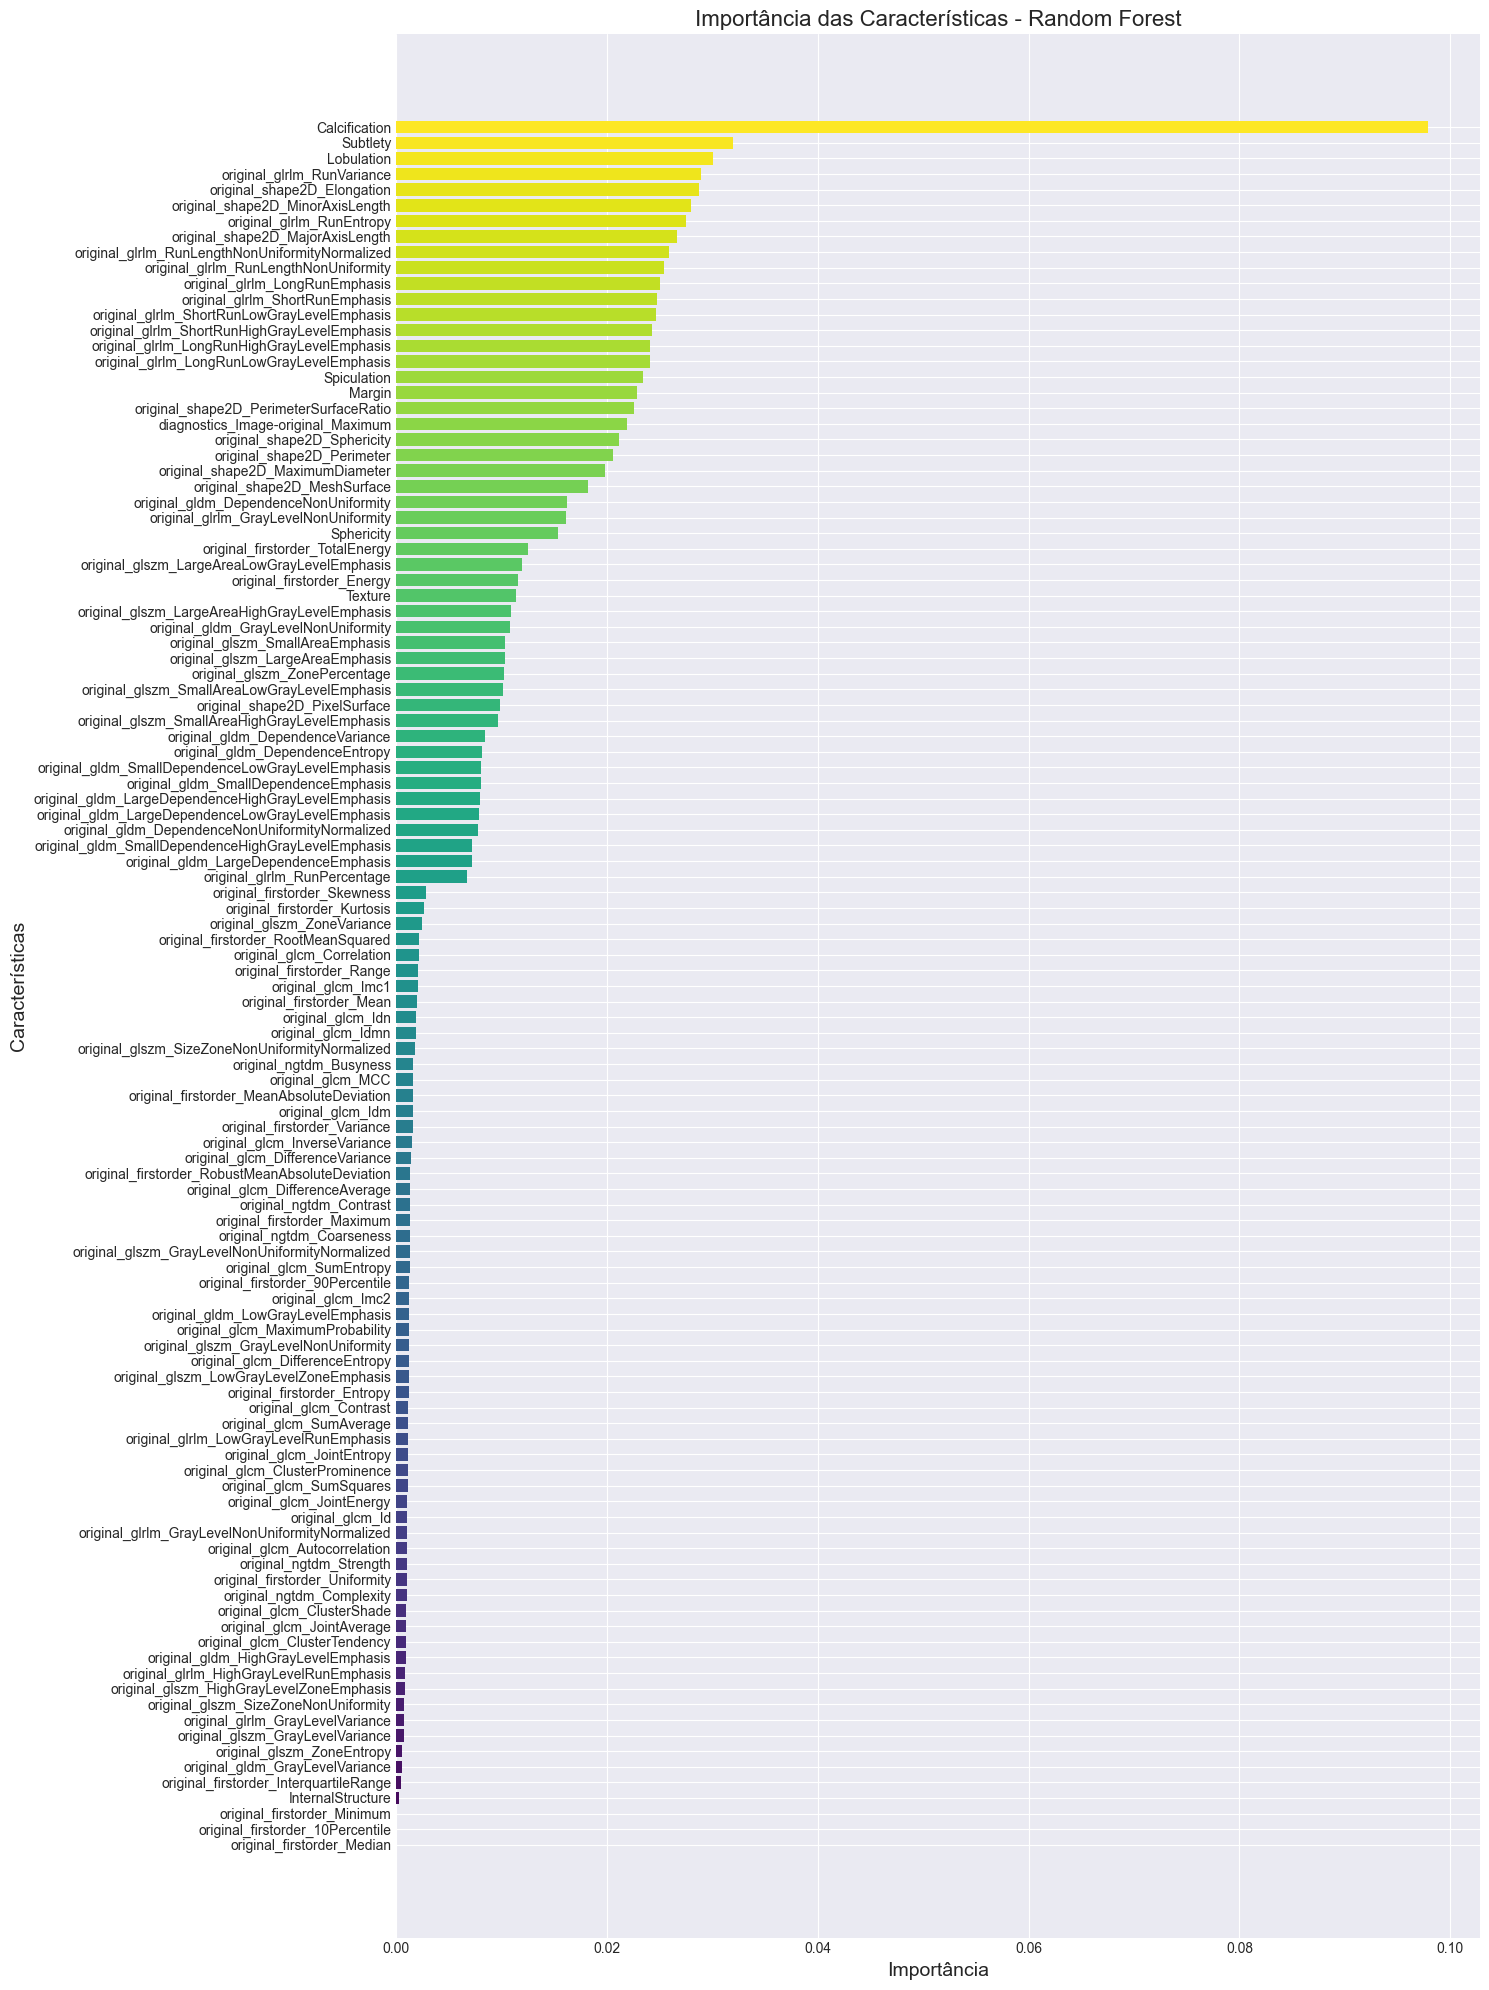

In [ ]:
feature_importances_2d = rf_features_2d.feature_importances_
importances_df_2d = pd.DataFrame({"Feature": X_randomforest.columns, "Importance": feature_importances_2d})
importances_df_2d = importances_df_2d.sort_values(by="Importance", ascending=False)
print("Feature Importances 2D:")
print(importances_df_2d)

# Ordenar as features por importância
importances_sorted = importances_df_2d.sort_values(by="Importance", ascending=True)
colors = cm.viridis(np.linspace(0, 1, len(importances_sorted)))

plt.figure(figsize=(15, 20))
plt.barh(importances_sorted["Feature"], importances_sorted["Importance"], color=colors)
plt.xlabel("Importância", fontsize=14)
plt.ylabel("Características", fontsize=14)
plt.title("Importância das Características - Random Forest", fontsize=16)
plt.gca().tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

Temos apenas o valor de importância de cada feature, para encontrarmos o **número de features relevantes decidimos apoiar a decisão num método utilizado em machine learning, método Elbow**, que encontra o **threshold ideal para a seleção de features com base na sua importância**.

Para aplicar o método, **calculamos a importância cumulativa** de cada feature e selecionamos as que se encontram **abaixo do valor de corte**.

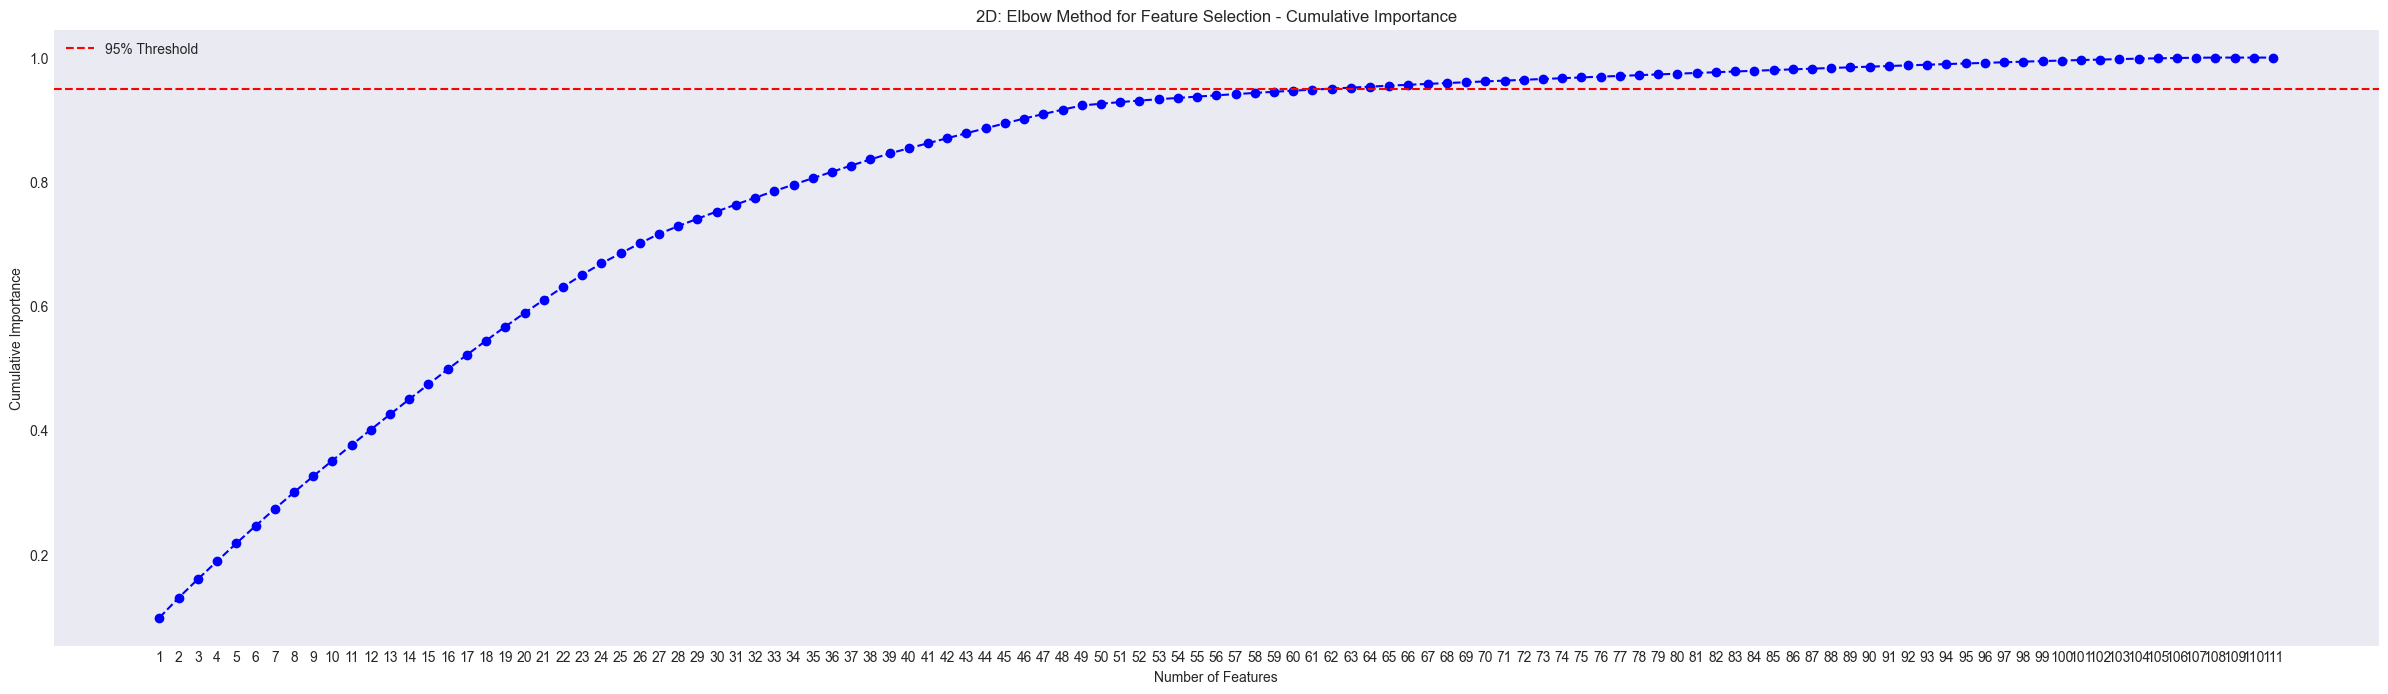

In [310]:
indices_2d = np.argsort(feature_importances_2d)[::-1]
cumulative_importance_2d = np.cumsum(feature_importances_2d[indices_2d])

num_features_2d = len(feature_importances_2d)
x = range(1, num_features_2d + 1)

plt.figure(figsize=(30, 8))
plt.plot(x, cumulative_importance_2d, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # Optional: threshold line
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("2D: Elbow Method for Feature Selection - Cumulative Importance")
plt.xticks(x)
plt.grid()
plt.legend()
plt.show()

Vamos definir o threshold como 0.95!

In [311]:
threshold = 0.95

selected_indices_2d = np.where(cumulative_importance_2d >= threshold)[0]
if selected_indices_2d.size > 0:
    selected_features_indices_2d = selected_indices_2d[0]
    selected_features_2d = importances_df_2d['Feature'].head(selected_features_indices_2d + 1).tolist()
else:
    selected_features_2d = []
print("Número de features selecionadas 2D:", len(selected_features_2d))

print("Features selecionadas 2D:")
data_randomforest_2d = radiomics_final_selected_2d[selected_features_2d]
features_randomforest_2d = pd.concat([data_randomforest_2d, y_randomforest_2d], axis=1)
features_randomforest_2d

Número de features selecionadas 2D: 63
Features selecionadas 2D:


Calcification  Subtlety  Lobulation  original_glrlm_RunVariance  \
0                 6         5           3                    1.047323   
1                 6         2           1                    1.643268   
2                 6         1           1                    1.043018   
3                 6         5           2                    0.568899   
4                 6         4           1                    0.825773   
...             ...       ...         ...                         ...   
2607              6         5           1                    0.823009   
2608              6         5           3                    1.032997   
2609              6         5           1                    0.851907   
2610              6         1           1                    0.814518   
2611              6         4           1                    1.251456   

      original_shape2D_Elongation  original_shape2D_MinorAxisLength  \
0                        0.780478                         44.910854   
1                        0.875037                         41.928777   
2                        0.837449                         32.654203   
3                        0.784334                         13.404688   
4                        0.883528                         20.601559   
...                           ...                               ...   
2607                     0.834938                         22.040900   
2608                     0.561402                         28.723704   
2609                     0.798296                         33.091465   
2610                     0.848707                         25.439728   
2611                     0.650249                          8.124406   

      original_glrlm_RunEntropy  original_shape2D_MajorAxisLength  \
0                      1.219781                         57.542760   
1                      0.826420                         47.916558   
2                      0.970033                         38.992455   
3                      0.988827                         17.090541   
4                      0.908444                         23.317369   
...                         ...                               ...   
2607                   1.548634                         26.398245   
2608                   1.069352                         51.164214   
2609                   1.040736                         41.452617   
2610                   1.079397                         29.974686   
2611                   0.798053                         12.494295   

      original_glrlm_RunLengthNonUniformityNormalized  \
0                                            0.631195   
1                                            0.740597   
2                                            0.727648   
3                                            0.640797   
4                                            0.704450   
...                                               ...   
2607                                         0.700111   
2608                                         0.648934   
2609                                         0.633376   
2610                                         0.723452   
2611                                         0.711481   

      original_glrlm_RunLengthNonUniformity  ...  original_firstorder_Range  \
0                                 74.650278  ...                       66.0   
1                                 52.906634  ...                        0.0   
2                                 43.422151  ...                       41.0   
3                                 16.060043  ...                        0.0   
4                                 23.279412  ...                        0.0   
...                                     ...  ...                        ...   
2607                              27.752206  ...                      134.0   
2608                              48.369202  ...                        0.0   
2609                              37.118338  ...   

Temos então **63 features** encontradas ao utilizar este método.

## **8º Passo** - Extração, Processamento e Seleção de Atributos 3D com PyRadiomics

Agora vamos continuar para a **extração dos dados 3D**, para este passo escolhemos utilizar apenas as features **'shape', 'glcm', 'glszm', 'first-order' e 'glrlm'**, fizemos esta seleção pois estas são as que apresentam **melhor resultados em diversos projeto de avaliação**, a **necessidade de seleção foi devida à alta quantidade de features** e ,portanto, **não seria ótimo realizar a extração das features de todos os nódulos presentes na nossa análise**.

In [ ]:
extractor_3d = featureextractor.RadiomicsFeatureExtractor() 

extractor_3d.disableAllFeatures()

extractor_3d.enableFeatureClassByName('shape') # Para SurfaceVolumeRatio, Maximum2DDiameterSlice, Sphericity
extractor_3d.enableFeatureClassByName('glcm') # Para Correlation
extractor_3d.enableFeatureClassByName('glszm') # Para SmallAreaEmphasis
extractor_3d.enableFeatureClassByName('firstorder')
extractor_3d.enableFeatureClassByName('glrlm')


In [ ]:
def processar_pacientes_3D(patient_dict, extractor):
    feature_list = []
    
    for patient_id in patient_dict:
        print(patient_id)
        # Obter os scans por paciente
        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()

        for _, scan in enumerate(scans):
            print(f"Processando paciente {patient_id}")
            
            # Obter todas as anotações (nódulos) para esse scan
            annotations = scan.annotations

            # Iterar dentro dos nódulos
            for nodule_idx, annotation in enumerate(annotations):
                if nodule_idx + 1 in patient_dict[patient_id]:
                    print(f"  Processando nódulo {nodule_idx + 1}/{len(annotations)}")
                    
                    # Chamar a função para processar cada nódulo
                    imagem, mascara = segmentation_3d(scan, annotation)
                    
                    # Converter a imagem para unidades HU
                    imagem_hu = convert_to_hu(imagem)
                    
                    # Converter a imagem e a máscara para SimpleITK
                    imagem_sitk = sitk.GetImageFromArray(imagem_hu)
                    mascara_sitk = sitk.GetImageFromArray(mascara.astype(np.uint8))
                    
                    # Extrair as features radiômicas
                    features = extractor.execute(imagem_sitk, mascara_sitk)
                    
                    feature_dict = dict(features)
                    
                    # Adicionar o ID do paciente e o ID do nódulo ao dicionário de features
                    feature_dict['Patient_ID'] = patient_id
                    feature_dict['Nodule_ID'] = nodule_idx + 1
                    
                    # Adicionar o dicionário à lista de features
                    feature_list.append(feature_dict)

    # Converter a lista de dicionários em um DataFrame do pandas
    df_features = pd.DataFrame(feature_list)
    
    # Salvar o DataFrame em um arquivo CSV com codificação UTF-8
    df_features.to_csv('radiomics_features_3d.csv', index=False, encoding='utf-8')
    
    return df_features

# Chamar a função principal para processar os pacientes e salvar o resultado no CSV
result_features = processar_pacientes_3D(patient_dict, extractor_3d)

'\ndef processar_pacientes_3D(patient_dict, extractor):\n    feature_list = []\n    \n    for patient_id in patient_dict:\n        print(patient_id)\n        # Obter os scans por paciente\n        scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == patient_id).all()\n\n        for _, scan in enumerate(scans):\n            print(f"Processando paciente {patient_id}")\n            \n            # Obter todas as anotações (nódulos) para esse scan\n            annotations = scan.annotations\n\n            # Iterar dentro dos nódulos\n            for nodule_idx, annotation in enumerate(annotations):\n                if nodule_idx + 1 in patient_dict[patient_id]:\n                    print(f"  Processando nódulo {nodule_idx + 1}/{len(annotations)}")\n                    \n                    # Chamar a função para processar cada nódulo\n                    imagem, mascara = segmentation_3d(scan, annotation)\n                    \n                    # Converter a imagem para unidades HU\n 

Uma vez os **dados extraídos** vamos realizar a **análise e limpeza** dos mesmos!

In [314]:
radiomics3d_df = pd.read_csv("radiomics_features_3d.csv")

In [315]:
radiomics3d_df.head()

diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                      2.2.6   
1                           v3.0.1                      2.2.6   
2                           v3.0.1                      2.2.6   
3                           v3.0.1                      2.2.6   
4                           v3.0.1                      2.2.6   

  diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                          2.5.2                          1.8.0   
1                          2.5.2                          1.8.0   
2                          2.5.2                          1.8.0   
3                          2.5.2                          1.8.0   
4                          2.5.2                          1.8.0   

  diagnostics_Versions_Python  \
0                     3.10.11   
1                     3.10.11   
2                     3.10.11   
3                     3.10.11   
4                     3.10.11   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  0b9beeba634aecfd62439c1850906895ec46d22b   
1  3305c9cfd21317246fc10e01cbec381001fd545d   
2  118a0902267d8bbe81f8da2b81af12eb7c146f0a   
3  118a0902267d8bbe81f8da2b81af12eb7c146f0a   
4  118a0902267d8bbe81f8da2b81af12eb7c146f0a   

  diagnostics_Image-original_Dimensionality  \
0                                        3D   
1                                        3D   
2                                        3D   
3                                        3D   
4                                        3D   

  diagnostics_Image-original_Spacing  ... original_glrlm_RunEntropy  \
0                    (1.0, 1.0, 1.0)  ...                  0.855662   
1                    (1.0, 1.0, 1.0)  ...                  1.105094   
2                    (1.0, 1.0, 1.0)  ...                  0.870629   
3                    (1.0, 1.0, 1.0)  ...                  0.730969   
4                    (1.0, 1.0, 1.0)  ...                  0.779647   

   original_glrlm_RunLengthNonUniformity  \
0                             560.437962   
1                            1132.844215   
2                             319.828569   
3                              65.418418   
4                             116.997643   

   original_glrlm_RunLengthNonUniformityNormalized  \
0                                         0.728848   
1                                         0.704691   
2                                         0.728283   
3                                         0.733684   
4                                         0.735776   

   original_glrlm_RunPercentage original_glrlm_RunVariance  \
0                      0.815598                   0.520519   
1                      0.801147                   0.545514   
2                      0.811396                   0.540904   
3                      0.833817                   0.364716   
4                      0.816812                   0.449092   

  original_glrlm_ShortRunEmphasis  \
0                        0.876955   
1                        0.863305   
2                        0.876231   
3                        0.878266   
4                        0.879559   

  original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                     0.912478   
1                                     3.358479   
2                                     0.981826  

Realizamos portanto a **extração de apenas 112 features**, estas relacionadas com a seleção feita previamente!

Vamos **renomear as colunas** como realizado para os dados 2D para **manter a coerência e mitigar os erros** que possam aparecer no futuro!

In [316]:
radiomics3d_df.rename(columns={
    'Patient_ID': 'PatientID',
    'Nodule_ID': 'NoduleID'
}, inplace=True)

Vamos ver se existem **valores nulos** no nosso dataset!

In [317]:
radiomics3d_df.isna().sum()

diagnostics_Versions_PyRadiomics                0
diagnostics_Versions_Numpy                      0
diagnostics_Versions_SimpleITK                  0
diagnostics_Versions_PyWavelet                  0
diagnostics_Versions_Python                     0
                                               ..
original_glrlm_ShortRunEmphasis                 0
original_glrlm_ShortRunHighGrayLevelEmphasis    0
original_glrlm_ShortRunLowGrayLevelEmphasis     0
PatientID                                       0
NoduleID                                        0
Length: 112, dtype: int64

**Não existem valores nulos**! Podemos continuar para **procurar colunas com valores únicos e fazer a sua eliminação**.

In [318]:
colunas_contagem3d = radiomics3d_df.nunique()
colunas_valor_unico3d = colunas_contagem3d[colunas_contagem3d == 1].index
print(colunas_valor_unico3d)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Mask-original_Spacing'],
      dtype='object')


In [319]:
radiomics3d_df.drop(columns = colunas_valor_unico3d, inplace = True)
print(radiomics3d_df.shape)

(2648, 101)


Uma vez estas eliminadas vamos **eliminar de seguida as colunas irrelevantes** que são as **mesmas encontradas nos dados 2D**.

In [320]:
radiomics3d_df = radiomics3d_df.drop(columns=colunas_irrelevantes)
print(radiomics3d_df.shape)

(2648, 93)


Vamos continuar por **procurar por colunas que não tenham dados do tipo 'int' ou 'float'**!

In [321]:
# Filtramos as colunas que não têm dados do tipo int ou float
colunas_nao_numericas3d = radiomics3d_df.select_dtypes(exclude=['int', 'float',]).columns
print(colunas_nao_numericas3d)

Index(['diagnostics_Image-original_Size', 'diagnostics_Mask-original_Size',
       'PatientID'],
      dtype='object')


O PatientID não vamos alterar pois vai servir de identificador para conseguirmos fazer a junção!

Relativamente aos **outros atributos vamos tentar perceber qual o problema**.

In [322]:
print(radiomics3d_df['diagnostics_Image-original_Size'].head())


0    (133, 512, 512)
1    (261, 512, 512)
2    (140, 512, 512)
3    (140, 512, 512)
4    (140, 512, 512)
Name: diagnostics_Image-original_Size, dtype: object


In [323]:
print(radiomics3d_df['diagnostics_Mask-original_Size'].head())

0    (133, 512, 512)
1    (261, 512, 512)
2    (140, 512, 512)
3    (140, 512, 512)
4    (140, 512, 512)
Name: diagnostics_Mask-original_Size, dtype: object


Verificamos então que as colunas **'diagnostics_Image-original_Size'** e **'diagnostics_Mask-original_Size'** estão no tipo **string**, contudo, de modo a melhorar a qualidade dos modelos que iremos usar no futuro, vamos **tranformar estas colunas em tuplos e de seguida subdividi-los em três novas colunas**, de modo a que cada uma delas fique com os **dados de cada posição do tuplo, convertendo tudo para numérico**.

In [324]:
# Converter strings de tupla para tupla numérica apenas se o valor for uma string: image
radiomics3d_df['diagnostics_Image-original_Size'] = radiomics3d_df['diagnostics_Image-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(", "))) if isinstance(x, str) else x
)

# Converter strings de tupla para tupla numérica apenas se o valor for uma string: mask
radiomics3d_df['diagnostics_Mask-original_Size'] = radiomics3d_df['diagnostics_Mask-original_Size'].apply(
    lambda x: tuple(map(float, x.strip("()").split(", "))) if isinstance(x, str) else x
)

radiomics3d_df[['diagnostics_Image-original_Size_x', 'diagnostics_Image-original_Size_y', 'diagnostics_Image-original_Size_z']] = pd.DataFrame(radiomics3d_df['diagnostics_Image-original_Size'].tolist(), index=radiomics3d_df.index)

radiomics3d_df[['diagnostics_Mask-original_Size_x', 'diagnostics_Mask-original_Size_y', 'diagnostics_Mask-original_Size_z']] = pd.DataFrame(radiomics3d_df['diagnostics_Mask-original_Size'].tolist(), index=radiomics3d_df.index)

# Remova as colunas originais com tuplas
radiomics3d_df = radiomics3d_df.drop(['diagnostics_Image-original_Size', 'diagnostics_Mask-original_Size'], axis=1)

In [325]:
print(radiomics3d_df.shape)

(2648, 97)


Tendo o nosso **dataset pronto** podemos avançar para a **junção do dataset com os dados obtidos das anotações dos radiologistas**!

A **forma e método utilizados vão ser os mesmos que utilizamos na junção dos dados 2D**!

In [326]:
radiomics_final_all_3d = pd.merge(pylidc_df, radiomics3d_df, on = ['PatientID', 'NoduleID'], how = 'inner')

In [327]:
radiomics_final_all_3d.head()

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
0  LIDC-IDRI-0001         1                    4             False   
1  LIDC-IDRI-0002         1                    2             False   
2  LIDC-IDRI-0003         1                    1             False   
3  LIDC-IDRI-0003         2                    4             False   
4  LIDC-IDRI-0003         3                    4             False   

   InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  Margin  \
0                  1           3              6         5           3       4   
1                  1           5              6         2           1       1   
2                  1           5              6         1           1       2   
3                  1           4              6         5           2       3   
4                  1           3              6         4           1       4   

   ...  original_glrlm_RunVariance  original_glrlm_ShortRunEmphasis  \
0  ...                    0.520519                         0.876955   
1  ...                    0.545514                         0.863305   
2  ...                    0.540904                         0.876231   
3  ...                    0.364716                         0.878266   
4  ...                    0.449092                         0.879559   

   original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                      0.912478   
1                                      3.358479   
2                                      0.981826   
3                                      0.878266   
4                                      0.879559   

   original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                     0.872459   
1                                     0.840952   
2                                     0.870237   
3                                     0.878266   
4                                     0.879559   

   diagnostics_Image-original_Size_x  diagnostics_Image-original_Size_y  \
0                              133.0                              512.0   
1                              261.0                              512.0   
2                              140.0                              512.0   
3                              140.0                              512.0   
4                              140.0                              512.0   

   diagnostics_Image-original_Size_z  diagnostics_Mask-original_Size_x  \
0                              512.0                             133.0   
1                              512.0                             261.0   
2                              512.0                             140.0   
3                              512.0                             140.0   
4                              512.0                             140.0   

   diagnostics_Mask-original_Size_y  diagnostics_Mask-original_Size_z  
0                             512.0                             512.0  
1                             512.0                             512.0  
2                             512.0                             512.0  
3                             512.0                             512.0  
4                             512.0                             512.0  

[5 rows x 108 columns]

Vamos verificar se existem **casos duplicados como existia no caso dos dados 2D**.

In [328]:
duplicados3d = radiomics_final_all_3d[radiomics_final_all_3d.duplicated(subset=['PatientID', 'NoduleID'], keep=False)]
duplicados3d.head()

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
386  LIDC-IDRI-0132         1                    3             False   
387  LIDC-IDRI-0132         1                    3             False   
388  LIDC-IDRI-0132         2                    2             False   
389  LIDC-IDRI-0132         2                    2             False   
390  LIDC-IDRI-0132         3                    1             False   

     InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
386                  1           4              6         3           1   
387                  1           4              6         3           1   
388                  1           3              6         4           1   
389                  1           3              6         4           1   
390                  1           3              6         4           4   

     Margin  ...  original_glrlm_RunVariance  original_glrlm_ShortRunEmphasis  \
386       3  ...                    0.517531                         0.899464   
387       3  ...                    0.521565                         0.895989   
388       5  ...                    0.341680                         0.909912   
389       5  ...                    0.423735                         0.881932   
390       2  ...                    0.264535                         0.903390   

     original_glrlm_ShortRunHighGrayLevelEmphasis  \
386                                      0.899464   
387                                      0.895989   
388                                      0.909912   
389                                      0.881932   
390                                      0.903390   

     original_glrlm_ShortRunLowGrayLevelEmphasis  \
386                                     0.899464   
387                                     0.895989   
388                                     0.909912   
389                                     0.881932   
390                                     0.903390   

     diagnostics_Image-original_Size_x  diagnostics_Image-original_Size_y  \
386                              127.0                              512.0   
387                              116.0                              512.0   
388                              127.0                              512.0   
389                              116.0                              512.0   
390                              127.0                              512.0   

     diagnostics_Image-original_Size_z  diagnostics_Mask-original_Size_x  \
386                              512.0                             127.0   
387                              512.0                             116.0   
388                              512.0                             127.0   
389                              512.0                             116.0   
390                              512.0                             127.0   

     diagnostics_Mask-original_Size_y  diagnostics_Mask-original_Size_z  
386                             512.0                             512.0  
387                             512.0                             512.0  
388                             512.0                             512.0  
389                             512.0                             512.0  
390                             512.0                             512.0  

[5 rows x 108 columns]

In [329]:
print(duplicados3d.shape)

(46, 108)


Após uma análise cuidadosa verificamos que são **os mesmos pacientes que têm vindo a ser encontrados**, portanto **vamos seguir a mesma metodologia usada anteriormente**!

In [331]:
radiomics_final_all_3d[radiomics_final_all_3d['PatientID'] == 'LIDC-IDRI-0132']

PatientID  NoduleID  QuantidadeAnotacoes  MaisDe4Anotacoes  \
386  LIDC-IDRI-0132         1                    3             False   
387  LIDC-IDRI-0132         1                    3             False   
388  LIDC-IDRI-0132         2                    2             False   
389  LIDC-IDRI-0132         2                    2             False   
390  LIDC-IDRI-0132         3                    1             False   
391  LIDC-IDRI-0132         3                    1             False   
392  LIDC-IDRI-0132         4                    4             False   
393  LIDC-IDRI-0132         4                    4             False   
394  LIDC-IDRI-0132         5                    1             False   
395  LIDC-IDRI-0132         5                    1             False   
396  LIDC-IDRI-0132         6                    1             False   
397  LIDC-IDRI-0132         6                    1             False   

     InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
386                  1           4              6         3           1   
387                  1           4              6         3           1   
388                  1           3              6         4           1   
389                  1           3              6         4           1   
390                  1           3              6         4           4   
391                  1           3              6         4           4   
392                  1           4              6         5           2   
393                  1           4              6         5           2   
394                  1           3              6         4           3   
395                  1           3              6         4           3   
396                  1           2              6         4           3   
397                  1           2              6         4           3   

     Margin  ...  original_glrlm_RunVariance  original_glrlm_ShortRunEmphasis  \
386       3  ...                    0.517531                         0.899464   
387       3  ...                    0.521565                         0.895989   
388       5  ...                    0.341680                         0.909912   
389       5  ...                    0.423735                         0.881932   
390       2  ...                    0.264535                         0.903390   
391       2  ...                    0.708169                         0.846100   
392       5  ...                    0.308248                         0.875817   
393       5  ...                    0.574800                         0.898694   
394       1  ...                    0.371023                         0.926012   
395       1  ...                    0.303367                         0.890142   
396       3  ...                    0.825504                         0.861016   
397       3  ...                    0.864212                         0.849474   

     original_glrlm_ShortRunHighGrayLevelEmphasis  \
386                                      0.899464   
387                                      0.895989   
388                                      0.909912   
389                                      0.881932   
390                                      0.903390   
391                                      0.846100   
392                                      0.875817   
393                                      0.898694   
394                                      0.926012   
395                                      0.890142   
396                                      0.861016   
397                                      0.849474   

     original_glrlm_ShortRunLowGrayLevelEmphasis  \
386                                     0.899464   
387                                     0.895989   
388                                     0.909912   
389                                     0.881932   
390                                     0.903390   
391                                     0

In [332]:
radiomics_final_all_3d.drop_duplicates(subset=['PatientID', 'NoduleID'], keep='first', inplace=True)

In [333]:
print(radiomics_final_all_3d.shape)

(2625, 108)


Uma vez **removidos e tendo verificado que temos os 2625 nódulos esperados** vamos **eliminar os casos onde existem mais de 4 anotações sobre um mesmo nódulo**.

In [334]:
print(radiomics_final_all_3d['MaisDe4Anotacoes'].value_counts())

MaisDe4Anotacoes
False    2612
True       13
Name: count, dtype: int64


In [335]:
radiomics_final_all_3d = radiomics_final_all_3d[radiomics_final_all_3d['MaisDe4Anotacoes'] == False]

E vamos **remover também as colunas que agora contêm informação irrelevante para o nosso estudo**.

In [336]:
radiomics_final_all_3d.drop(columns=['QuantidadeAnotacoes'], inplace=True)
radiomics_final_all_3d.drop(columns=['MaisDe4Anotacoes'], inplace=True)

In [337]:
radiomics_final_all_3d.reset_index(drop=True, inplace=True)

In [338]:
radiomics_final_all_3d

PatientID  NoduleID  InternalStructure  Sphericity  Calcification  \
0     LIDC-IDRI-0001         1                  1           3              6   
1     LIDC-IDRI-0002         1                  1           5              6   
2     LIDC-IDRI-0003         1                  1           5              6   
3     LIDC-IDRI-0003         2                  1           4              6   
4     LIDC-IDRI-0003         3                  1           3              6   
...              ...       ...                ...         ...            ...   
2607  LIDC-IDRI-1011         1                  4           5              6   
2608  LIDC-IDRI-1011         2                  1           3              6   
2609  LIDC-IDRI-1011         3                  1           4              6   
2610  LIDC-IDRI-1011         4                  1           4              6   
2611  LIDC-IDRI-1012         1                  1           4              6   

      Subtlety  Lobulation  Margin  Spiculation  Texture  ...  \
0            5           3       4            5        5  ...   
1            2           1       1            1        1  ...   
2            1           1       2            1        1  ...   
3            5           2       3            2        4  ...   
4            4           1       4            1        5  ...   
...        ...         ...     ...          ...      ...  ...   
2607         5           1       4            5        4  ...   
2608         5           3       4            1        5  ...   
2609         5           1       3            1        5  ...   
2610         1           1       2            1        1  ...   
2611         4           1       2            1        5  ...   

      original_glrlm_RunVariance  original_glrlm_ShortRunEmphasis  \
0                       0.520519                         0.876955   
1                       0.545514                         0.863305   
2                       0.540904                         0.876231   
3                       0.364716                         0.878266   
4                       0.449092                         0.879559   
...                          ...                              ...   
2607                    0.432866                         0.891968   
2608                    0.433158                         0.864611   
2609                    0.566699                         0.861718   
2610                    0.411385                         0.887794   
2611                    0.336309                         0.927437   

      original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                         0.912478   
1                                         3.358479   
2                                         0.981826   
3                                         0.878266   
4                                         0.879559   
...                                            ...   
2607                                      1.542134   
2608                                      0.864611   
2609                                      0.861718   
2610                                      1.011445   
2611                                      0.927437   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                        0.878266   
4                                        0.879559   
...                                           ...   
2607                                     0.828548   
2608                                     0.864611   
2609                                     0.861718   
2610                                     0.873611   
2611                                     0.927437   

      diagnostics_Image-original_Size_x  diagnostics_Image-original_Size_y  \
0                                 133.0                              512.0  

Temos o nosso **dataset limpo e pronto**, vamos continuar para a **seleção das features mais importantes usando a mesma metodologia usada anteriormente**!

### Seleção e Importância das Features – 3D

Foram seguidos os **mesmos passos e valores usados para a 'Seleção e Importância das Features – 2D'**.

In [339]:
radiomics_final_selected_3d = radiomics_final_all_3d
data_all_3d = radiomics_final_selected_3d.drop(columns=['Malignancy', 'PatientID', 'NoduleID'])  # Features
y_all_3d = radiomics_final_selected_3d['Malignancy']

#### **Lasso - L1 regularization**

In [340]:
X_lasso_3d = radiomics_final_selected_3d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_lasso_3d = radiomics_final_selected_3d['Malignancy']  # Alvo

# Normalizamos os dados usando o StandardScaler
scaler_3d = StandardScaler()
X_lasso_scaled_3d = scaler_3d.fit_transform(X_lasso_3d)

# Dividimos em treino e teste
X_train_3d, X_test_3d, y_train_3d, y_test_3d = train_test_split(X_lasso_scaled_3d, y_lasso_3d, test_size=0.3, random_state=42)

# Valores de C para testar
C_values = [0.05, 0.1, 1.0]

# Listas para armazenar as features selecionadas
selected_features_3d_L1_005 = []
selected_features_3d_L1_01 = []
selected_features_3d_L1_1 = []

# Testamos com cada valor de C
for C in C_values:
    model_3d = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model_3d.fit(X_train_3d, y_train_3d)

    coef_3d = model_3d.coef_

    # Se coef for uma matriz 2D (problema multiclasse), use apenas os coeficientes da primeira classe
    if coef_3d.ndim > 1:
        coef_3d = coef_3d[0]

    # Selecionamos as features com coeficientes diferentes de zero
    selected_features_3d = X_lasso_3d.columns[(coef_3d != 0).ravel()]

    if C == 0.05:
        selected_features_3d_L1_005 = selected_features_3d
    elif C == 0.1:
        selected_features_3d_L1_01 = selected_features_3d
    elif C == 1.0:
        selected_features_3d_L1_1 = selected_features_3d

# Por fim imprimimos as features selecionadas para cada valor de C
print("Selected features after L1 Regularization for C=0.05:", selected_features_3d_L1_005)
print("Selected features after L1 Regularization for C=0.1:", selected_features_3d_L1_01)
print("Selected features after L1 Regularization for C=1.0:", selected_features_3d_L1_1)

Selected features after L1 Regularization for C=0.05: Index(['Calcification', 'Subtlety', 'Lobulation', 'Margin', 'Spiculation',
       'Texture', 'original_shape_Elongation', 'original_shape_Sphericity',
       'original_glcm_Idmn', 'original_glszm_GrayLevelNonUniformity',
       'original_glszm_LargeAreaEmphasis',
       'original_glszm_LargeAreaHighGrayLevelEmphasis',
       'original_glszm_LargeAreaLowGrayLevelEmphasis',
       'original_firstorder_Kurtosis',
       'original_glrlm_ShortRunLowGrayLevelEmphasis',
       'diagnostics_Image-original_Size_x',
       'diagnostics_Mask-original_Size_x'],
      dtype='object')
Selected features after L1 Regularization for C=0.1: Index(['InternalStructure', 'Sphericity', 'Calcification', 'Subtlety',
       'Lobulation', 'Margin', 'Spiculation', 'Texture',
       'original_shape_Elongation', 'original_shape_Sphericity',
       'original_glcm_Idmn', 'original_glszm_GrayLevelNonUniformity',
       'original_glszm_GrayLevelVariance', 'original

In [341]:
print ("Número de features selecionadas para 3D:", len(selected_features_3d_L1_01))
print("Dataset com features significativas 3D:")
data_lasso_3d = radiomics_final_selected_3d[selected_features_3d_L1_01]
features_lasso_3d = pd.concat([data_lasso_3d, y_lasso_3d], axis=1)
features_lasso_3d

Número de features selecionadas para 3D: 25
Dataset com features significativas 3D:


InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  original_shape_Elongation  \
0          4            5        5                   0.933047   
1          1            1        1                   0.785904   
2          2            1        1                   0.835582   
3          3            2        4                   0.713714   
4          4            1        5                   0.945512   
...      ...          ...      ...                        ...   
2607       4            5        4                   0.806955   
2608       4            1        5                   0.561097   
2609       3            1        5                   0.790535   
2610       2            1        1                   0.878163   
2611       2            1        5                   0.828939   

      original_shape_Sphericity  ...  \
0                      0.124353  ...   
1                      0.118720  ...   
2                      0.163177  ...   
3                      0.247734  ...   
4                      0.195385  ...   
...                         ...  ...   
2607                   0.161158  ...   
2608                   0.133374  ...   
2609                   0.145364  ...   
2610                   0.159166  ...   
2611                   0.289373  ...   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.116667   
1                                         0.057643   
2                                         0.097223   
3                                         0.000089   
4                                         0.000027   
...                                            ...   
2607                                      0.088386   
2608                                      0.000002   
2609                                      0.000003   
2610                                      0.278937   
2611                                      0.000343   

      original_glszm_ZoneVariance  original_firstorder_10Percentile  \
0                   139576.960000                           -1000.0   
1                    95477.767258                           -1000.0   
2                    53868.000000                           -1000.0   
3                        0.000000                           -1000.0   
4                        0.000000                           -1000.0   
...                           ...                               ...   
2607                  4051.471074                           -1000.0   
2608                     0.000000                           -1000.0   
2609                     0.000000                           -1000.0   
2610                 10733.888889                           -1000.0   
2611                     0.000000                           -1000.0   

      original_firstorder_90Percentile  original_firstorder_Kurtosis  \
0                              -1000.0                    255.657530   
1                              -1000.0                    156.228761   
2                              -1000.0                    308.648826   
3                              -1000.0   

Obtemos então **25 features**!

#### **T-test**

In [342]:
X_ttest_3d = radiomics_final_selected_3d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_ttest_3d = radiomics_final_selected_3d['Malignancy']  # Alvo
benigno_ttest_3d = X_ttest_3d[y_ttest_3d == 0]
maligno_ttest_3d = X_ttest_3d[y_ttest_3d == 1]

t_test_results_3d = {}
for feature in X_ttest_3d.columns:
    t_stat, p_value = ttest_ind(benigno_ttest_3d[feature], maligno_ttest_3d[feature], equal_var=False)
    t_test_results_3d[feature] = p_value
sorted_t_test_results_3d = pd.Series(t_test_results_3d).sort_values()
print("3D Features ranked by significance (p-value):")
print(sorted_t_test_results_3d)

3D Features ranked by significance (p-value):
Calcification                        1.369260e-71
Lobulation                           1.554864e-31
Spiculation                          1.054391e-27
Margin                               6.177384e-21
original_shape_Sphericity            7.772725e-14
                                         ...     
original_shape_Elongation            9.814806e-01
diagnostics_Image-original_Size_y             NaN
diagnostics_Image-original_Size_z             NaN
diagnostics_Mask-original_Size_y              NaN
diagnostics_Mask-original_Size_z              NaN
Length: 103, dtype: float64


c:\Users\pedro\Desktop\Laboratorio de IA e CD\trabalho_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [343]:
features_ttest3d = sorted_t_test_results_3d[sorted_t_test_results_3d < 0.005].index.tolist()
print ("Número de features selecionadas para 3D:", len(features_ttest3d))
print("Dataset com features significativas 3D:")
data_ttest_3d = radiomics_final_selected_3d[features_ttest3d]
features_ttest_3d = pd.concat([data_ttest_3d, y_ttest_3d], axis=1)
features_ttest_3d

Número de features selecionadas para 3D: 45
Dataset com features significativas 3D:


Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape_Sphericity  Subtlety  \
0                      0.124353         5   
1                      0.118720         2   
2                      0.163177         1   
3                      0.247734         5   
4                      0.195385         4   
...                         ...       ...   
2607                   0.161158         5   
2608                   0.133374         5   
2609                   0.145364         5   
2610                   0.159166         1   
2611                   0.289373         4   

      original_shape_Maximum2DDiameterRow  original_shape_MinorAxisLength  \
0                               49.010203                       45.550617   
1                               47.169906                       34.257045   
2                               37.947332                       32.288129   
3                               17.262677                       12.501689   
4                               18.788294                       19.950917   
...                                   ...                             ...   
2607                            27.000000                       22.014102   
2608                            52.839379                       27.175070   
2609                            35.468296                       30.306794   
2610                            28.160256                       26.813846   
2611                            15.297059                       12.680470   

      original_shape_MajorAxisLength  original_shape_Maximum3DDiameter  ...  \
0                          48.819234                         50.019996  ...   
1                          43.589345                         53.018865  ...   
2                          38.641489                         37.947332  ...   
3                          17.516392                         17.262677  ...   
4                          21.100653                         19.000000  ...   
...                              ...                               ...  ...   
2607                       27.280467                         28.017851  ...   
2608                       48.431996                         58.677082  ...   
2609                       38.337072                         35.468296  ...   
2610                       30.534011                         28.160256  ...   
2611                       15.297228                         15.297059  ...   

      original_glrlm_ShortRunEmphasis  original_glrlm_LowGrayLevelRunEmphasis  \
0                            0.876955                                0.995505   
1                            0.863305                                0.977603   
2                            0.876231                                0.994006   
3                            0.878266                                1.000000   
4                            0.879559                                1.000000   
...                               ...                                     ...   
2607                         0.891968                                0.935020   
2608                         0.864611                                1.000000   
2609                         0.861718                                1.000000   
2610                         0.887794                                0.985817   
2611                       

Através do mesmo processo que o 2D foram encontrados **45 features relevantes**!

#### **Principal Component Analysis**

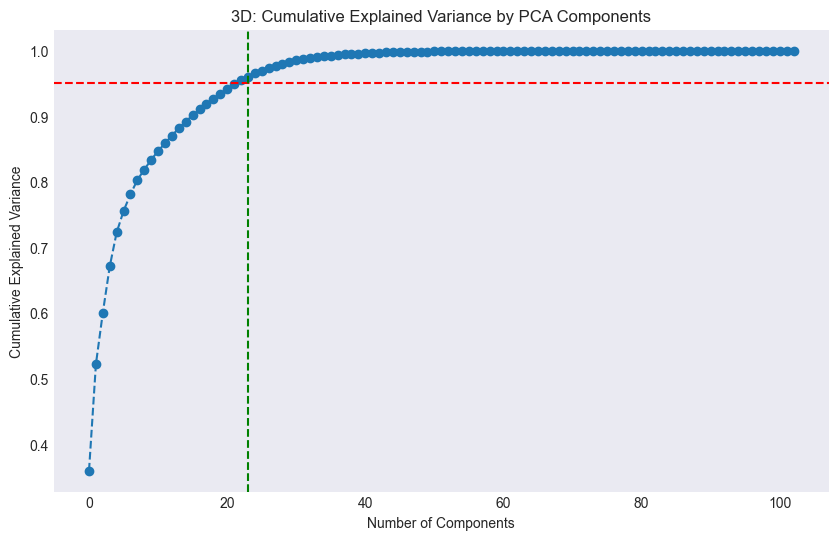

In [344]:
X_pca_3d = radiomics_final_selected_3d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_pca_3d = radiomics_final_selected_3d['Malignancy']  # Alvo
scaler_3d = StandardScaler()
X_scaled_pca_3d = scaler_3d.fit_transform(X_pca_3d)
pca_3d = PCA()
X_pca_3d = pca_3d.fit_transform(X_scaled_pca_3d)

explained_variance_3d = pca_3d.explained_variance_ratio_
cumulative_variance_3d = explained_variance_3d.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_3d, marker='o', linestyle='--')
plt.title('3D: Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold line
plt.axvline(x=np.argmax(cumulative_variance_3d >= 0.95) + 1, color='g', linestyle='--')  # Number of components for 95%
plt.show()

In [345]:
n_components_3d = np.argmax(cumulative_variance_3d >= 0.95) + 1 # quantidade de componentes que explica 95% da variância)
pca_final_3d = PCA(n_components = n_components_3d)
reduced_features_3d = pca_final_3d.fit_transform(X_scaled_pca_3d)
print("Número de features selecionadas 3D: ", n_components_3d)
data_pca_3d = pd.DataFrame(data=reduced_features_3d, columns=[f'PC{i}' for i in range(n_components_3d)])
features_pca_3d = pd.concat([data_pca_3d, y_pca_3d.reset_index(drop=True)], axis=1)
features_pca_3d

Número de features selecionadas 3D:  23


PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0    -1.278067   9.576904 -1.156507  3.757274 -1.615755 -3.860658 -1.097963   
1    -6.446833  13.619389 -3.613062  0.596606 -2.112019 -0.131476 -1.602061   
2    -0.996221   5.733703  0.031564  2.192263 -2.008760 -3.745283  0.056094   
3     2.203329  -1.096471  0.069448  2.726237  0.137445  0.199358 -0.468743   
4     2.113985  -0.136765 -0.356323  2.454730  0.104751  0.309677 -0.594976   
...        ...        ...       ...       ...       ...       ...       ...   
2607 -5.297076   2.860926  4.356948  2.181465 -1.113462 -0.902548 -0.763268   
2608  1.107153   5.528833 -2.353303  4.048105  0.710450  0.830768 -1.735930   
2609  1.557863   3.749841 -2.025833  2.536779  0.565856  0.668404 -1.483379   
2610 -0.981719   3.371373  1.978289  2.922428 -1.974097 -3.661183  0.200367   
2611  2.216879  -1.944034  0.831802  4.757672 -0.218913  0.312784  0.211815   

           PC7       PC8       PC9  ...      PC14       PC15      PC16  \
0     0.430526  1.950767 -0.486700  ...  0.091078  -0.486037  0.381170   
1    -2.048227 -4.508803 -1.437513  ... -0.481154   1.909910 -0.465967   
2    -2.082406 -3.410250  1.629019  ... -0.167175  -0.215375 -0.675650   
3    -0.203385  0.871312 -0.268072  ...  0.011146   0.096051 -0.277266   
4     0.899847 -0.135164  0.450913  ...  0.529577  -0.175882  0.877427   
...        ...       ...       ...  ...       ...        ...       ...   
2607 -0.579069  2.122959  0.914349  ... -1.704124  13.339463 -1.843934   
2608  0.689661  1.794291  1.167974  ...  0.002915   0.758514  0.104635   
2609  1.044880  0.158526  1.756955  ...  0.066838   0.350159  0.338420   
2610 -2.419413 -2.747674  1.499801  ...  0.334455  -1.066082 -0.456464   
2611  0.091883 -0.484289 -0.103599  ...  0.481568  -0.306185  0.125837   

          PC17      PC18      PC19      PC20      PC21      PC22  Malignancy  
0    -0.210300 -0.527217 -0.658950 -0.495133 -1.122424 -0.235036           1  
1    -0.636408  0.342292 -1.850376 -1.022287  2.162197  0.509957           1  
2    -0.835954 -1.635870 -0.566318  0.133759  0.135643 -0.098179           0  
3    -0.440305 -0.274018  0.529545 -0.285955  0.179709  0.749678           1  
4     0.687000  0.821011 -0.328398  0.449049 -0.672370  0.574434           1  
...        ...       ...       ...       ...       ...       ...         ...  
2607  2.795739 -0.400100  3.961215  0.882348 -1.066333 -0.489437           1  
2608 -1.757344 -0.842843 -0.055677  0.057312 -1.122804  1.180295           1  
2609 -0.979148  0.077650 -0.098412  0.242742 -0.963399  1.002933           1  
2610  0.526858 -1.207021 -0.362193 -1.182742 -1.125125  0.163694           0  
2611  0.686246  0.485241  0.604918 -0.100905  0.884664 -0.466499           0  

[2612 rows x 24 columns]

Conseguimos, através deste método, **23 colunas com informação relevante**!

#### **Correlação**

Top 15 features:
Index(['Malignancy', 'Calcification', 'Lobulation'], dtype='object')


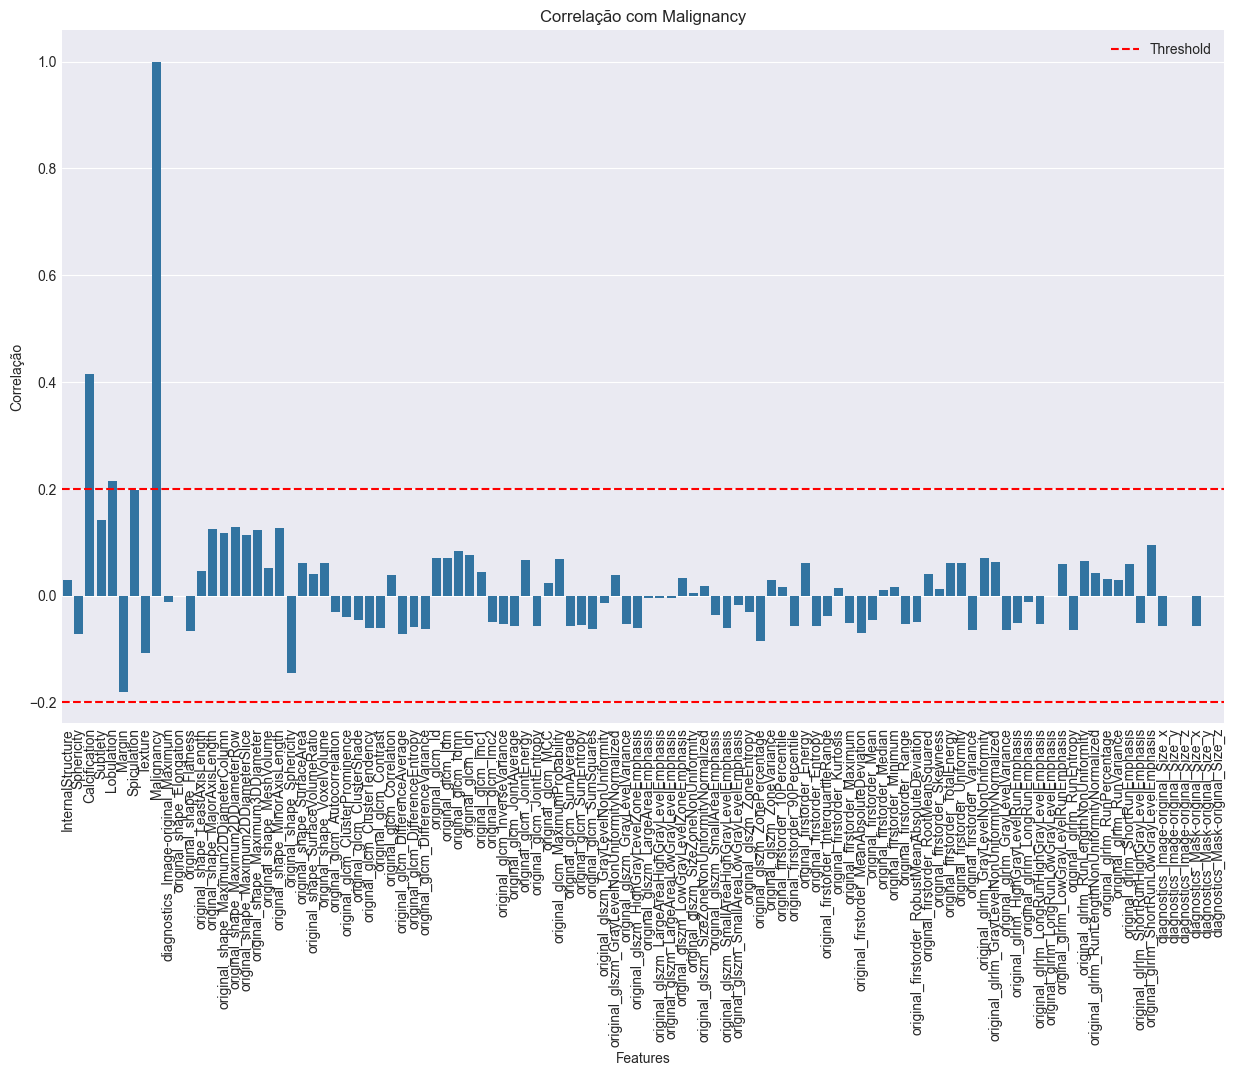

In [346]:
# Definimos o threshold para a correlação
correlation_threshold_3d = 0.2

features_correlacao_3d = radiomics_final_selected_3d.iloc[:, 2:]

# Calculamos a correlação de cada features em relação ao atributo 'Malignancy' 
correlation_with_malignancy_3d = features_correlacao_3d.corr()['Malignancy']

high_correlation_features_3d = correlation_with_malignancy_3d[correlation_with_malignancy_3d.abs() >= correlation_threshold_3d]

# Obtemos as 15 features com correlação mais alta
high_correlation_features_3d = high_correlation_features_3d.abs().nlargest(15).index

print("Top 15 features:")
print(high_correlation_features_3d)

plt.figure(figsize=(15, 9))
sns.barplot(x=correlation_with_malignancy_3d.index, y=correlation_with_malignancy_3d)
plt.xticks(rotation=90)
plt.title('Correlação com Malignancy')
plt.xlabel('Features')
plt.ylabel('Correlação')
plt.axhline(y=correlation_threshold_3d, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-correlation_threshold_3d, color='r', linestyle='--')
plt.legend()
plt.show()

O método de **correlação também não vai ser explorado**, pois verificou-se o mesmo, já explicado na 'Seleção e Importância das Features – 2D'.

#### **Random Forest**

In [347]:
X_randomforest_3d = radiomics_final_selected_3d.iloc[:, 2:].drop(columns=['Malignancy'])  # Features
y_randomforest_3d = radiomics_final_selected_3d['Malignancy']  # Alvo
rf_features_3d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_features_3d.fit(X_randomforest_3d, y_randomforest_3d)

RandomForestClassifier(random_state=42)

Feature Importances 3D:
                               Feature  Importance
2                        Calcification    0.093518
4                           Lobulation    0.027481
3                             Subtlety    0.025126
18      original_shape_MinorAxisLength    0.024655
9            original_shape_Elongation    0.024606
..                                 ...         ...
72          original_firstorder_Median    0.000000
98   diagnostics_Image-original_Size_y    0.000000
99   diagnostics_Image-original_Size_z    0.000000
101   diagnostics_Mask-original_Size_y    0.000000
102   diagnostics_Mask-original_Size_z    0.000000

[103 rows x 2 columns]


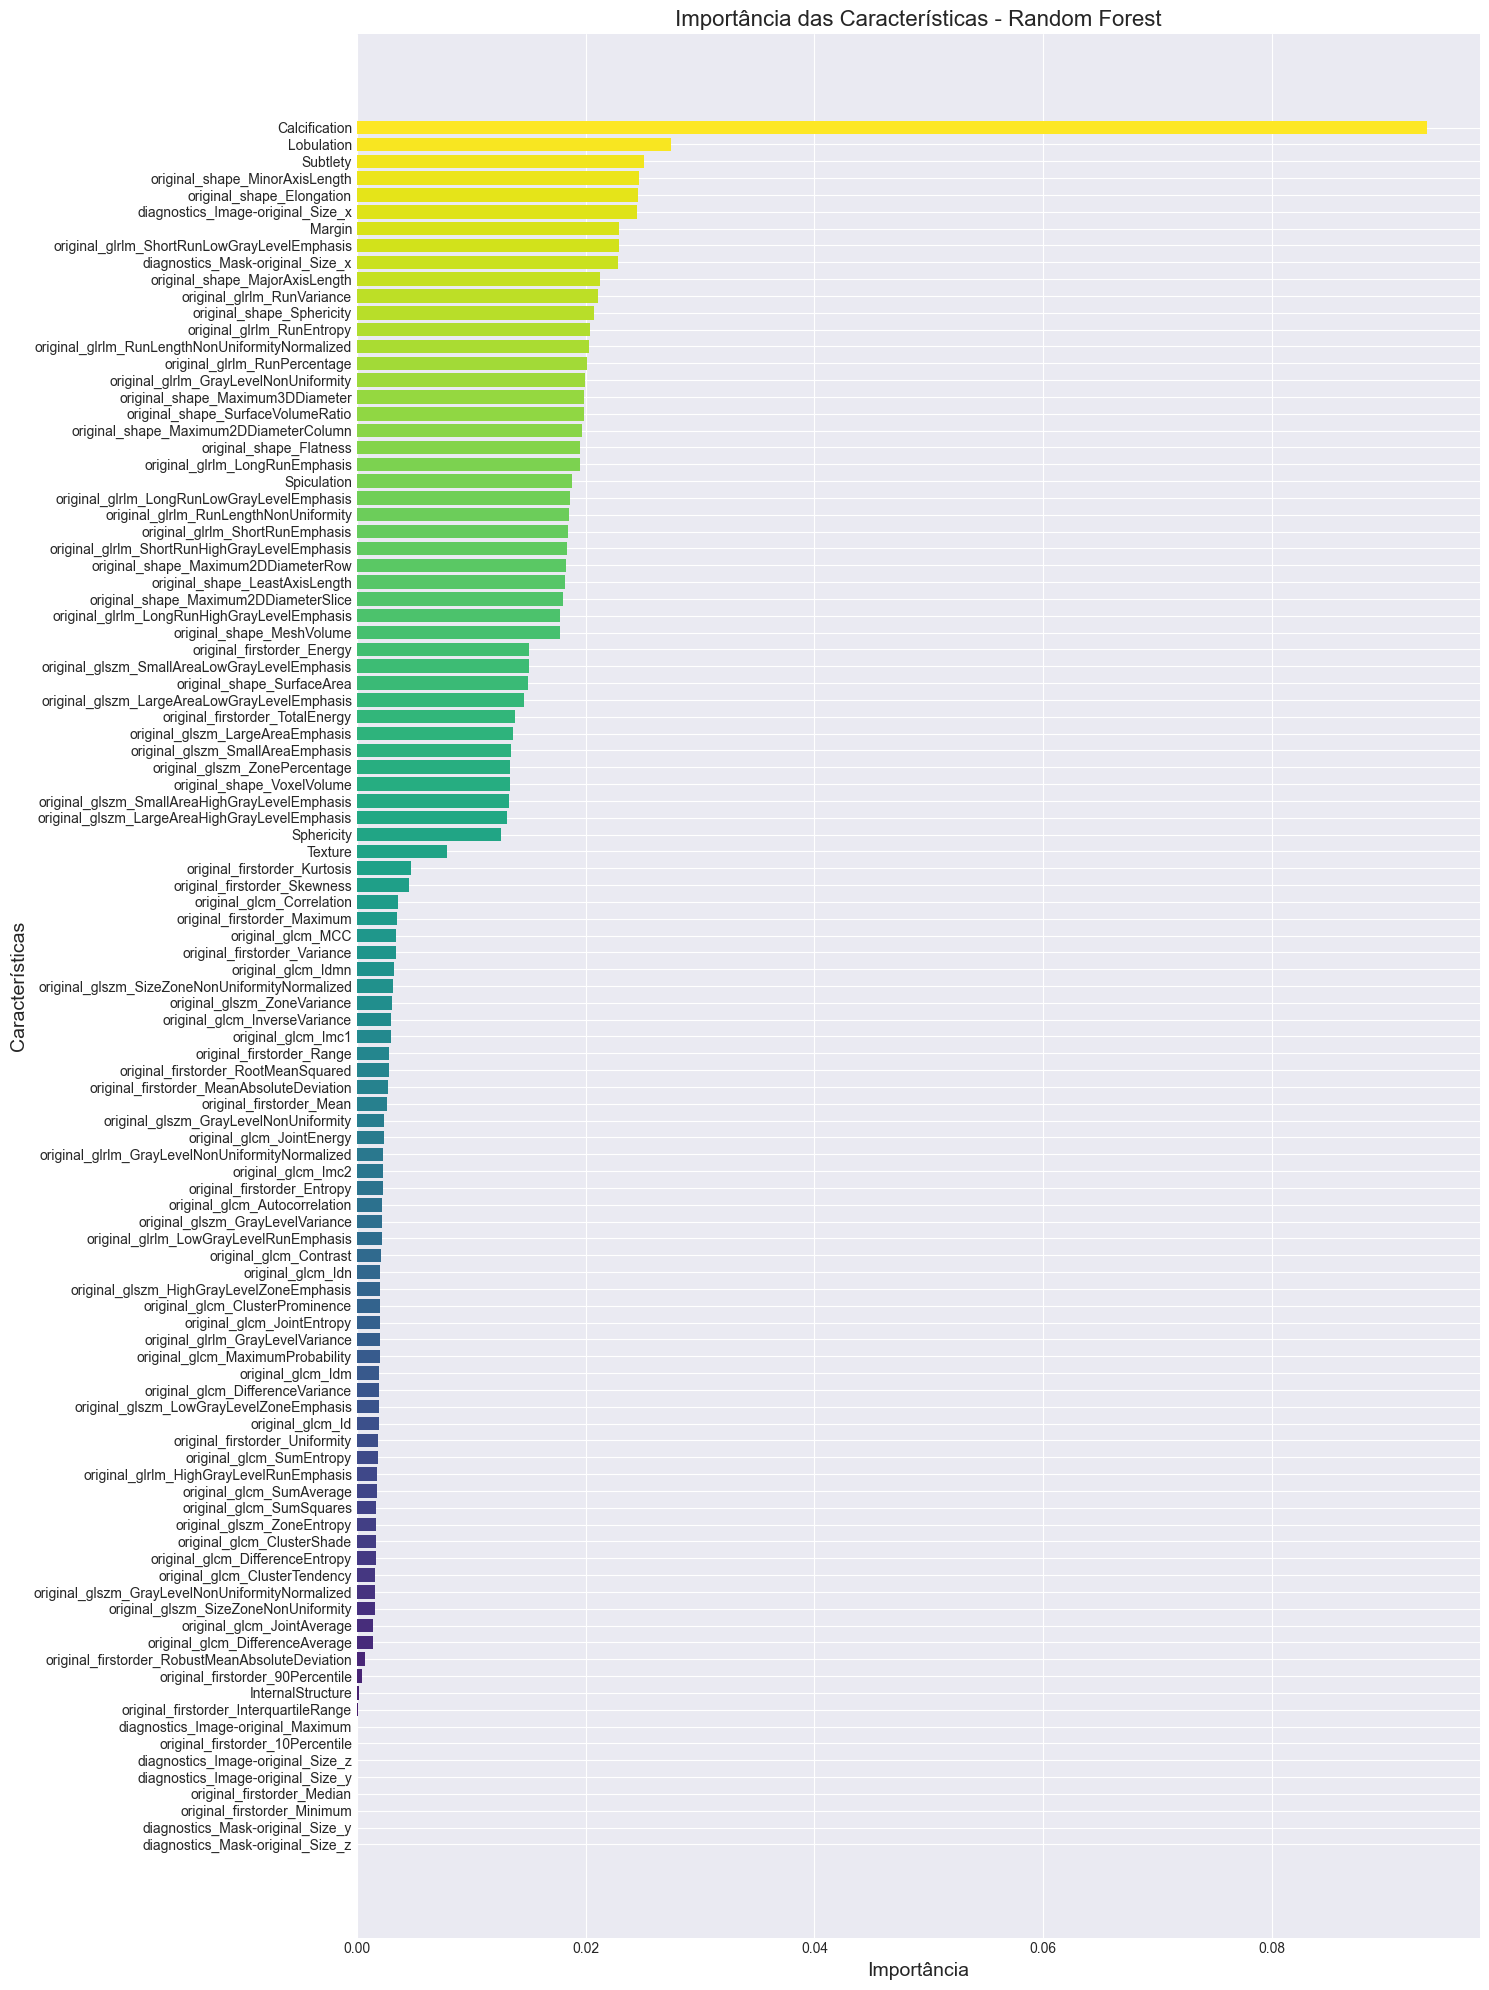

In [348]:
feature_importances_3d = rf_features_3d.feature_importances_
importances_df_3d = pd.DataFrame({"Feature": X_randomforest_3d.columns, "Importance": feature_importances_3d})
importances_df_3d = importances_df_3d.sort_values(by="Importance", ascending=False)
print("Feature Importances 3D:")
print(importances_df_3d)

# Ordenar as features por importância (para o gráfico)
importances_sorted_3d = importances_df_3d.sort_values(by="Importance", ascending=True)

# Gerar cores com gradiente (ex: azul → verde → amarelo)
colors = cm.viridis(np.linspace(0, 1, len(importances_sorted_3d)))

plt.figure(figsize=(15, 20))
plt.barh(importances_sorted_3d["Feature"], importances_sorted_3d["Importance"], color=colors)
plt.xlabel("Importância", fontsize=14)
plt.ylabel("Características", fontsize=14)
plt.title("Importância das Características - Random Forest", fontsize=16)
plt.gca().tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

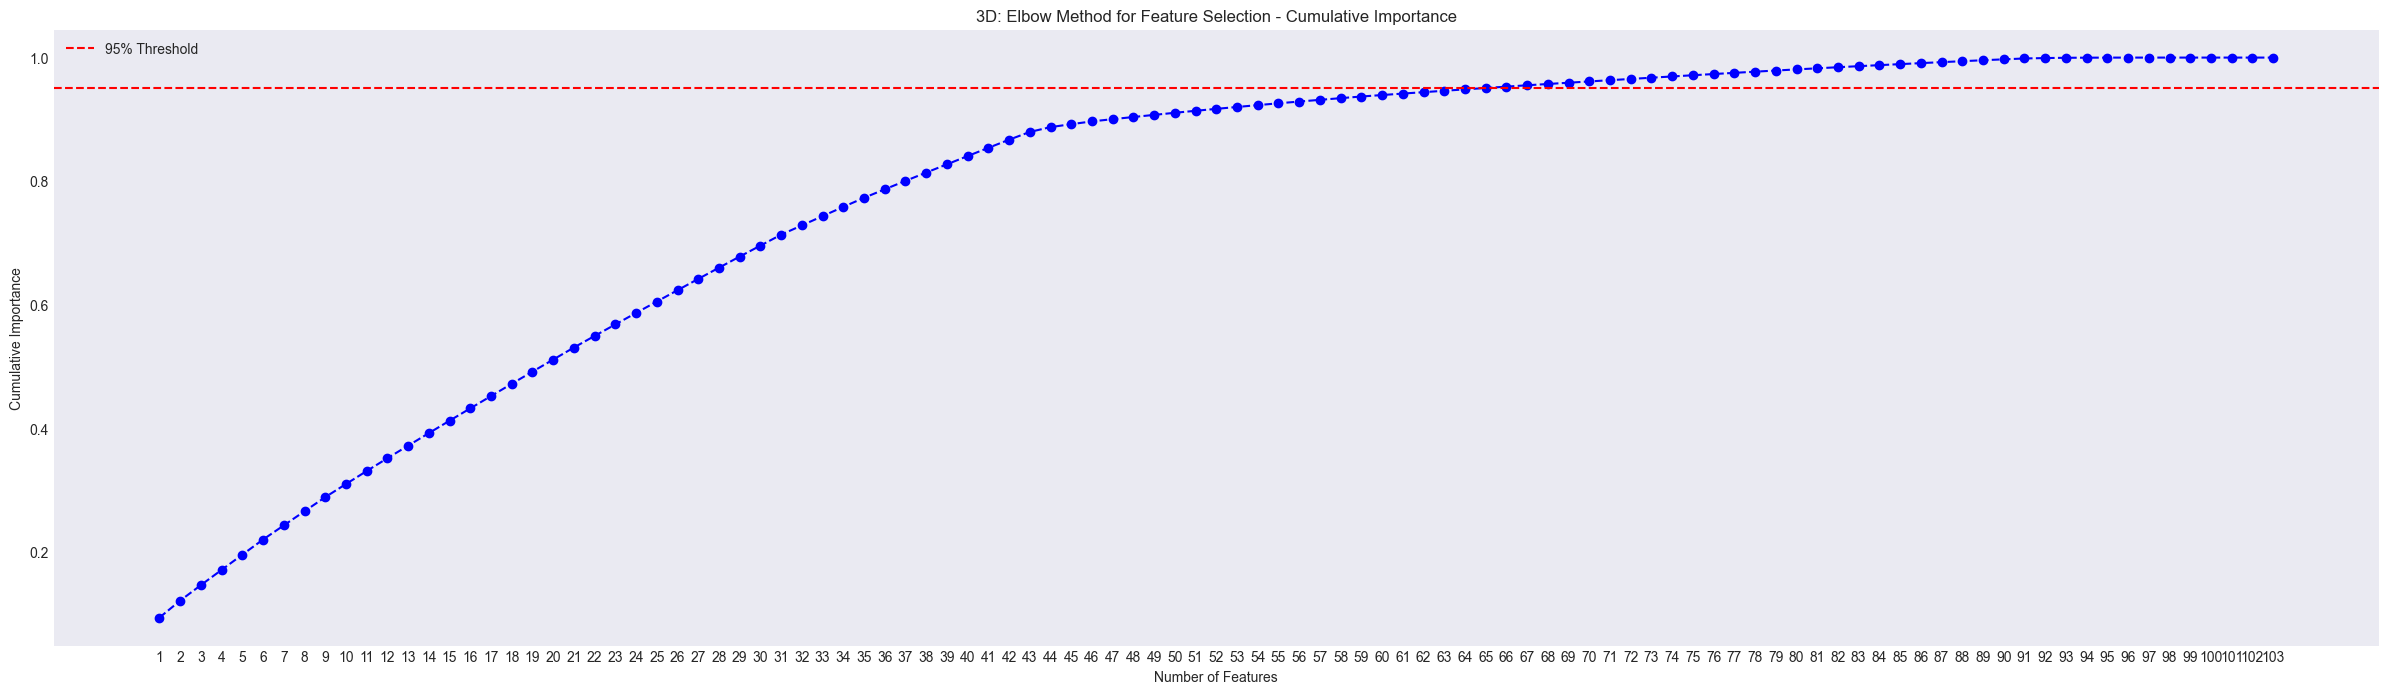

In [349]:
indices_3d = np.argsort(feature_importances_3d)[::-1]
cumulative_importance_3d = np.cumsum(feature_importances_3d[indices_3d])

num_features_3d = len(feature_importances_3d)
x = range(1, num_features_3d + 1)

plt.figure(figsize=(30, 8))
plt.plot(x, cumulative_importance_3d, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')  # Optional: threshold line
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("3D: Elbow Method for Feature Selection - Cumulative Importance")
plt.xticks(x)
plt.grid()
plt.legend()
plt.show()

In [350]:
threshold = 0.95

selected_indices_3d = np.where(cumulative_importance_3d >= threshold)[0]
if selected_indices_3d.size > 0:
    selected_features_indices_3d = selected_indices_3d[0]
    selected_features_3d = importances_df_3d['Feature'].head(selected_features_indices_3d + 1).tolist()
else:
    selected_features_3d = []
print("Número de features selecionadas 3D:", len(selected_features_3d))

print("Features selecionadas 3D:")
data_randomforest_3d = radiomics_final_selected_3d[selected_features_3d]
features_randomforest_3d = pd.concat([data_randomforest_3d, y_randomforest_3d], axis=1)
features_randomforest_3d

Número de features selecionadas 3D: 65
Features selecionadas 3D:


Calcification  Lobulation  Subtlety  original_shape_MinorAxisLength  \
0                 6           3         5                       45.550617   
1                 6           1         2                       34.257045   
2                 6           1         1                       32.288129   
3                 6           2         5                       12.501689   
4                 6           1         4                       19.950917   
...             ...         ...       ...                             ...   
2607              6           1         5                       22.014102   
2608              6           3         5                       27.175070   
2609              6           1         5                       30.306794   
2610              6           1         1                       26.813846   
2611              6           1         4                       12.680470   

      original_shape_Elongation  diagnostics_Image-original_Size_x  Margin  \
0                      0.933047                              133.0       4   
1                      0.785904                              261.0       1   
2                      0.835582                              140.0       2   
3                      0.713714                              140.0       3   
4                      0.945512                              140.0       4   
...                         ...                                ...     ...   
2607                   0.806955                              133.0       4   
2608                   0.561097                              133.0       4   
2609                   0.790535                              133.0       3   
2610                   0.878163                              133.0       2   
2611                   0.828939                              166.0       2   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                        0.878266   
4                                        0.879559   
...                                           ...   
2607                                     0.828548   
2608                                     0.864611   
2609                                     0.861718   
2610                                     0.873611   
2611                                     0.927437   

      diagnostics_Mask-original_Size_x  original_shape_MajorAxisLength  ...  \
0                                133.0                       48.819234  ...   
1                                261.0                       43.589345  ...   
2                                140.0                       38.641489  ...   
3                                140.0                       17.516392  ...   
4                                140.0                       21.100653  ...   
...                                ...                             ...  ...   
2607                             133.0                       27.280467  ...   
2608                             133.0                       48.431996  ...   
2609                             133.0                       38.337072  ...   
2610                             133.0                       30.534011  ...   
2611                             166.0                       15.297228  ...   

      original_firstorder_RootMeanSquared  \
0                              999.749918   
1                              996.825952   
2                              999.563877   
3                             1000.000000   
4                             1000.000000   
...                                   ...   
2607                           996.282009   
2608                          1000.000000   
2609                          1000.000000   
2610                           999.325260   
2611                          1000.000000   

      original_fi

Obtivemos um total de **65 features relevantes**!

# **Fase 4 — Modelação**

A quarta fase da metodologia **CRISP-DM** corresponde à **Modelação**, dedicada à construção e treino dos modelos preditivos. Nesta etapa foram aplicados diferentes algoritmos de aprendizagem supervisionada para classificar os nódulos pulmonares em benignos ou malignos, avaliando o impacto das variáveis selecionadas no desempenho de cada modelo. Foram testadas várias abordagens, recorrendo a validação cruzada para garantir a robustez e generalização dos resultados obtidos.

# **Fase 5 — Avaliação**

A quinta fase da metodologia **CRISP-DM** corresponde à **Avaliação**, onde os modelos desenvolvidos são testados e comparados com base em métricas de desempenho. Esta etapa visa determinar a eficácia preditiva de cada abordagem, analisando indicadores como **AUC**, **sensibilidade**, **especificidade** e **precisão**. Os resultados obtidos permitiram identificar o modelo com melhor equilíbrio entre desempenho e generalização, avaliando a sua adequação ao contexto clínico do diagnóstico do cancro do pulmão.

## **Modelação e Avaliação**

Após a **aplicação de diferentes métodos de seleção de features**, obtivemos diversos datasets, cada um refletindo uma **estratégia específica de redução e seleção de variáveis**.

O objetivo desta fase consiste em **avaliar e comparar o desempenho de vários modelos de classificação treinados sobre esses conjuntos de dados**. Selecionámos os modelos mais adequados para o problema de classificação de nódulos pulmonares, cuja escolha é devidamente justificada nas respetivas secções. 

- Dados 2D
    - Support Vector Machine
        - Support Vector Machine sem seleção de features
        - Support Vector Machine + PCA
        - Support Vector Machine + t-test
        - Support Vector Machine + Random Forest (seleção de features)
        - Resultados Support Vector Machine
    - Random Forest
        - Random Forest sem seleção de features
        - Random Forest + PCA
        - Random Forest + t-test
        - Random Forest + Random Forest (seleção de features
        - Resultados Random Forest
    - XGBoost
        - XGBoost sem seleção de features
        - XGBoost + PCA
        - XGBoost + t-test
        - XGBoost + Random Forest (seleção de features)
        - Resultados XGBoost

- Dados 3D
    - Support Vector Machine
        - Support Vector Machine sem seleção de features
        - Support Vector Machine + PCA
        - Support Vector Machine + t-test
        - Support Vector Machine + Random Forest (seleção de features)
        - Resultados Support Vector Machine
    - Random Forest
        - Random Forest sem seleção de features
        - Random Forest + PCA
        - Random Forest + t-test
        - Random Forest + Random Forest (seleção de features)
        - Resultados Random Forest
    - XGBoost
        - XGBoost sem seleção de features
        - XGBoost + PCA
        - XGBoost + t-test
        - XGBoost + Random Forest (seleção de features)
        - Resultados XGBoost



Após a análise comparativa do desempenho dos diferentes métodos de feature selection, será **selecionado o dataset 2D que apresentar os melhores resultados**. Este conjunto de dados será então **integrado com o dataset 3D que apresentar melhor resultados**, de forma a **combinar informações complementares provenientes das duas dimensões**.

O objetivo desta etapa é **avaliar se a fusão dos datasets contribui para uma melhoria na capacidade preditiva dos modelos**. 

Assim, o dataset resultante será utilizado para **treinar e testar os mesmos modelos de classificação previamente aplicados**, permitindo uma **comparação direta de desempenho entre as abordagens 2D, 3D e combinada**.

- Junção dos dados 2D + 3D
    - Support Vector Machine
    - Random Forest
    - XGBoost
    - Resultados Junção dos dados 2D + 3D


Vamos inicialmente definir as funções que vamos utilizar abaixo:

##  K-Fold Cross validation

Segundo o artigo “Mitigating Bias in Radiology Machine Learning: 1. Data Handling”, é **essencial garantir que amostras provenientes do mesmo paciente não sejam divididas entre treino e teste, evitando assim data leakage e resultados artificialmente inflacionados**.

Para resolver este problema, **implementámos uma divisão dos dados ao nível do paciente, assegurando que todos os nódulos de um mesmo indivíduo permanecem no mesmo conjunto**.

Isto foi feito com a **função group_k_fold_df, que utiliza o método GroupKFold do scikit-learn para criar folds de validação cruzada agrupados por PatientID, garantindo total independência entre treino e validação**.

In [577]:
def group_k_fold_split(data, labels, groups, n_splits=5):
    splitter = GroupKFold(n_splits=n_splits)
    folds = []
    for train_idx, test_idx in splitter.split(data, labels, groups):
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
        folds.append((X_train, X_test, y_train, y_test))
    return folds

In [578]:
folds_all_2d = group_k_fold_split(data_all_2d, y_all_2d, groups)
folds_lasso_2d = group_k_fold_split(data_lasso_2d, y_lasso, groups)
fold_ttest_2d = group_k_fold_split(data_ttest_2d, y_ttest_2d, groups)
fold_pca_2d = group_k_fold_split(data_pca_2d,y_pca_2d, groups)
fold_randomforest_2d = group_k_fold_split(data_randomforest_2d,y_randomforest_2d, groups)


fold_all_3d = group_k_fold_split(data_all_3d, y_all_3d, groups)
folds_lasso_3d = group_k_fold_split(data_lasso_3d, y_lasso_3d, groups)
fold_ttest_3d = group_k_fold_split(data_ttest_3d, y_ttest_3d, groups)
fold_pca_3d = group_k_fold_split(data_pca_3d,y_pca_3d, groups)
fold_randomforest_3d = group_k_fold_split(data_randomforest_3d,y_randomforest_3d, groups)


## Métricas a utilizar

Nesta secção são definidas as **métricas utilizadas para avaliar o desempenho dos modelos de classificação**.  
A avaliação baseia-se em indicadores clássicos da área biomédica, permitindo compreender não apenas a taxa de acertos, mas também o equilíbrio entre **erros de omissão (falsos negativos)** e **erros de alarme (falsos positivos)**.  
As métricas selecionadas foram: **Accuracy**, **Recall**, **Specificity**, **ROC-AUC**, **Confusion Matrix** e **Log Loss**.  
Cada uma delas é calculada ou representada graficamente nas funções seguintes.

In [579]:
def plot_confusion_matrix(test, pred, model):
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Benign", "Malign"], yticklabels=["Benign", "Malign"])
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    return cm

Neste bloco são calculadas as principais métricas de desempenho utilizadas para avaliar os modelos de classificação, nomeadamente **Accuracy**, **Recall**, **Specificity**, **ROC-AUC** e **Log Loss**. Estas métricas permitem quantificar o desempenho global do modelo, assegurando uma análise equilibrada entre a capacidade de deteção, a discriminação entre classes e a qualidade das probabilidades previstas.

In [580]:
def metrics_testing(test, pred):
    cm = confusion_matrix(test, pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(test, pred)
    recall = recall_score(test, pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    roc_auc = roc_auc_score(test, pred) if len(set(test)) > 1 else None
    logloss = log_loss(test, pred)
    return accuracy, recall, specificity, roc_auc, logloss


De forma a analisar a consistência dos modelos ao longo da validação cruzada, foi criada uma função para **plotar as métricas obtidas em cada *fold***.  
São apresentadas barras comparativas para *Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*, bem como as médias gerais.  
Esta visualização permite verificar a estabilidade dos resultados e a variabilidade do desempenho entre execuções.

In [581]:
def plot_metrics(accuracies, recalls, specifities, roc_aucs ,log_losses):
    # Convert lists to numpy arrays and tratar None em roc_aucs
    accuracies = np.array(accuracies, dtype=float)
    recalls = np.array(recalls, dtype=float)
    specifities = np.array(specifities, dtype=float)
    roc_aucs = np.array([r if r is not None else np.nan for r in roc_aucs], dtype=float)
    log_losses = np.array(log_losses, dtype=float)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
    k = len(accuracies)
    folds = np.arange(1, k + 1)

    # Plot accuracies (ylim 0-1)
    ax1.bar(folds, accuracies, alpha=0.7)
    ax1.set_xticks(folds); ax1.set_xlabel('Fold'); ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy average score: {:.2f}'.format(np.mean(accuracies)))
    ax1.set_ylim(0, 1)

    # Plot recalls (ylim 0-1)
    ax2.bar(folds, recalls, alpha=0.7)
    ax2.set_xticks(folds); ax2.set_xlabel('Fold'); ax2.set_ylabel('Recall')
    ax2.set_title('Recall average score: {:.2f}'.format(np.mean(recalls)))
    ax2.set_ylim(0, 1)

    # Plot specifities (ylim 0-1)
    ax3.bar(folds, specifities, alpha=0.7)
    ax3.set_xticks(folds); ax3.set_xlabel('Fold'); ax3.set_ylabel('Specificity')
    ax3.set_title('Specificity average score: {:.2f}'.format(np.mean(specifities)))
    ax3.set_ylim(0, 1)

    # Plot roc_auc (ylim 0-1). Para plotar, substituir NaN por 0 (mas usar nanmean para a média)
    roc_plot = np.nan_to_num(roc_aucs, nan=0.0)
    ax4.bar(folds, roc_plot, alpha=0.7)
    ax4.set_xticks(folds); ax4.set_xlabel('Fold'); ax4.set_ylabel('ROC AUC')
    # usar nanmean para ignorar possíveis NaNs ao calcular a média
    ax4.set_title('ROC AUC average score: {:.2f}'.format(np.nanmean(roc_aucs) if np.isnan(np.nanmean(roc_aucs))==False else 0.0))
    ax4.set_ylim(0, 1)

    # Plot log-losses (ylim 0-20)
    ax5.bar(folds, log_losses, alpha=0.7)
    ax5.set_xticks(folds); ax5.set_xlabel('Fold'); ax5.set_ylabel('Log Loss')
    ax5.set_title('Log Loss average score: {:.2f}'.format(np.mean(log_losses)))
    ax5.set_ylim(0, 20)

    plt.tight_layout()
    plt.show()

    metrics_average = [
        float(np.mean(accuracies)),
        float(np.mean(recalls)),
        float(np.mean(specifities)),
        float(np.nanmean(roc_aucs)),   # usa nanmean para lidar com possíveis None/NaN
        float(np.mean(log_losses))
    ]
    return metrics_average


Por fim, é gerado um gráfico comparativo que apresenta, lado a lado, as médias das métricas obtidas por cada método de seleção de atributos  
(**Without Selection**, **PCA**, **T-test**, **Random Forest** e **LASSO**).  
Esta visualização resume o desempenho global dos modelos, permitindo uma análise clara sobre **qual abordagem atinge o melhor equilíbrio entre sensibilidade, especificidade e erro probabilístico (Log Loss)**.

In [582]:
def plot_scores(average_metrics, model_name):
    average_acc, average_call, average_spec, average_roc, average_log = zip(*average_metrics)

    x = np.arange(len(average_metrics))  # número de abordagens
    width = 0.20

    plt.style.use('seaborn-v0_8-darkgrid')

    # Criar duas figuras lado a lado: 1) métricas principais, 2) log loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    bars1 = ax1.bar(x - 1.5*width, average_acc, width, label='Accuracy', color='lightskyblue')
    bars2 = ax1.bar(x - 0.5*width, average_call, width, label='Recall', color='yellowgreen')
    bars3 = ax1.bar(x + 0.5*width, average_spec, width, label='Specificity', color='plum')
    bars4 = ax1.bar(x + 1.5*width, average_roc, width, label='ROC AUC', color='lightcoral')

    ax1.set_ylabel('Scores (0–1)', fontsize=10)
    ax1.set_title(f'{model_name} – Main Metrics', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Without Selection', 'PCA', 'T-test', 'RF', 'LASSO'], fontsize=9, rotation=15)
    ax1.legend(fontsize=8)
    ax1.set_ylim(0, 1.05)
    ax1.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Adicionar valores acima das barras
    for bar in bars1 + bars2 + bars3 + bars4:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}",
                 ha='center', va='bottom', fontsize=8, color='black')

    # GRÁFICO 2: Log Loss separado
    bars5 = ax2.bar(x, average_log, width*1.5, color='orange', label='Log Loss')
    ax2.set_ylabel('Log Loss', fontsize=10)
    ax2.set_title(f'{model_name} – Log Loss', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Without Selection', 'PCA', 'T-test', 'RF', 'LASSO'], fontsize=9, rotation=15)
    ax2.legend(fontsize=8)
    ax2.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Adicionar valores acima das barras
    for bar in bars5:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}",
                 ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

## Modelo - Support Vector Machine


Neste bloco é implementado o modelo **Support Vector Machine (SVM)**, utilizando o algoritmo de otimização por enxame de partículas (*Particle Swarm Optimization* – PSO) para encontrar os melhores hiperparâmetros (**C** e **gamma**) do kernel *RBF*.  
A validação é realizada através de uma abordagem *k-fold cross-validation*, garantindo uma avaliação robusta do desempenho do modelo em diferentes subconjuntos dos dados.  
Em cada iteração, são calculadas as métricas principais (*Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*), que posteriormente são agregadas para análise comparativa.

In [ ]:
def svm_k_fold(fold, k=5, random_state=42):
    accuracies, recalls, specifities, roc_aucs, loglosses = [], [], [], [], []

    # Limites de parametros C e gamma
    lower_bounds = [0.1, 0.001] 
    upper_bounds = [100, 1]     

    def objective_function(params):
        C, gamma = params
        fold_accs = []
        for X_train, X_test, y_train, y_test in fold:
            model = SVC(C=C, gamma=gamma, kernel='rbf', random_state=random_state)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_accs.append(accuracy_score(y_test, y_pred))
        return -np.mean(fold_accs) 

    best_params, _ = pso(objective_function, lower_bounds, upper_bounds, swarmsize=30, maxiter=50)
    best_C, best_gamma = best_params
    print(f"Melhores parâmetros a partir do PSO: C={best_C}, gamma={best_gamma}")

    for X_train, X_test, y_train, y_test in fold:
        model = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc, call, spec, roc, log = metrics_testing(y_test, predictions)
        accuracies.append(acc)
        recalls.append(call)
        specifities.append(spec)
        roc_aucs.append(roc)
        loglosses.append(log)
        
    return accuracies, recalls, specifities, roc_aucs, loglosses


In [584]:
results_svm_2d = []
results_svm_3d = []

th_svm_2d = []
th_svm_3d = []

## Modelo - Random Forest

Neste bloco é implementado o modelo **Random Forest**, um algoritmo de aprendizagem supervisionada baseado em múltiplas árvores de decisão.  
O modelo é treinado e avaliado através de **validação cruzada (*k-fold*)**, garantindo uma estimativa mais fiável do desempenho em diferentes subconjuntos dos dados.  
Para cada *fold*, são calculadas as métricas principais (*Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*), permitindo avaliar a capacidade do modelo em classificar corretamente os nódulos pulmonares como benignos ou malignos.

In [585]:
def random_forest_kfold(fold, k=5, random_state=42):
    accuracies, recalls, specifities, roc_aucs, loglosses = [], [], [], [], []
    
    model = RandomForestClassifier(random_state=random_state)
    for X_train, X_test, y_train, y_test in fold:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc, call, spec, roc, log = metrics_testing(y_test, predictions)
        accuracies.append(acc)
        recalls.append(call)
        specifities.append(spec)
        roc_aucs.append(roc)
        loglosses.append(log)
    
    return accuracies, recalls, specifities, roc_aucs, loglosses

In [679]:
results_rf_2d = []
results_rf_3d = []
th_rf_2d = []
th_rf_3d = []

## Modelo - XGBoost

Neste bloco é implementado o modelo **XGBoost (Extreme Gradient Boosting)**, um algoritmo baseado em *boosting* de árvores de decisão, reconhecido pela sua elevada eficiência e capacidade preditiva.  
O modelo é treinado e validado através de **validação cruzada (*k-fold*)**, avaliando o seu desempenho em diferentes subconjuntos dos dados.  
Durante o processo, são calculadas as métricas principais (*Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*), permitindo comparar a performance do XGBoost com os restantes classificadores testados.

In [587]:
def xgboost_k_fold(fold, k=5, random_state=42):
    accuracies, recalls, specifities, roc_aucs, loglosses = [], [], [], [], []
    
    model = XGBClassifier(n_estimators=100, random_state=random_state, eval_metric='logloss')
    for X_train, X_test, y_train, y_test in fold:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        acc, call, spec, roc, log = metrics_testing(y_test, predictions)
        accuracies.append(acc)
        recalls.append(call)
        specifities.append(spec)
        roc_aucs.append(roc)
        loglosses.append(log)
        
    return accuracies, recalls, specifities, roc_aucs, loglosses

In [680]:
results_xgb_2d = []
results_xgb_3d = []
th_xgb_2d = []
th_xgb_3d =[]

## SVM - 2D

### Support Vector Machine Sem Seleção de Features

Neste bloco é treinado o modelo **SVM (Support Vector Machine)** sem seleção de *features*. 
Os resultados obtidos servem como **ponto de referência inicial**, permitindo comparar o desempenho do modelo original com as versões que recorrem a métodos de seleção de atributos.  
As métricas calculadas (*Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*) permitem avaliar a capacidade preditiva e a estabilidade do modelo ao longo dos *folds* de validação.

In [589]:
data_all_2d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               145.0   
2608       4            1        5                               241.0   
2609       3            1        5                               238.0   
2610       2            1        1                               145.0   
2611       2            1        5                               245.0   

      original_shape2D_Elongation  ...  \
0                        0.780478  ...   
1                        0.875037  ...   
2                        0.837449  ...   
3                        0.784334  ...   
4                        0.883528  ...   
...                           ...  ...   
2607                     0.834938  ...   
2608                     0.561402  ...   
2609                     0.798296  ...   
2610                     0.848707  ...   
2611                     0.650249  ...   

      original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          4.333346   
1                                          0.000111   
2                                          2.000082   
3                                          0.000918   
4                                          0.000517   
...                                             ...   
2607                                       9.500713   
2608                                       0.000098   
2609                                       0.000160   
2610                                       2.250080   
2611                                       0.002268   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.120383   
1                                         0.000111   
2                                         0.125082   
3                                         0.000918   
4                                         0.000517   
...                                            ...   
2607                                      0.067842   
2608                                      0.000098   
2609                                      0.000160   
2610                                      0.375080   
2611                                      0.002268   

      original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
0                   1.584963e+00                       0.018293   
1                  -3.203427e-16                       0.010526   
2                   1.000000e+00                       0.025316   
3                  -3.203427e-16                       0.030303   
4                  -3.203427e-16                      

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=85.13264607417628, gamma=0.46781365554783116


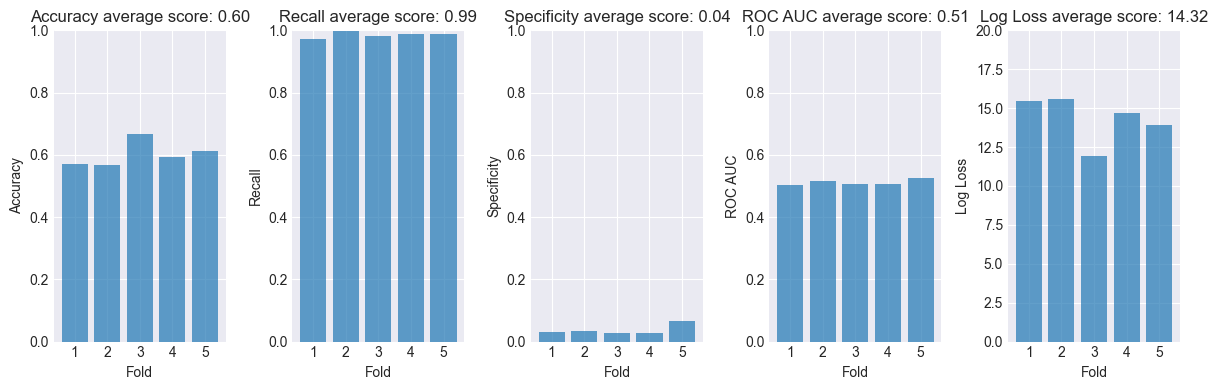

[0.6026285136590405, 0.9853619317122086, 0.037747875702549796, 0.5115549037073792, 14.322720120391846]


In [590]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = svm_k_fold(folds_all_2d)
th_svm_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

### Support Vector Machine + PCA

Treino do modelo **SVM** utilizando as *features* transformadas pelo **PCA**, com posterior avaliação das métricas de desempenho para comparação com os restantes métodos.

In [591]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     2.940010  18.430755  6.971970 -5.305699  2.359204  0.910508  8.332709   
1    -1.986601   7.594077  6.591035  1.996285 -1.000592  0.719544 -1.469020   
2     2.020623   8.222577  1.119425 -2.603072 -1.804638  2.141331  5.740737   
3    -1.983425  -0.821853  0.377891  0.729857 -0.151230 -1.585481  0.588032   
4    -1.951841   0.655908  1.338934  1.223112 -1.435798 -0.754853 -0.034606   
...        ...        ...       ...       ...       ...       ...       ...   
2607  7.250143   4.883816 -3.318700 -2.649773  1.169158 -0.393980  0.796710   
2608 -1.827461   7.835941  6.416450  0.372486  2.487625 -1.696200 -1.171867   
2609 -1.832153   4.994345  4.326983  0.619211  1.211798 -1.881902 -0.668762   
2610  4.413054   6.097318 -2.943503 -1.731531 -1.789203  0.983187  3.928351   
2611 -2.274648  -2.063480 -0.266352 -0.109914  0.192440  1.230530 -0.622005   

           PC7       PC8       PC9  ...      PC12      PC13      PC14  \
0     2.336693 -2.915547  0.017969  ... -0.756161  1.981433 -5.861229   
1    -2.647705  1.424797 -2.969977  ...  1.293172  0.739599  1.027169   
2    -1.366194 -1.168388 -4.157199  ...  0.608553  1.128979 -1.873654   
3    -0.464691 -0.329500  0.748224  ... -0.071724  0.414916  0.264112   
4     0.208923 -0.082535 -0.266395  ... -0.394195  0.251880  0.272272   
...        ...       ...       ...  ...       ...       ...       ...   
2607  0.139595 -4.568912  2.072729  ...  4.636215 -8.181715  8.048030   
2608  0.578392  1.075440  0.815441  ... -1.240422 -0.711455  0.434569   
2609  0.885214  0.610669 -0.603051  ...  0.186584 -0.564258  0.267869   
2610 -2.399115 -0.647537 -4.097041  ...  1.315425 -1.990781 -1.120333   
2611 -0.668275 -0.055742 -0.043713  ... -0.918736 -0.799118  0.096911   

          PC15      PC16      PC17      PC18      PC19      PC20      PC21  
0     5.753884 -2.144556  1.532330 -1.172926  5.587918 -2.286055  1.929889  
1    -0.545074  0.036286  0.262718  0.634654 -0.139583  0.431204  0.283702  
2     2.122376 -0.794198  0.584232  1.454060 -0.437333 -0.499048  0.014856  
3     0.357385  0.327355  0.225480  0.253487 -0.078950  0.075219  0.897225  
4    -0.154137  0.396402 -0.259846 -1.228032 -0.490167  0.246650  0.409252  
...        ...       ...       ...       ...       ...       ...       ...  
2607  7.926626  2.526727 -5.147892  0.756594  0.728031 -4.034499  0.548797  
2608 -1.253925  0.200226 -0.320893  0.193077 -0.249144  0.459411  0.146271  
2609 -0.729283  0.205014 -0.080115 -0.223995 -0.817165  0.380958  0.953935  
2610  0.793302 -1.287269 -0.969464  0.947751 -0.520690  2.901461 -0.437681  
2611 -0.454650 -0.123594  0.232184  0.821024 -0.054793 -0.111634  0.866164  

[2612 rows x 22 columns]

Stopping search: Swarm best objective change less than 1e-08
Melhores parâmetros a partir do PSO: C=61.26649343779887, gamma=0.004086269394978038


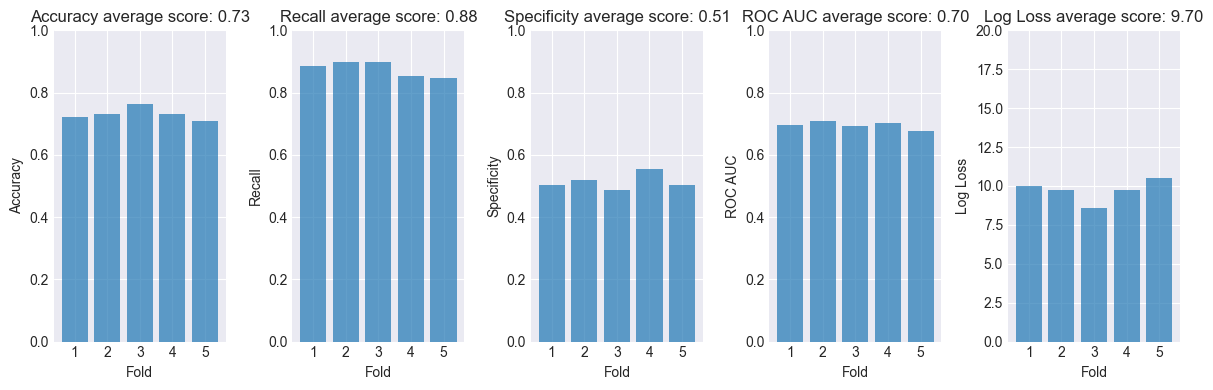

[0.7308608602008748, 0.8771233632046913, 0.5136265806871505, 0.6953749719459209, 9.700757868364818]


In [592]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = svm_k_fold(fold_pca_2d)
th_svm_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

### Support Vector Machine + t-test

Aplicação do modelo **SVM** sobre as *features* selecionadas através do **T-test**, avaliando o impacto da seleção estatística de atributos no desempenho preditivo.

In [593]:
data_ttest_2d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape2D_Sphericity  original_gldm_DependenceNonUniformity  \
0                        0.116476                             110.097561   
1                        0.140517                              95.000000   
2                        0.154282                              69.430380   
3                        0.237705                              33.000000   
4                        0.191705                              44.000000   
...                           ...                                    ...   
2607                     0.178190                              24.346154   
2608                     0.138573                              66.584158   
2609                     0.154955                              61.531646   
2610                     0.167193                              46.118644   
2611                     0.276215                              17.380952   

      original_glrlm_GrayLevelNonUniformity  \
0                                113.551582   
1                                 71.250000   
2                                 57.533811   
3                                 24.750000   
4                                 33.000000   
...                                     ...   
2607                              30.577463   
2608                              73.000000   
2609                              58.000000   
2610                              41.178608   
2611                              15.500000   

      original_gldm_GrayLevelNonUniformity  Subtlety  \
0                               160.036585         5   
1                                95.000000         2   
2                                77.025316         1   
3                                33.000000         5   
4                                44.000000         4   
...                                    ...       ...   
2607                             42.692308         5   
2608                            101.000000         5   
2609                             79.000000         5   
2610                             55.135593         1   
2611                             21.000000         4   

      original_shape2D_MajorAxisLength  ...  original_firstorder_Uniformity  \
0                            57.542760  ...                        0.975833   
1                            47.916558  ...                        1.000000   
2                            38.992455  ...                        0.975004   
3                            17.090541  ...                        1.000000   
4                            23.317369  ...                        1.000000   
...                                ...  ...                             ...   
2607                         26.398245  ...                        0.821006   
2608                         51.164214  ...                        1.000000   
2609                         41.452617  ...                        1.000000   
2610                         29.974686  ...                        0.934502   
2611                         12.494295  ...                        1.000000   

      original_glrlm_GrayLevelNonUniformityNormalized  original_glcm_Idmn  \
0                                            0.966060            0.996393   
1                                            1.000000            1.000000   
2 

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=50.4515326186163, gamma=0.001


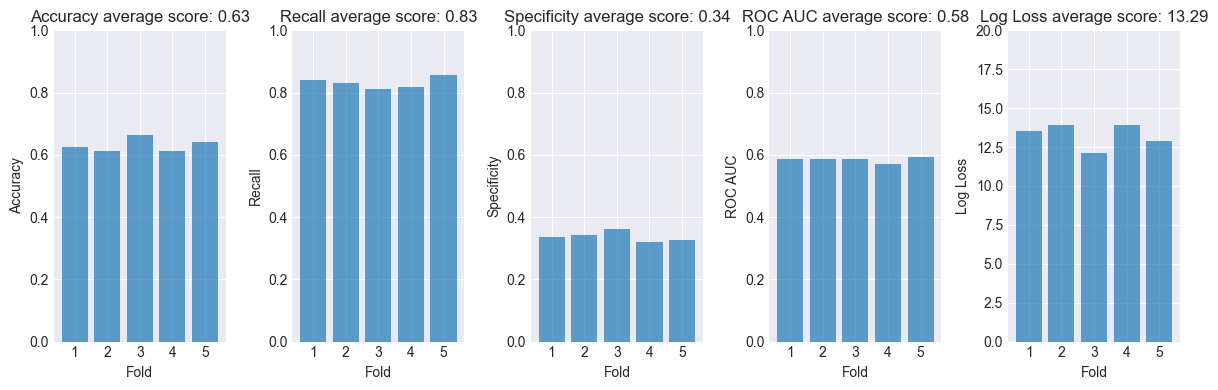

[0.6313260514420929, 0.8316234293726911, 0.33730751127811043, 0.5844654703254009, 13.288356015418412]


In [594]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = svm_k_fold(fold_ttest_2d)
th_svm_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

### Support Vector Machine + Random Forest (seleção de features)

Treino do modelo **SVM** utilizando as *features* selecionadas com base na **importância das variáveis obtida pelo Random Forest**, de forma a avaliar o impacto dessa seleção no desempenho do classificador.

In [595]:
data_randomforest_2d

Calcification  Subtlety  Lobulation  original_glrlm_RunVariance  \
0                 6         5           3                    1.047323   
1                 6         2           1                    1.643268   
2                 6         1           1                    1.043018   
3                 6         5           2                    0.568899   
4                 6         4           1                    0.825773   
...             ...       ...         ...                         ...   
2607              6         5           1                    0.823009   
2608              6         5           3                    1.032997   
2609              6         5           1                    0.851907   
2610              6         1           1                    0.814518   
2611              6         4           1                    1.251456   

      original_shape2D_Elongation  original_shape2D_MinorAxisLength  \
0                        0.780478                         44.910854   
1                        0.875037                         41.928777   
2                        0.837449                         32.654203   
3                        0.784334                         13.404688   
4                        0.883528                         20.601559   
...                           ...                               ...   
2607                     0.834938                         22.040900   
2608                     0.561402                         28.723704   
2609                     0.798296                         33.091465   
2610                     0.848707                         25.439728   
2611                     0.650249                          8.124406   

      original_glrlm_RunEntropy  original_shape2D_MajorAxisLength  \
0                      1.219781                         57.542760   
1                      0.826420                         47.916558   
2                      0.970033                         38.992455   
3                      0.988827                         17.090541   
4                      0.908444                         23.317369   
...                         ...                               ...   
2607                   1.548634                         26.398245   
2608                   1.069352                         51.164214   
2609                   1.040736                         41.452617   
2610                   1.079397                         29.974686   
2611                   0.798053                         12.494295   

      original_glrlm_RunLengthNonUniformityNormalized  \
0                                            0.631195   
1                                            0.740597   
2                                            0.727648   
3                                            0.640797   
4                                            0.704450   
...                                               ...   
2607                                         0.700111   
2608                                         0.648934   
2609                                         0.633376   
2610                                         0.723452   
2611                                         0.711481   

      original_glrlm_RunLengthNonUniformity  ...  original_glcm_Correlation  \
0                                 74.650278  ...                   0.491907   
1                                 52.906634  ...                   1.000000   
2                                 43.422151  ...                   0.488140   
3                                 16.060043  ...                   1.000000   
4                                 23.279412  ...                   1.000000   
...                                     ...  ...                        ...   
2607                              27.752206  ...                   0.506889   
2608                              48.369202  ...                   1.000000   
2609                              37.118338  ...   

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=67.88918819137366, gamma=0.471291364133172


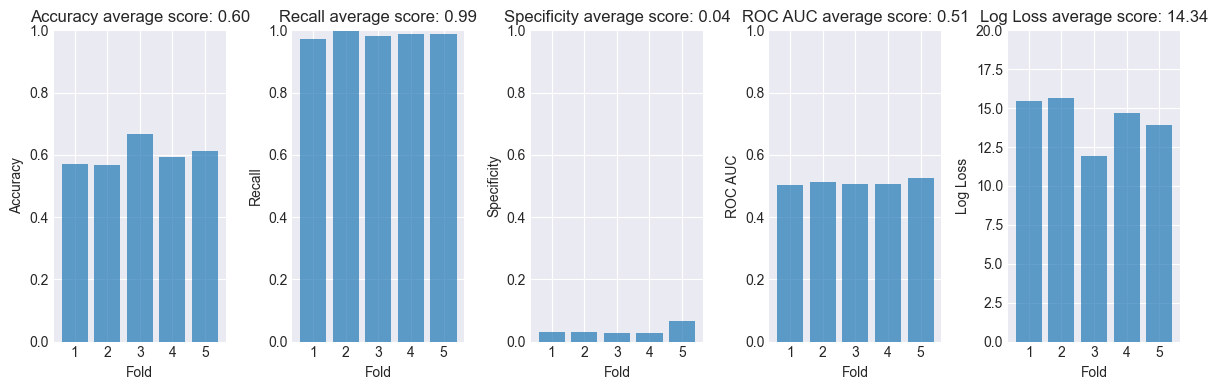

[0.6022461044812202, 0.9853619317122086, 0.036889506603837344, 0.5111257191580231, 14.336503544250018]


In [596]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = svm_k_fold(fold_randomforest_2d)
th_svm_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

### Support Vector Machine + LASSO

Treino do modelo **SVM** utilizando as *features* selecionadas pelo método **LASSO**, analisando se a regularização L1 contribui para melhorar a capacidade de generalização do classificador.

In [597]:
data_lasso_2d

InternalStructure  Calcification  Subtlety  Lobulation  Margin  \
0                     1              6         5           3       4   
1                     1              6         2           1       1   
2                     1              6         1           1       2   
3                     1              6         5           2       3   
4                     1              6         4           1       4   
...                 ...            ...       ...         ...     ...   
2607                  4              6         5           1       4   
2608                  1              6         5           3       4   
2609                  1              6         5           1       3   
2610                  1              6         1           1       2   
2611                  1              6         4           1       2   

      Spiculation  Texture  diagnostics_Image-original_Maximum  \
0               5        5                               400.0   
1               1        1                               400.0   
2               1        1                               400.0   
3               2        4                               400.0   
4               1        5                               400.0   
...           ...      ...                                 ...   
2607            5        4                               145.0   
2608            1        5                               241.0   
2609            1        5                               238.0   
2610            1        1                               145.0   
2611            1        5                               245.0   

      original_shape2D_Elongation  original_shape2D_PerimeterSurfaceRatio  \
0                        0.780478                                2.595471   
1                        0.875037                                2.884337   
2                        0.837449                                2.883393   
3                        0.784334                                2.896964   
4                        0.883528                                3.218951   
...                           ...                                     ...   
2607                     0.834938                                3.206197   
2608                     0.561402                                2.851203   
2609                     0.798296                                2.882234   
2610                     0.848707                                3.178396   
2611                     0.650249                                3.259801   

      original_shape2D_Sphericity  original_firstorder_10Percentile  \
0                        0.116476                           -1000.0   
1                        0.140517                           -1000.0   
2                        0.154282                           -1000.0   
3                        0.237705                           -1000.0   
4                        0.191705                           -1000.0   
...                           ...                               ...   
2607                     0.178190                           -1000.0   
2608                     0.138573                           -1000.0   
2609                     0.154955                           -1000.0   
2610                     0.167193                           -1000.0   
2611                     0.276215                           -1000.0   

      original_firstorder_Kurtosis  original_firstorder_Minimum  \
0                       113.421045                      -1000.0   
1                         0.000000                      -1000.0   
2                        77.012821                      -1000.0   
3                         0.000000                      -1000.0   
4                         0.000000                      -1000.0   
...                            ...                          ...   
2607                     20.701325                      -1000.0   
2608                      0.000000

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=72.27184305318642, gamma=0.001


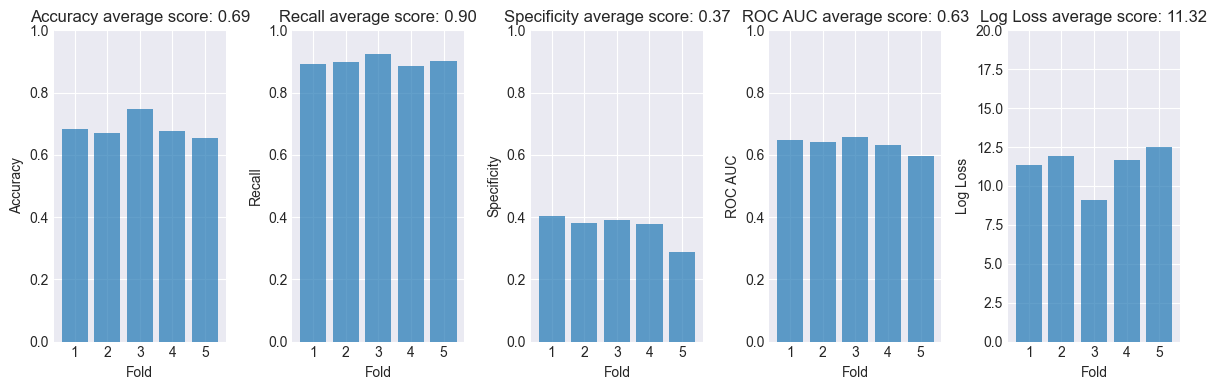

[0.6860713683948338, 0.9010819535968217, 0.3679153223394545, 0.634498637968138, 11.315134786496458]


In [598]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = svm_k_fold(folds_lasso_2d)
th_svm_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_svm_2d.append(average_metrics_2d)

### Resultados Support Vector Machine - 2d

São apresentadas barras comparativas para *Accuracy*, *Recall*, *Specificity*, *ROC-AUC* e *Log Loss*, bem como as médias gerais.  
Esta visualização permite verificar a estabilidade dos resultados e a variabilidade do desempenho entre execuções.

In [599]:
print(results_svm_2d)

[[0.6026285136590405, 0.9853619317122086, 0.037747875702549796, 0.5115549037073792, 14.322720120391846], [0.7308608602008748, 0.8771233632046913, 0.5136265806871505, 0.6953749719459209, 9.700757868364818], [0.6313260514420929, 0.8316234293726911, 0.33730751127811043, 0.5844654703254009, 13.288356015418412], [0.6022461044812202, 0.9853619317122086, 0.036889506603837344, 0.5111257191580231, 14.336503544250018], [0.6860713683948338, 0.9010819535968217, 0.3679153223394545, 0.634498637968138, 11.315134786496458]]


In [600]:
print("Número de abordagens:", len(results_svm_2d))
for i, result in enumerate(results_svm_2d):
    print(f"{i+1}: {result}")


Número de abordagens: 5
1: [0.6026285136590405, 0.9853619317122086, 0.037747875702549796, 0.5115549037073792, 14.322720120391846]
2: [0.7308608602008748, 0.8771233632046913, 0.5136265806871505, 0.6953749719459209, 9.700757868364818]
3: [0.6313260514420929, 0.8316234293726911, 0.33730751127811043, 0.5844654703254009, 13.288356015418412]
4: [0.6022461044812202, 0.9853619317122086, 0.036889506603837344, 0.5111257191580231, 14.336503544250018]
5: [0.6860713683948338, 0.9010819535968217, 0.3679153223394545, 0.634498637968138, 11.315134786496458]


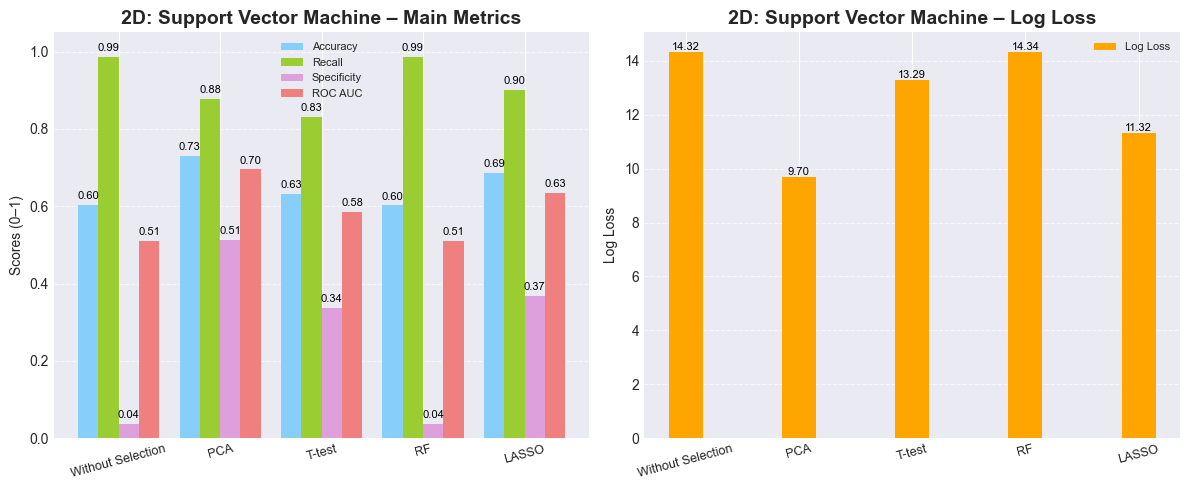

In [601]:
plot_scores(results_svm_2d, "2D: Support Vector Machine")

Dado que a estrutura de código utilizada para os diferentes modelos é idêntica, não se justifica a repetição de comentários linha a linha. As variações entre blocos prendem-se apenas com o tipo de modelo ou método de seleção de *features* aplicado.

## Random Forest - 2D

### Random Forest Sem Seleção de Features

In [602]:
data_all_2d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               145.0   
2608       4            1        5                               241.0   
2609       3            1        5                               238.0   
2610       2            1        1                               145.0   
2611       2            1        5                               245.0   

      original_shape2D_Elongation  ...  \
0                        0.780478  ...   
1                        0.875037  ...   
2                        0.837449  ...   
3                        0.784334  ...   
4                        0.883528  ...   
...                           ...  ...   
2607                     0.834938  ...   
2608                     0.561402  ...   
2609                     0.798296  ...   
2610                     0.848707  ...   
2611                     0.650249  ...   

      original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          4.333346   
1                                          0.000111   
2                                          2.000082   
3                                          0.000918   
4                                          0.000517   
...                                             ...   
2607                                       9.500713   
2608                                       0.000098   
2609                                       0.000160   
2610                                       2.250080   
2611                                       0.002268   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.120383   
1                                         0.000111   
2                                         0.125082   
3                                         0.000918   
4                                         0.000517   
...                                            ...   
2607                                      0.067842   
2608                                      0.000098   
2609                                      0.000160   
2610                                      0.375080   
2611                                      0.002268   

      original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
0                   1.584963e+00                       0.018293   
1                  -3.203427e-16                       0.010526   
2                   1.000000e+00                       0.025316   
3                  -3.203427e-16                       0.030303   
4                  -3.203427e-16                      

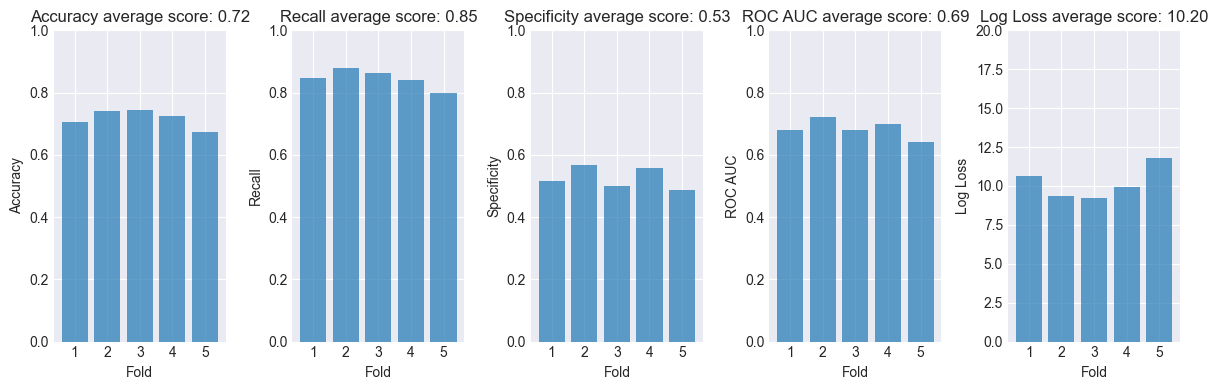

[0.7170706870911262, 0.8458450067660447, 0.5252414527804566, 0.6855432297732506, 10.197806088108516]


In [709]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = random_forest_kfold(folds_all_2d)
th_rf_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)


### Random Forest + PCA

In [604]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     2.940010  18.430755  6.971970 -5.305699  2.359204  0.910508  8.332709   
1    -1.986601   7.594077  6.591035  1.996285 -1.000592  0.719544 -1.469020   
2     2.020623   8.222577  1.119425 -2.603072 -1.804638  2.141331  5.740737   
3    -1.983425  -0.821853  0.377891  0.729857 -0.151230 -1.585481  0.588032   
4    -1.951841   0.655908  1.338934  1.223112 -1.435798 -0.754853 -0.034606   
...        ...        ...       ...       ...       ...       ...       ...   
2607  7.250143   4.883816 -3.318700 -2.649773  1.169158 -0.393980  0.796710   
2608 -1.827461   7.835941  6.416450  0.372486  2.487625 -1.696200 -1.171867   
2609 -1.832153   4.994345  4.326983  0.619211  1.211798 -1.881902 -0.668762   
2610  4.413054   6.097318 -2.943503 -1.731531 -1.789203  0.983187  3.928351   
2611 -2.274648  -2.063480 -0.266352 -0.109914  0.192440  1.230530 -0.622005   

           PC7       PC8       PC9  ...      PC12      PC13      PC14  \
0     2.336693 -2.915547  0.017969  ... -0.756161  1.981433 -5.861229   
1    -2.647705  1.424797 -2.969977  ...  1.293172  0.739599  1.027169   
2    -1.366194 -1.168388 -4.157199  ...  0.608553  1.128979 -1.873654   
3    -0.464691 -0.329500  0.748224  ... -0.071724  0.414916  0.264112   
4     0.208923 -0.082535 -0.266395  ... -0.394195  0.251880  0.272272   
...        ...       ...       ...  ...       ...       ...       ...   
2607  0.139595 -4.568912  2.072729  ...  4.636215 -8.181715  8.048030   
2608  0.578392  1.075440  0.815441  ... -1.240422 -0.711455  0.434569   
2609  0.885214  0.610669 -0.603051  ...  0.186584 -0.564258  0.267869   
2610 -2.399115 -0.647537 -4.097041  ...  1.315425 -1.990781 -1.120333   
2611 -0.668275 -0.055742 -0.043713  ... -0.918736 -0.799118  0.096911   

          PC15      PC16      PC17      PC18      PC19      PC20      PC21  
0     5.753884 -2.144556  1.532330 -1.172926  5.587918 -2.286055  1.929889  
1    -0.545074  0.036286  0.262718  0.634654 -0.139583  0.431204  0.283702  
2     2.122376 -0.794198  0.584232  1.454060 -0.437333 -0.499048  0.014856  
3     0.357385  0.327355  0.225480  0.253487 -0.078950  0.075219  0.897225  
4    -0.154137  0.396402 -0.259846 -1.228032 -0.490167  0.246650  0.409252  
...        ...       ...       ...       ...       ...       ...       ...  
2607  7.926626  2.526727 -5.147892  0.756594  0.728031 -4.034499  0.548797  
2608 -1.253925  0.200226 -0.320893  0.193077 -0.249144  0.459411  0.146271  
2609 -0.729283  0.205014 -0.080115 -0.223995 -0.817165  0.380958  0.953935  
2610  0.793302 -1.287269 -0.969464  0.947751 -0.520690  2.901461 -0.437681  
2611 -0.454650 -0.123594  0.232184  0.821024 -0.054793 -0.111634  0.866164  

[2612 rows x 22 columns]

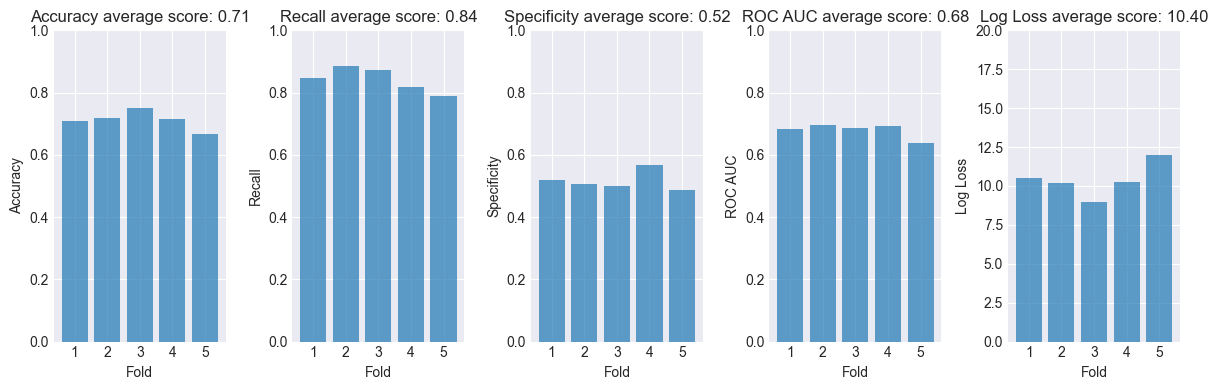

[0.7113316190852947, 0.8430142869392995, 0.5159816115013085, 0.679497949220304, 10.404663066087274]


In [710]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = random_forest_kfold(fold_pca_2d)
th_rf_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)


### Random Forest + t-test

In [606]:
data_ttest_2d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape2D_Sphericity  original_gldm_DependenceNonUniformity  \
0                        0.116476                             110.097561   
1                        0.140517                              95.000000   
2                        0.154282                              69.430380   
3                        0.237705                              33.000000   
4                        0.191705                              44.000000   
...                           ...                                    ...   
2607                     0.178190                              24.346154   
2608                     0.138573                              66.584158   
2609                     0.154955                              61.531646   
2610                     0.167193                              46.118644   
2611                     0.276215                              17.380952   

      original_glrlm_GrayLevelNonUniformity  \
0                                113.551582   
1                                 71.250000   
2                                 57.533811   
3                                 24.750000   
4                                 33.000000   
...                                     ...   
2607                              30.577463   
2608                              73.000000   
2609                              58.000000   
2610                              41.178608   
2611                              15.500000   

      original_gldm_GrayLevelNonUniformity  Subtlety  \
0                               160.036585         5   
1                                95.000000         2   
2                                77.025316         1   
3                                33.000000         5   
4                                44.000000         4   
...                                    ...       ...   
2607                             42.692308         5   
2608                            101.000000         5   
2609                             79.000000         5   
2610                             55.135593         1   
2611                             21.000000         4   

      original_shape2D_MajorAxisLength  ...  original_firstorder_Uniformity  \
0                            57.542760  ...                        0.975833   
1                            47.916558  ...                        1.000000   
2                            38.992455  ...                        0.975004   
3                            17.090541  ...                        1.000000   
4                            23.317369  ...                        1.000000   
...                                ...  ...                             ...   
2607                         26.398245  ...                        0.821006   
2608                         51.164214  ...                        1.000000   
2609                         41.452617  ...                        1.000000   
2610                         29.974686  ...                        0.934502   
2611                         12.494295  ...                        1.000000   

      original_glrlm_GrayLevelNonUniformityNormalized  original_glcm_Idmn  \
0                                            0.966060            0.996393   
1                                            1.000000            1.000000   
2 

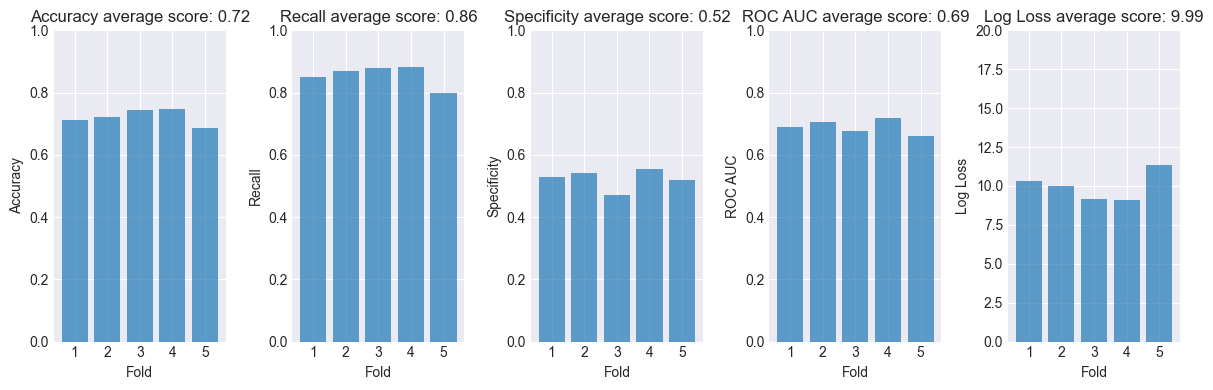

[0.722821476451067, 0.8563403347186341, 0.5226414086862172, 0.6894908717024256, 9.990526629704984]


In [711]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = random_forest_kfold(fold_ttest_2d)
th_rf_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)


### Random Forest + Random Forest (seleção de features)

In [608]:
data_randomforest_2d

Calcification  Subtlety  Lobulation  original_glrlm_RunVariance  \
0                 6         5           3                    1.047323   
1                 6         2           1                    1.643268   
2                 6         1           1                    1.043018   
3                 6         5           2                    0.568899   
4                 6         4           1                    0.825773   
...             ...       ...         ...                         ...   
2607              6         5           1                    0.823009   
2608              6         5           3                    1.032997   
2609              6         5           1                    0.851907   
2610              6         1           1                    0.814518   
2611              6         4           1                    1.251456   

      original_shape2D_Elongation  original_shape2D_MinorAxisLength  \
0                        0.780478                         44.910854   
1                        0.875037                         41.928777   
2                        0.837449                         32.654203   
3                        0.784334                         13.404688   
4                        0.883528                         20.601559   
...                           ...                               ...   
2607                     0.834938                         22.040900   
2608                     0.561402                         28.723704   
2609                     0.798296                         33.091465   
2610                     0.848707                         25.439728   
2611                     0.650249                          8.124406   

      original_glrlm_RunEntropy  original_shape2D_MajorAxisLength  \
0                      1.219781                         57.542760   
1                      0.826420                         47.916558   
2                      0.970033                         38.992455   
3                      0.988827                         17.090541   
4                      0.908444                         23.317369   
...                         ...                               ...   
2607                   1.548634                         26.398245   
2608                   1.069352                         51.164214   
2609                   1.040736                         41.452617   
2610                   1.079397                         29.974686   
2611                   0.798053                         12.494295   

      original_glrlm_RunLengthNonUniformityNormalized  \
0                                            0.631195   
1                                            0.740597   
2                                            0.727648   
3                                            0.640797   
4                                            0.704450   
...                                               ...   
2607                                         0.700111   
2608                                         0.648934   
2609                                         0.633376   
2610                                         0.723452   
2611                                         0.711481   

      original_glrlm_RunLengthNonUniformity  ...  original_glcm_Correlation  \
0                                 74.650278  ...                   0.491907   
1                                 52.906634  ...                   1.000000   
2                                 43.422151  ...                   0.488140   
3                                 16.060043  ...                   1.000000   
4                                 23.279412  ...                   1.000000   
...                                     ...  ...                        ...   
2607                              27.752206  ...                   0.506889   
2608                              48.369202  ...                   1.000000   
2609                              37.118338  ...   

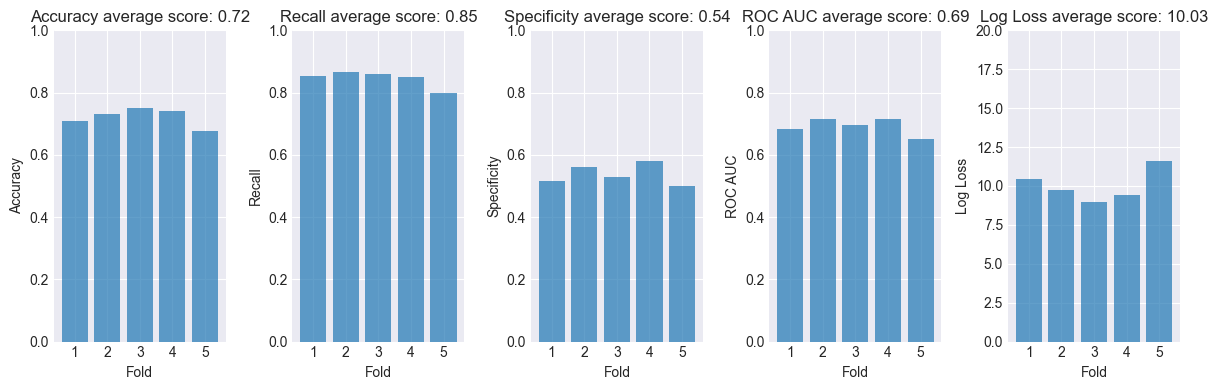

[0.721670585994447, 0.845802688232431, 0.5376783886400592, 0.6917405384362451, 10.032008926412242]


In [712]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = random_forest_kfold(fold_randomforest_2d)
th_rf_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)


### Random Forest + LASSO

In [610]:
data_lasso_2d

InternalStructure  Calcification  Subtlety  Lobulation  Margin  \
0                     1              6         5           3       4   
1                     1              6         2           1       1   
2                     1              6         1           1       2   
3                     1              6         5           2       3   
4                     1              6         4           1       4   
...                 ...            ...       ...         ...     ...   
2607                  4              6         5           1       4   
2608                  1              6         5           3       4   
2609                  1              6         5           1       3   
2610                  1              6         1           1       2   
2611                  1              6         4           1       2   

      Spiculation  Texture  diagnostics_Image-original_Maximum  \
0               5        5                               400.0   
1               1        1                               400.0   
2               1        1                               400.0   
3               2        4                               400.0   
4               1        5                               400.0   
...           ...      ...                                 ...   
2607            5        4                               145.0   
2608            1        5                               241.0   
2609            1        5                               238.0   
2610            1        1                               145.0   
2611            1        5                               245.0   

      original_shape2D_Elongation  original_shape2D_PerimeterSurfaceRatio  \
0                        0.780478                                2.595471   
1                        0.875037                                2.884337   
2                        0.837449                                2.883393   
3                        0.784334                                2.896964   
4                        0.883528                                3.218951   
...                           ...                                     ...   
2607                     0.834938                                3.206197   
2608                     0.561402                                2.851203   
2609                     0.798296                                2.882234   
2610                     0.848707                                3.178396   
2611                     0.650249                                3.259801   

      original_shape2D_Sphericity  original_firstorder_10Percentile  \
0                        0.116476                           -1000.0   
1                        0.140517                           -1000.0   
2                        0.154282                           -1000.0   
3                        0.237705                           -1000.0   
4                        0.191705                           -1000.0   
...                           ...                               ...   
2607                     0.178190                           -1000.0   
2608                     0.138573                           -1000.0   
2609                     0.154955                           -1000.0   
2610                     0.167193                           -1000.0   
2611                     0.276215                           -1000.0   

      original_firstorder_Kurtosis  original_firstorder_Minimum  \
0                       113.421045                      -1000.0   
1                         0.000000                      -1000.0   
2                        77.012821                      -1000.0   
3                         0.000000                      -1000.0   
4                         0.000000                      -1000.0   
...                            ...                          ...   
2607                     20.701325                      -1000.0   
2608                      0.000000

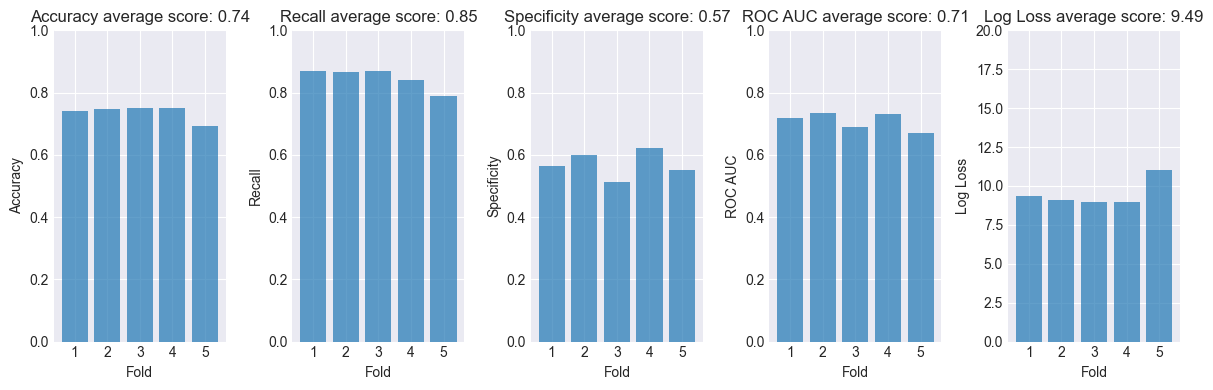

[0.7365948001142832, 0.8469604260149455, 0.5705302608012878, 0.7087453434081167, 9.494085725571896]


In [713]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = random_forest_kfold(folds_lasso_2d)
th_rf_2d.append([accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d,recalls_2d,specifities_2d,roc_aucs_2d,log_losses_2d)
print(average_metrics_2d)
results_rf_2d.append(average_metrics_2d)


### Resultados Random Forest - 2d

In [612]:

print(results_rf_2d)

[[0.7170706870911262, 0.8458450067660447, 0.5252414527804566, 0.6855432297732506, 10.197806088108516], [0.7113316190852947, 0.8430142869392995, 0.5159816115013085, 0.679497949220304, 10.404663066087274], [0.722821476451067, 0.8563403347186341, 0.5226414086862172, 0.6894908717024256, 9.990526629704984], [0.721670585994447, 0.845802688232431, 0.5376783886400592, 0.6917405384362451, 10.032008926412242], [0.7365948001142832, 0.8469604260149455, 0.5705302608012878, 0.7087453434081167, 9.494085725571896]]


In [714]:
print("Número de abordagens:", len(results_rf_2d))
for i, result in enumerate(results_rf_2d):
    print(f"{i+1}: {result}")

Número de abordagens: 5
1: [0.7170706870911262, 0.8458450067660447, 0.5252414527804566, 0.6855432297732506, 10.197806088108516]
2: [0.7113316190852947, 0.8430142869392995, 0.5159816115013085, 0.679497949220304, 10.404663066087274]
3: [0.722821476451067, 0.8563403347186341, 0.5226414086862172, 0.6894908717024256, 9.990526629704984]
4: [0.721670585994447, 0.845802688232431, 0.5376783886400592, 0.6917405384362451, 10.032008926412242]
5: [0.7365948001142832, 0.8469604260149455, 0.5705302608012878, 0.7087453434081167, 9.494085725571896]


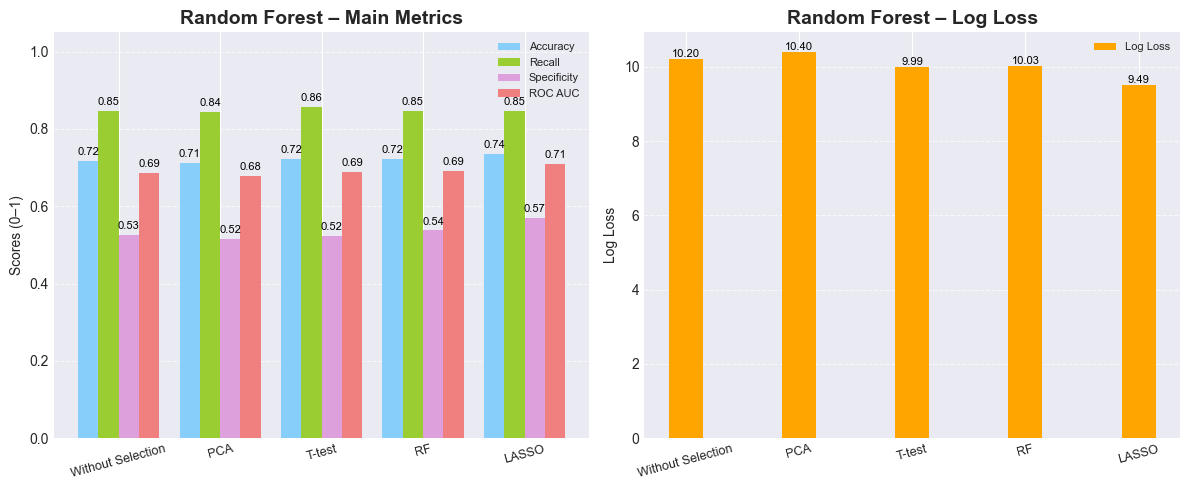

In [614]:
plot_scores(results_rf_2d, "Random Forest")

## XGBOOST - 2D

### XGBoost Sem Seleção de Features

In [615]:
data_all_2d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               145.0   
2608       4            1        5                               241.0   
2609       3            1        5                               238.0   
2610       2            1        1                               145.0   
2611       2            1        5                               245.0   

      original_shape2D_Elongation  ...  \
0                        0.780478  ...   
1                        0.875037  ...   
2                        0.837449  ...   
3                        0.784334  ...   
4                        0.883528  ...   
...                           ...  ...   
2607                     0.834938  ...   
2608                     0.561402  ...   
2609                     0.798296  ...   
2610                     0.848707  ...   
2611                     0.650249  ...   

      original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                                          4.333346   
1                                          0.000111   
2                                          2.000082   
3                                          0.000918   
4                                          0.000517   
...                                             ...   
2607                                       9.500713   
2608                                       0.000098   
2609                                       0.000160   
2610                                       2.250080   
2611                                       0.002268   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.120383   
1                                         0.000111   
2                                         0.125082   
3                                         0.000918   
4                                         0.000517   
...                                            ...   
2607                                      0.067842   
2608                                      0.000098   
2609                                      0.000160   
2610                                      0.375080   
2611                                      0.002268   

      original_glszm_ZoneEntropy  original_glszm_ZonePercentage  \
0                   1.584963e+00                       0.018293   
1                  -3.203427e-16                       0.010526   
2                   1.000000e+00                       0.025316   
3                  -3.203427e-16                       0.030303   
4                  -3.203427e-16                      

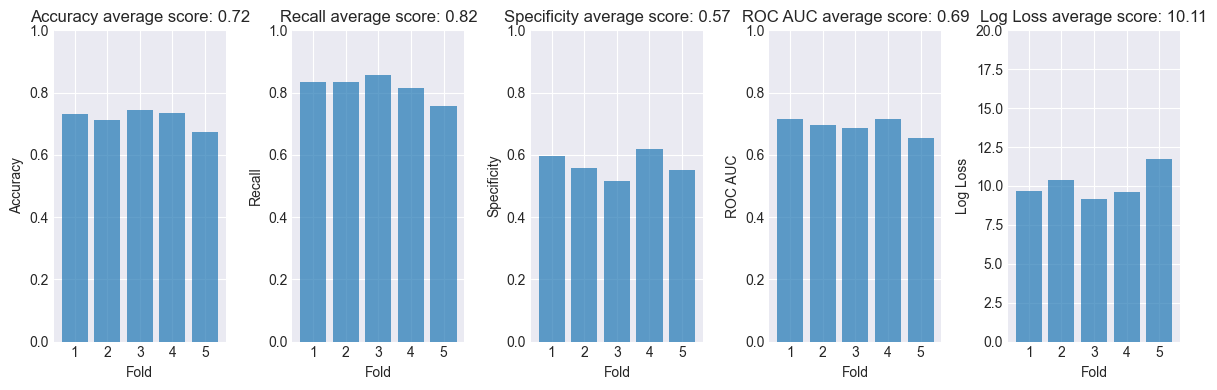

[0.7193702702504706, 0.8194711425565832, 0.5684571548595277, 0.6939641487080553, 10.114920709773653]


In [715]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = xgboost_k_fold(folds_all_2d)
th_xgb_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

### XGBoost + PCA

In [617]:
data_pca_2d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0     2.940010  18.430755  6.971970 -5.305699  2.359204  0.910508  8.332709   
1    -1.986601   7.594077  6.591035  1.996285 -1.000592  0.719544 -1.469020   
2     2.020623   8.222577  1.119425 -2.603072 -1.804638  2.141331  5.740737   
3    -1.983425  -0.821853  0.377891  0.729857 -0.151230 -1.585481  0.588032   
4    -1.951841   0.655908  1.338934  1.223112 -1.435798 -0.754853 -0.034606   
...        ...        ...       ...       ...       ...       ...       ...   
2607  7.250143   4.883816 -3.318700 -2.649773  1.169158 -0.393980  0.796710   
2608 -1.827461   7.835941  6.416450  0.372486  2.487625 -1.696200 -1.171867   
2609 -1.832153   4.994345  4.326983  0.619211  1.211798 -1.881902 -0.668762   
2610  4.413054   6.097318 -2.943503 -1.731531 -1.789203  0.983187  3.928351   
2611 -2.274648  -2.063480 -0.266352 -0.109914  0.192440  1.230530 -0.622005   

           PC7       PC8       PC9  ...      PC12      PC13      PC14  \
0     2.336693 -2.915547  0.017969  ... -0.756161  1.981433 -5.861229   
1    -2.647705  1.424797 -2.969977  ...  1.293172  0.739599  1.027169   
2    -1.366194 -1.168388 -4.157199  ...  0.608553  1.128979 -1.873654   
3    -0.464691 -0.329500  0.748224  ... -0.071724  0.414916  0.264112   
4     0.208923 -0.082535 -0.266395  ... -0.394195  0.251880  0.272272   
...        ...       ...       ...  ...       ...       ...       ...   
2607  0.139595 -4.568912  2.072729  ...  4.636215 -8.181715  8.048030   
2608  0.578392  1.075440  0.815441  ... -1.240422 -0.711455  0.434569   
2609  0.885214  0.610669 -0.603051  ...  0.186584 -0.564258  0.267869   
2610 -2.399115 -0.647537 -4.097041  ...  1.315425 -1.990781 -1.120333   
2611 -0.668275 -0.055742 -0.043713  ... -0.918736 -0.799118  0.096911   

          PC15      PC16      PC17      PC18      PC19      PC20      PC21  
0     5.753884 -2.144556  1.532330 -1.172926  5.587918 -2.286055  1.929889  
1    -0.545074  0.036286  0.262718  0.634654 -0.139583  0.431204  0.283702  
2     2.122376 -0.794198  0.584232  1.454060 -0.437333 -0.499048  0.014856  
3     0.357385  0.327355  0.225480  0.253487 -0.078950  0.075219  0.897225  
4    -0.154137  0.396402 -0.259846 -1.228032 -0.490167  0.246650  0.409252  
...        ...       ...       ...       ...       ...       ...       ...  
2607  7.926626  2.526727 -5.147892  0.756594  0.728031 -4.034499  0.548797  
2608 -1.253925  0.200226 -0.320893  0.193077 -0.249144  0.459411  0.146271  
2609 -0.729283  0.205014 -0.080115 -0.223995 -0.817165  0.380958  0.953935  
2610  0.793302 -1.287269 -0.969464  0.947751 -0.520690  2.901461 -0.437681  
2611 -0.454650 -0.123594  0.232184  0.821024 -0.054793 -0.111634  0.866164  

[2612 rows x 22 columns]

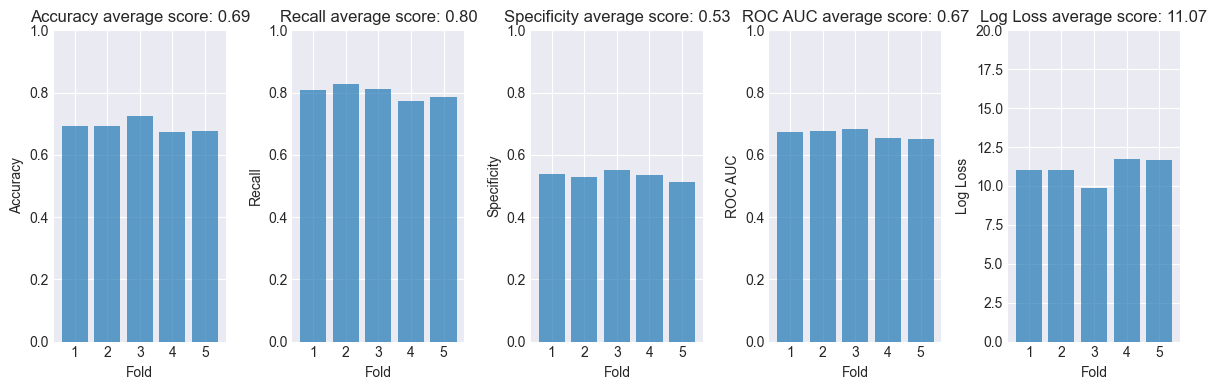

[0.6929547335955987, 0.801619704640542, 0.5334747666716427, 0.6675472356560924, 11.06703315704938]


In [716]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = xgboost_k_fold(fold_pca_2d)
th_xgb_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

### XGBoost + t-test

In [619]:
data_ttest_2d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape2D_Sphericity  original_gldm_DependenceNonUniformity  \
0                        0.116476                             110.097561   
1                        0.140517                              95.000000   
2                        0.154282                              69.430380   
3                        0.237705                              33.000000   
4                        0.191705                              44.000000   
...                           ...                                    ...   
2607                     0.178190                              24.346154   
2608                     0.138573                              66.584158   
2609                     0.154955                              61.531646   
2610                     0.167193                              46.118644   
2611                     0.276215                              17.380952   

      original_glrlm_GrayLevelNonUniformity  \
0                                113.551582   
1                                 71.250000   
2                                 57.533811   
3                                 24.750000   
4                                 33.000000   
...                                     ...   
2607                              30.577463   
2608                              73.000000   
2609                              58.000000   
2610                              41.178608   
2611                              15.500000   

      original_gldm_GrayLevelNonUniformity  Subtlety  \
0                               160.036585         5   
1                                95.000000         2   
2                                77.025316         1   
3                                33.000000         5   
4                                44.000000         4   
...                                    ...       ...   
2607                             42.692308         5   
2608                            101.000000         5   
2609                             79.000000         5   
2610                             55.135593         1   
2611                             21.000000         4   

      original_shape2D_MajorAxisLength  ...  original_firstorder_Uniformity  \
0                            57.542760  ...                        0.975833   
1                            47.916558  ...                        1.000000   
2                            38.992455  ...                        0.975004   
3                            17.090541  ...                        1.000000   
4                            23.317369  ...                        1.000000   
...                                ...  ...                             ...   
2607                         26.398245  ...                        0.821006   
2608                         51.164214  ...                        1.000000   
2609                         41.452617  ...                        1.000000   
2610                         29.974686  ...                        0.934502   
2611                         12.494295  ...                        1.000000   

      original_glrlm_GrayLevelNonUniformityNormalized  original_glcm_Idmn  \
0                                            0.966060            0.996393   
1                                            1.000000            1.000000   
2 

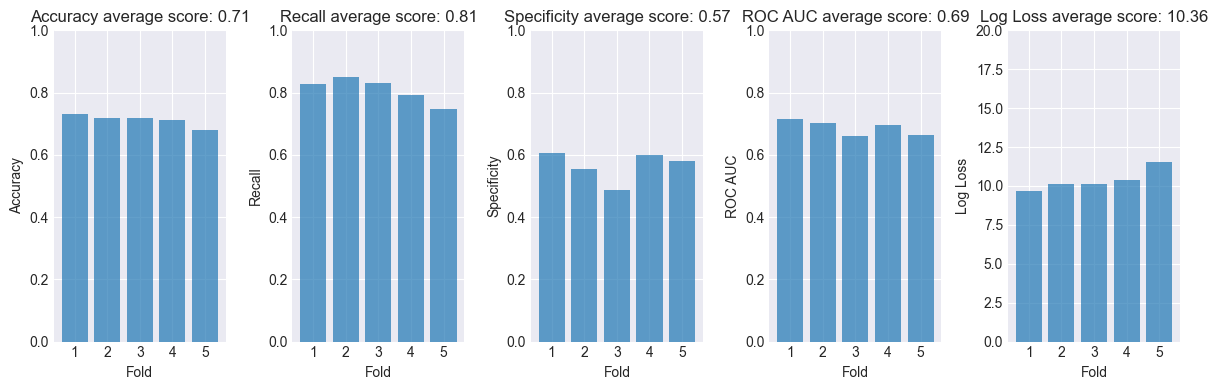

[0.7124707881878054, 0.8099474834851745, 0.5655180013714698, 0.6877327424283222, 10.363603249804793]


In [717]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = xgboost_k_fold(fold_ttest_2d)
th_xgb_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

### XGBoost + Random Forest (seleção de features)

In [621]:
data_randomforest_2d

Calcification  Subtlety  Lobulation  original_glrlm_RunVariance  \
0                 6         5           3                    1.047323   
1                 6         2           1                    1.643268   
2                 6         1           1                    1.043018   
3                 6         5           2                    0.568899   
4                 6         4           1                    0.825773   
...             ...       ...         ...                         ...   
2607              6         5           1                    0.823009   
2608              6         5           3                    1.032997   
2609              6         5           1                    0.851907   
2610              6         1           1                    0.814518   
2611              6         4           1                    1.251456   

      original_shape2D_Elongation  original_shape2D_MinorAxisLength  \
0                        0.780478                         44.910854   
1                        0.875037                         41.928777   
2                        0.837449                         32.654203   
3                        0.784334                         13.404688   
4                        0.883528                         20.601559   
...                           ...                               ...   
2607                     0.834938                         22.040900   
2608                     0.561402                         28.723704   
2609                     0.798296                         33.091465   
2610                     0.848707                         25.439728   
2611                     0.650249                          8.124406   

      original_glrlm_RunEntropy  original_shape2D_MajorAxisLength  \
0                      1.219781                         57.542760   
1                      0.826420                         47.916558   
2                      0.970033                         38.992455   
3                      0.988827                         17.090541   
4                      0.908444                         23.317369   
...                         ...                               ...   
2607                   1.548634                         26.398245   
2608                   1.069352                         51.164214   
2609                   1.040736                         41.452617   
2610                   1.079397                         29.974686   
2611                   0.798053                         12.494295   

      original_glrlm_RunLengthNonUniformityNormalized  \
0                                            0.631195   
1                                            0.740597   
2                                            0.727648   
3                                            0.640797   
4                                            0.704450   
...                                               ...   
2607                                         0.700111   
2608                                         0.648934   
2609                                         0.633376   
2610                                         0.723452   
2611                                         0.711481   

      original_glrlm_RunLengthNonUniformity  ...  original_glcm_Correlation  \
0                                 74.650278  ...                   0.491907   
1                                 52.906634  ...                   1.000000   
2                                 43.422151  ...                   0.488140   
3                                 16.060043  ...                   1.000000   
4                                 23.279412  ...                   1.000000   
...                                     ...  ...                        ...   
2607                              27.752206  ...                   0.506889   
2608                              48.369202  ...                   1.000000   
2609                              37.118338  ...   

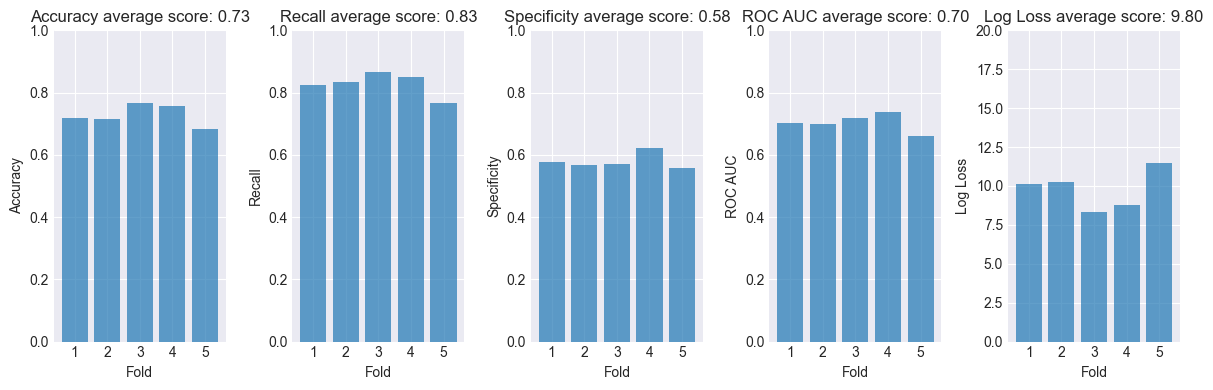

[0.7281861937100284, 0.8282870359203383, 0.5789251941743888, 0.7036061150473634, 9.797162620292369]


In [718]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = xgboost_k_fold(fold_randomforest_2d)
th_xgb_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

### XGBoost + LASSO

In [623]:
data_lasso_2d

InternalStructure  Calcification  Subtlety  Lobulation  Margin  \
0                     1              6         5           3       4   
1                     1              6         2           1       1   
2                     1              6         1           1       2   
3                     1              6         5           2       3   
4                     1              6         4           1       4   
...                 ...            ...       ...         ...     ...   
2607                  4              6         5           1       4   
2608                  1              6         5           3       4   
2609                  1              6         5           1       3   
2610                  1              6         1           1       2   
2611                  1              6         4           1       2   

      Spiculation  Texture  diagnostics_Image-original_Maximum  \
0               5        5                               400.0   
1               1        1                               400.0   
2               1        1                               400.0   
3               2        4                               400.0   
4               1        5                               400.0   
...           ...      ...                                 ...   
2607            5        4                               145.0   
2608            1        5                               241.0   
2609            1        5                               238.0   
2610            1        1                               145.0   
2611            1        5                               245.0   

      original_shape2D_Elongation  original_shape2D_PerimeterSurfaceRatio  \
0                        0.780478                                2.595471   
1                        0.875037                                2.884337   
2                        0.837449                                2.883393   
3                        0.784334                                2.896964   
4                        0.883528                                3.218951   
...                           ...                                     ...   
2607                     0.834938                                3.206197   
2608                     0.561402                                2.851203   
2609                     0.798296                                2.882234   
2610                     0.848707                                3.178396   
2611                     0.650249                                3.259801   

      original_shape2D_Sphericity  original_firstorder_10Percentile  \
0                        0.116476                           -1000.0   
1                        0.140517                           -1000.0   
2                        0.154282                           -1000.0   
3                        0.237705                           -1000.0   
4                        0.191705                           -1000.0   
...                           ...                               ...   
2607                     0.178190                           -1000.0   
2608                     0.138573                           -1000.0   
2609                     0.154955                           -1000.0   
2610                     0.167193                           -1000.0   
2611                     0.276215                           -1000.0   

      original_firstorder_Kurtosis  original_firstorder_Minimum  \
0                       113.421045                      -1000.0   
1                         0.000000                      -1000.0   
2                        77.012821                      -1000.0   
3                         0.000000                      -1000.0   
4                         0.000000                      -1000.0   
...                            ...                          ...   
2607                     20.701325                      -1000.0   
2608                      0.000000

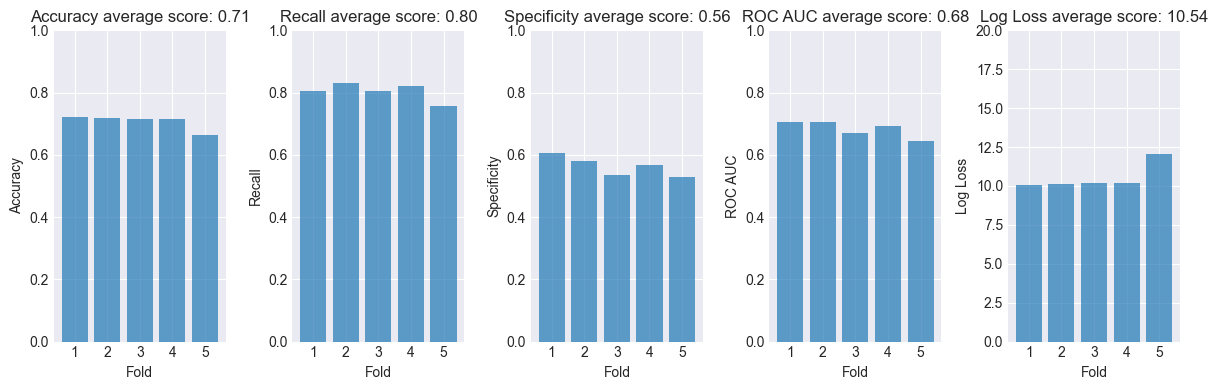

[0.7074943407837191, 0.804465371361213, 0.5630815551475971, 0.6837734632544048, 10.54297259514685]


In [719]:
accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d = xgboost_k_fold(folds_lasso_2d)
th_xgb_2d.append([accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d])
average_metrics_2d = plot_metrics(accuracies_2d, recalls_2d, specifities_2d, roc_aucs_2d, log_losses_2d)
print(average_metrics_2d)
results_xgb_2d.append(average_metrics_2d)

### Resultados XGBoost - 2d

In [625]:

print(results_xgb_2d)

[[0.7193702702504706, 0.8194711425565832, 0.5684571548595277, 0.6939641487080553, 10.114920709773653], [0.6929547335955987, 0.801619704640542, 0.5334747666716427, 0.6675472356560924, 11.06703315704938], [0.7124707881878054, 0.8099474834851745, 0.5655180013714698, 0.6877327424283222, 10.363603249804793], [0.7281861937100284, 0.8282870359203383, 0.5789251941743888, 0.7036061150473634, 9.797162620292369], [0.7074943407837191, 0.804465371361213, 0.5630815551475971, 0.6837734632544048, 10.54297259514685]]


In [720]:
print("Número de abordagens:", len(results_xgb_2d))
for i, result in enumerate(results_xgb_2d):
    print(f"{i+1}: {result}")

Número de abordagens: 5
1: [0.7193702702504706, 0.8194711425565832, 0.5684571548595277, 0.6939641487080553, 10.114920709773653]
2: [0.6929547335955987, 0.801619704640542, 0.5334747666716427, 0.6675472356560924, 11.06703315704938]
3: [0.7124707881878054, 0.8099474834851745, 0.5655180013714698, 0.6877327424283222, 10.363603249804793]
4: [0.7281861937100284, 0.8282870359203383, 0.5789251941743888, 0.7036061150473634, 9.797162620292369]
5: [0.7074943407837191, 0.804465371361213, 0.5630815551475971, 0.6837734632544048, 10.54297259514685]


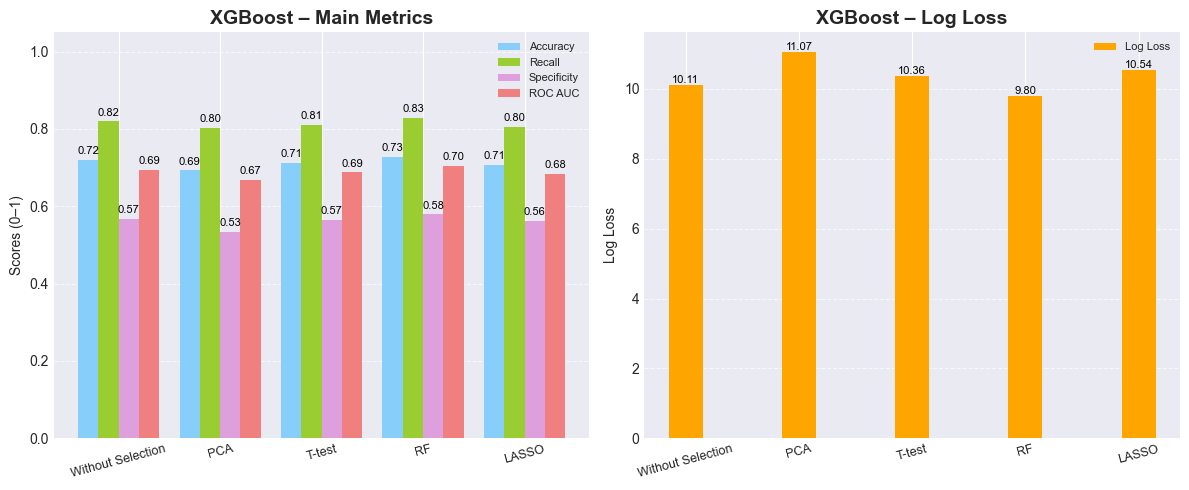

In [627]:

plot_scores(results_xgb_2d, "XGBoost")

## SVM - 3D

### Support Vector Machine Se, Seleção de Features

In [628]:
data_all_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               400.0   
2608       4            1        5                               400.0   
2609       3            1        5                               400.0   
2610       2            1        1                               400.0   
2611       2            1        5                               400.0   

      original_shape_Elongation  ...  original_glrlm_RunVariance  \
0                      0.933047  ...                    0.520519   
1                      0.785904  ...                    0.545514   
2                      0.835582  ...                    0.540904   
3                      0.713714  ...                    0.364716   
4                      0.945512  ...                    0.449092   
...                         ...  ...                         ...   
2607                   0.806955  ...                    0.432866   
2608                   0.561097  ...                    0.433158   
2609                   0.790535  ...                    0.566699   
2610                   0.878163  ...                    0.411385   
2611                   0.828939  ...                    0.336309   

      original_glrlm_ShortRunEmphasis  \
0                            0.876955   
1                            0.863305   
2                            0.876231   
3                            0.878266   
4                            0.879559   
...                               ...   
2607                         0.891968   
2608                         0.864611   
2609                         0.861718   
2610                         0.887794   
2611                         0.927437   

      original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                         0.912478   
1                                         3.358479   
2                                         0.981826   
3                                         0.878266   
4                                         0.879559   
...                                            ...   
2607                                      1.542134   
2608                                      0.864611   
2609                                      0.861718   
2610                                      1.011445   
2611                                      0.927437   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=67.597762365065, gamma=0.1124767733274446


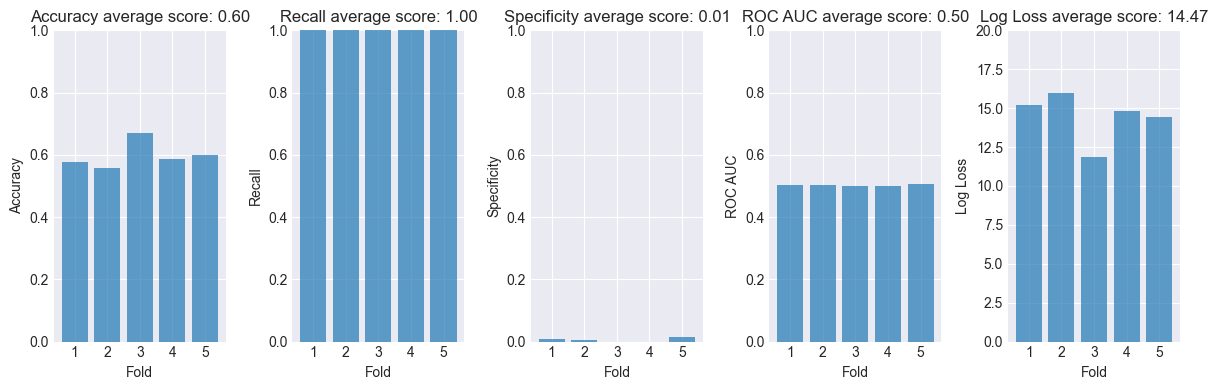

[0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114]


In [629]:

accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = svm_k_fold(fold_all_3d)
th_svm_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

### Support Vector Machine + PCA

In [630]:
data_pca_3d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0    -1.278067   9.576904 -1.156507  3.757274 -1.615755 -3.860658 -1.097963   
1    -6.446833  13.619389 -3.613062  0.596606 -2.112019 -0.131476 -1.602061   
2    -0.996221   5.733703  0.031564  2.192263 -2.008760 -3.745283  0.056094   
3     2.203329  -1.096471  0.069448  2.726237  0.137445  0.199358 -0.468743   
4     2.113985  -0.136765 -0.356323  2.454730  0.104751  0.309677 -0.594976   
...        ...        ...       ...       ...       ...       ...       ...   
2607 -5.297076   2.860926  4.356948  2.181465 -1.113462 -0.902548 -0.763268   
2608  1.107153   5.528833 -2.353303  4.048105  0.710450  0.830768 -1.735930   
2609  1.557863   3.749841 -2.025833  2.536779  0.565856  0.668404 -1.483379   
2610 -0.981719   3.371373  1.978289  2.922428 -1.974097 -3.661183  0.200367   
2611  2.216879  -1.944034  0.831802  4.757672 -0.218913  0.312784  0.211815   

           PC7       PC8       PC9  ...      PC13      PC14       PC15  \
0     0.430526  1.950767 -0.486700  ...  1.429148  0.091078  -0.486037   
1    -2.048227 -4.508803 -1.437513  ...  1.605232 -0.481154   1.909910   
2    -2.082406 -3.410250  1.629019  ...  1.256107 -0.167175  -0.215375   
3    -0.203385  0.871312 -0.268072  ... -0.346194  0.011146   0.096051   
4     0.899847 -0.135164  0.450913  ...  0.609936  0.529577  -0.175882   
...        ...       ...       ...  ...       ...       ...        ...   
2607 -0.579069  2.122959  0.914349  ... -0.885684 -1.704124  13.339463   
2608  0.689661  1.794291  1.167974  ... -1.398670  0.002915   0.758514   
2609  1.044880  0.158526  1.756955  ...  0.420673  0.066838   0.350159   
2610 -2.419413 -2.747674  1.499801  ...  0.156578  0.334455  -1.066082   
2611  0.091883 -0.484289 -0.103599  ... -0.151501  0.481568  -0.306185   

          PC16      PC17      PC18      PC19      PC20      PC21      PC22  
0     0.381170 -0.210300 -0.527217 -0.658950 -0.495133 -1.122424 -0.235036  
1    -0.465967 -0.636408  0.342292 -1.850376 -1.022287  2.162197  0.509957  
2    -0.675650 -0.835954 -1.635870 -0.566318  0.133759  0.135643 -0.098179  
3    -0.277266 -0.440305 -0.274018  0.529545 -0.285955  0.179709  0.749678  
4     0.877427  0.687000  0.821011 -0.328398  0.449049 -0.672370  0.574434  
...        ...       ...       ...       ...       ...       ...       ...  
2607 -1.843934  2.795739 -0.400100  3.961215  0.882348 -1.066333 -0.489437  
2608  0.104635 -1.757344 -0.842843 -0.055677  0.057312 -1.122804  1.180295  
2609  0.338420 -0.979148  0.077650 -0.098412  0.242742 -0.963399  1.002933  
2610 -0.456464  0.526858 -1.207021 -0.362193 -1.182742 -1.125125  0.163694  
2611  0.125837  0.686246  0.485241  0.604918 -0.100905  0.884664 -0.466499  

[2612 rows x 23 columns]

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=46.8110026282228, gamma=0.004117017997814906


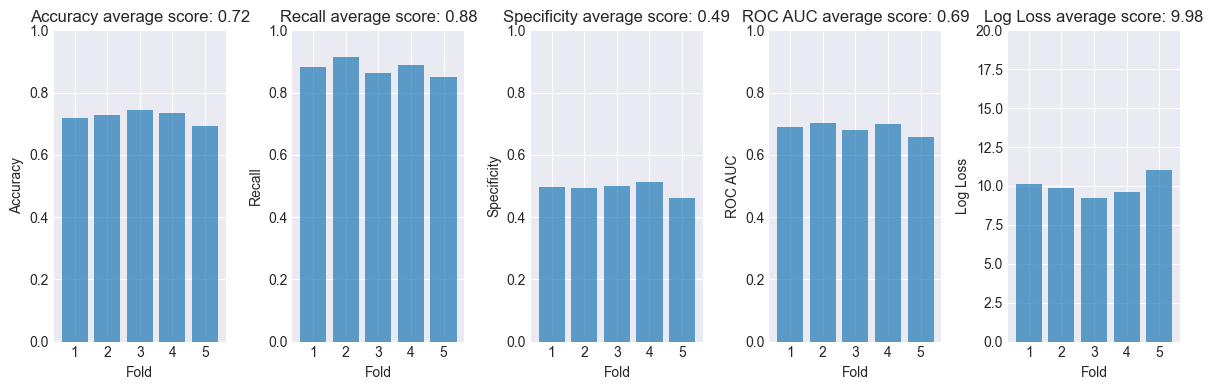

[0.72320095529036, 0.8801694594393613, 0.49304242744268584, 0.6866059434410235, 9.976848825953008]


In [631]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = svm_k_fold(fold_pca_3d)
th_svm_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

### Support Vector Machine + t-test

In [632]:
data_ttest_3d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape_Sphericity  Subtlety  \
0                      0.124353         5   
1                      0.118720         2   
2                      0.163177         1   
3                      0.247734         5   
4                      0.195385         4   
...                         ...       ...   
2607                   0.161158         5   
2608                   0.133374         5   
2609                   0.145364         5   
2610                   0.159166         1   
2611                   0.289373         4   

      original_shape_Maximum2DDiameterRow  original_shape_MinorAxisLength  \
0                               49.010203                       45.550617   
1                               47.169906                       34.257045   
2                               37.947332                       32.288129   
3                               17.262677                       12.501689   
4                               18.788294                       19.950917   
...                                   ...                             ...   
2607                            27.000000                       22.014102   
2608                            52.839379                       27.175070   
2609                            35.468296                       30.306794   
2610                            28.160256                       26.813846   
2611                            15.297059                       12.680470   

      original_shape_MajorAxisLength  original_shape_Maximum3DDiameter  ...  \
0                          48.819234                         50.019996  ...   
1                          43.589345                         53.018865  ...   
2                          38.641489                         37.947332  ...   
3                          17.516392                         17.262677  ...   
4                          21.100653                         19.000000  ...   
...                              ...                               ...  ...   
2607                       27.280467                         28.017851  ...   
2608                       48.431996                         58.677082  ...   
2609                       38.337072                         35.468296  ...   
2610                       30.534011                         28.160256  ...   
2611                       15.297228                         15.297059  ...   

      original_firstorder_Uniformity  original_glrlm_ShortRunEmphasis  \
0                           0.991510                         0.876955   
1                           0.962354                         0.863305   
2                           0.988930                         0.876231   
3                           1.000000                         0.878266   
4                           1.000000                         0.879559   
...                              ...                              ...   
2607                        0.872166                         0.891968   
2608                        1.000000                         0.864611   
2609                        1.000000                         0.861718   
2610                        0.972104                         0.887794   
2611                        1.000000                         0.927437   

      original_glrlm_LowGrayLevelRunEmpha

Stopping search: Swarm best objective change less than 1e-08
Melhores parâmetros a partir do PSO: C=75.35280076300177, gamma=0.10566628893374774


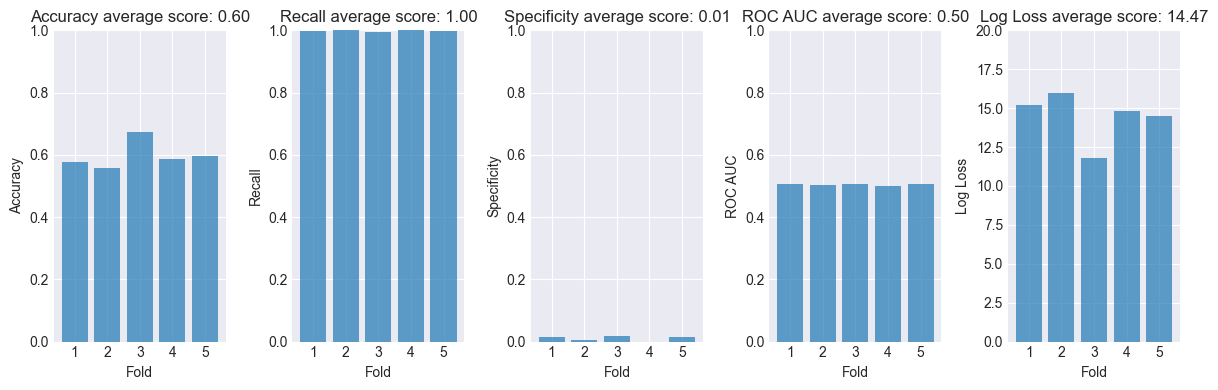

[0.5984161520259629, 0.9975453149001536, 0.009867512830622241, 0.503706413865388, 14.474549023044114]


In [634]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = svm_k_fold(fold_ttest_3d)
th_svm_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

### Support Vector Machine + Random Forest (seleção de features)

In [ ]:
data_randomforest_3d

Calcification  Lobulation  Subtlety  original_shape_MinorAxisLength  \
0                 6           3         5                       45.550617   
1                 6           1         2                       34.257045   
2                 6           1         1                       32.288129   
3                 6           2         5                       12.501689   
4                 6           1         4                       19.950917   
...             ...         ...       ...                             ...   
2607              6           1         5                       22.014102   
2608              6           3         5                       27.175070   
2609              6           1         5                       30.306794   
2610              6           1         1                       26.813846   
2611              6           1         4                       12.680470   

      original_shape_Elongation  diagnostics_Image-original_Size_x  Margin  \
0                      0.933047                              133.0       4   
1                      0.785904                              261.0       1   
2                      0.835582                              140.0       2   
3                      0.713714                              140.0       3   
4                      0.945512                              140.0       4   
...                         ...                                ...     ...   
2607                   0.806955                              133.0       4   
2608                   0.561097                              133.0       4   
2609                   0.790535                              133.0       3   
2610                   0.878163                              133.0       2   
2611                   0.828939                              166.0       2   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                        0.878266   
4                                        0.879559   
...                                           ...   
2607                                     0.828548   
2608                                     0.864611   
2609                                     0.861718   
2610                                     0.873611   
2611                                     0.927437   

      diagnostics_Mask-original_Size_x  original_shape_MajorAxisLength  ...  \
0                                133.0                       48.819234  ...   
1                                261.0                       43.589345  ...   
2                                140.0                       38.641489  ...   
3                                140.0                       17.516392  ...   
4                                140.0                       21.100653  ...   
...                                ...                             ...  ...   
2607                             133.0                       27.280467  ...   
2608                             133.0                       48.431996  ...   
2609                             133.0                       38.337072  ...   
2610                             133.0                       30.534011  ...   
2611                             166.0                       15.297228  ...   

      original_firstorder_Range  original_firstorder_RootMeanSquared  \
0                          66.0                           999.749918   
1                         596.0                           996.825952   
2                         135.0                           999.563877   
3                           0.0                          1000.000000   
4                           0.0                          1000.000000   
...                         ...                                  ...   
2607                      134.0                       

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=29.4985655850074, gamma=0.1122497954242854


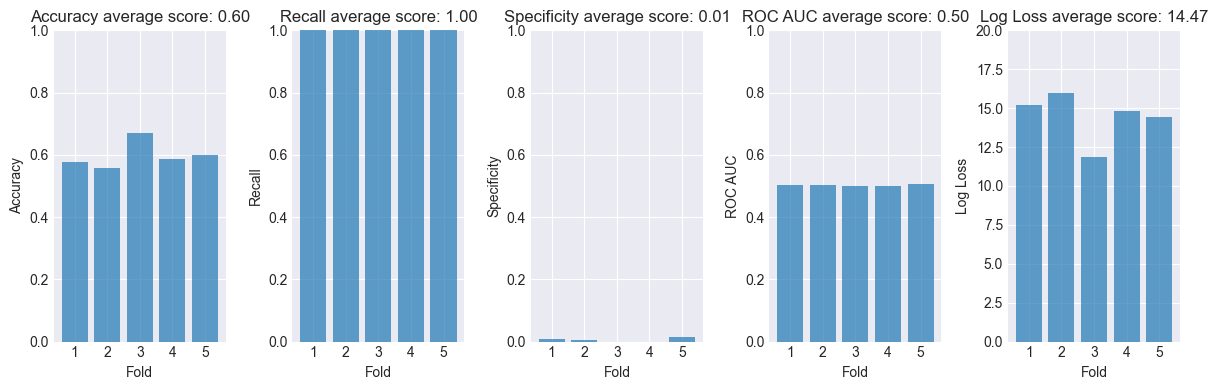

[0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114]


In [723]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = svm_k_fold(fold_randomforest_3d)
th_svm_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

### Support Vector Machine + LASSO

In [ ]:
data_lasso_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  original_shape_Elongation  \
0          4            5        5                   0.933047   
1          1            1        1                   0.785904   
2          2            1        1                   0.835582   
3          3            2        4                   0.713714   
4          4            1        5                   0.945512   
...      ...          ...      ...                        ...   
2607       4            5        4                   0.806955   
2608       4            1        5                   0.561097   
2609       3            1        5                   0.790535   
2610       2            1        1                   0.878163   
2611       2            1        5                   0.828939   

      original_shape_Sphericity  ...  \
0                      0.124353  ...   
1                      0.118720  ...   
2                      0.163177  ...   
3                      0.247734  ...   
4                      0.195385  ...   
...                         ...  ...   
2607                   0.161158  ...   
2608                   0.133374  ...   
2609                   0.145364  ...   
2610                   0.159166  ...   
2611                   0.289373  ...   

      original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                    174845.116667   
1                                     98101.395383   
2                                     72092.347222   
3                                     11236.000000   
4                                     37636.000000   
...                                            ...   
2607                                   4521.250631   
2608                                 495616.000000   
2609                                 309136.000000   
2610                                  12973.778935   
2611                                   2916.000000   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.116667   
1                                         0.057643   
2                                         0.097223   
3                                         0.000089   
4                                         0.000027   
...                                            ...   
2607                                      0.088386   
2608                                      0.000002   
2609                                      0.000003   
2610                                      0.278937   
2611                                      0.000343   

      original_glszm_ZoneVariance  original_firstorder_10Percentile  \
0                   139576.960000                           -1000.0   
1                    95477.767258                           -1000.0   
2                    53868.000000                           -1000.0   
3                        0.000000                           -1000.0   
4                        0.000000                           -1000.0   
...                           ...                               ...   
2607                  4051.471074   

Stopping search: maximum iterations reached --> 50
Melhores parâmetros a partir do PSO: C=53.001762934023304, gamma=0.40812039400353073


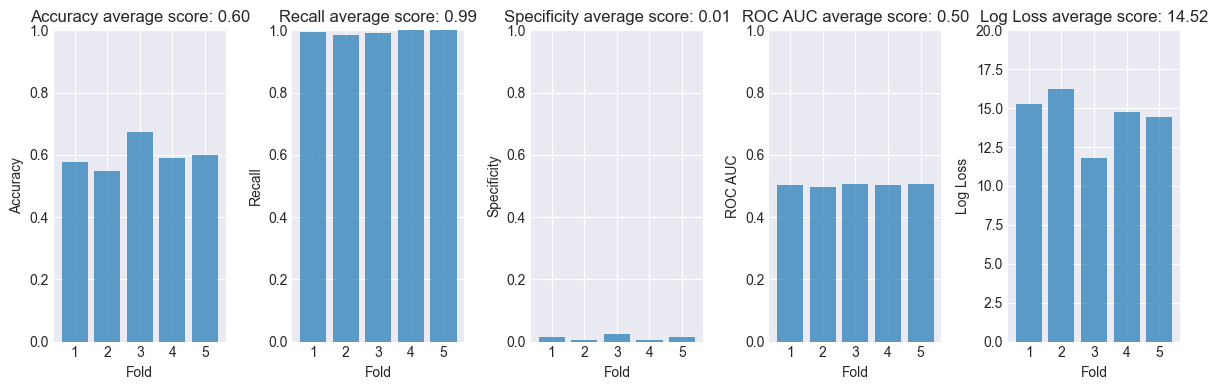

[0.5972703896617657, 0.9941937602627258, 0.011960536086436194, 0.5030771481745809, 14.515846484565529]


In [724]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = svm_k_fold(folds_lasso_3d)
th_svm_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_svm_3d.append(average_metrics_3d)

### Resultados Support Vector Machine - 3D

In [725]:
print(results_svm_3d)

[[0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114], [0.72320095529036, 0.8801694594393613, 0.49304242744268584, 0.6866059434410235, 9.976848825953008], [0.5984161520259629, 0.9975453149001536, 0.009867512830622241, 0.503706413865388, 14.474549023044114], [0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114], [0.5972703896617657, 0.9941937602627258, 0.011960536086436194, 0.5030771481745809, 14.515846484565529]]


In [726]:
print("Número de abordagens:", len(results_svm_3d))
for i, result in enumerate(results_svm_3d):
    print(f"{i+1}: {result}")


Número de abordagens: 5
1: [0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114]
2: [0.72320095529036, 0.8801694594393613, 0.49304242744268584, 0.6866059434410235, 9.976848825953008]
3: [0.5984161520259629, 0.9975453149001536, 0.009867512830622241, 0.503706413865388, 14.474549023044114]
4: [0.5984161520259628, 1.0, 0.005482279751051899, 0.5027411398755259, 14.474549023044114]
5: [0.5972703896617657, 0.9941937602627258, 0.011960536086436194, 0.5030771481745809, 14.515846484565529]


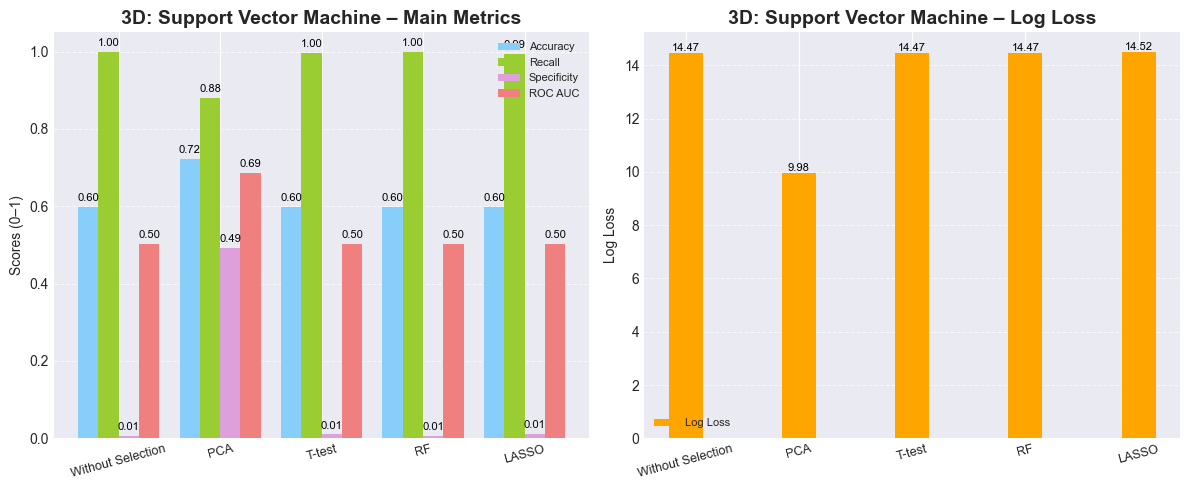

In [727]:
plot_scores(results_svm_3d, "3D: Support Vector Machine")

## Random Forest - 3D

### Random Forest Sem Seleção de Features

In [664]:
data_all_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               400.0   
2608       4            1        5                               400.0   
2609       3            1        5                               400.0   
2610       2            1        1                               400.0   
2611       2            1        5                               400.0   

      original_shape_Elongation  ...  original_glrlm_RunVariance  \
0                      0.933047  ...                    0.520519   
1                      0.785904  ...                    0.545514   
2                      0.835582  ...                    0.540904   
3                      0.713714  ...                    0.364716   
4                      0.945512  ...                    0.449092   
...                         ...  ...                         ...   
2607                   0.806955  ...                    0.432866   
2608                   0.561097  ...                    0.433158   
2609                   0.790535  ...                    0.566699   
2610                   0.878163  ...                    0.411385   
2611                   0.828939  ...                    0.336309   

      original_glrlm_ShortRunEmphasis  \
0                            0.876955   
1                            0.863305   
2                            0.876231   
3                            0.878266   
4                            0.879559   
...                               ...   
2607                         0.891968   
2608                         0.864611   
2609                         0.861718   
2610                         0.887794   
2611                         0.927437   

      original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                         0.912478   
1                                         3.358479   
2                                         0.981826   
3                                         0.878266   
4                                         0.879559   
...                                            ...   
2607                                      1.542134   
2608                                      0.864611   
2609                                      0.861718   
2610                                      1.011445   
2611                                      0.927437   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                

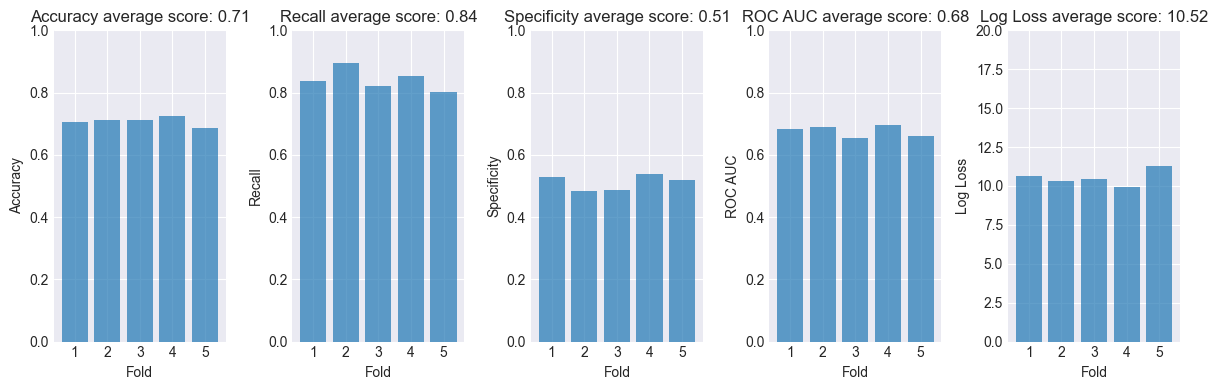

[0.7082686827395734, 0.84197287853919, 0.5121802848215602, 0.677076581680375, 10.515062482085384]


In [683]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = random_forest_kfold(fold_all_3d)
th_rf_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

### Random Forest + PCA

In [666]:
data_pca_3d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0    -1.278067   9.576904 -1.156507  3.757274 -1.615755 -3.860658 -1.097963   
1    -6.446833  13.619389 -3.613062  0.596606 -2.112019 -0.131476 -1.602061   
2    -0.996221   5.733703  0.031564  2.192263 -2.008760 -3.745283  0.056094   
3     2.203329  -1.096471  0.069448  2.726237  0.137445  0.199358 -0.468743   
4     2.113985  -0.136765 -0.356323  2.454730  0.104751  0.309677 -0.594976   
...        ...        ...       ...       ...       ...       ...       ...   
2607 -5.297076   2.860926  4.356948  2.181465 -1.113462 -0.902548 -0.763268   
2608  1.107153   5.528833 -2.353303  4.048105  0.710450  0.830768 -1.735930   
2609  1.557863   3.749841 -2.025833  2.536779  0.565856  0.668404 -1.483379   
2610 -0.981719   3.371373  1.978289  2.922428 -1.974097 -3.661183  0.200367   
2611  2.216879  -1.944034  0.831802  4.757672 -0.218913  0.312784  0.211815   

           PC7       PC8       PC9  ...      PC13      PC14       PC15  \
0     0.430526  1.950767 -0.486700  ...  1.429148  0.091078  -0.486037   
1    -2.048227 -4.508803 -1.437513  ...  1.605232 -0.481154   1.909910   
2    -2.082406 -3.410250  1.629019  ...  1.256107 -0.167175  -0.215375   
3    -0.203385  0.871312 -0.268072  ... -0.346194  0.011146   0.096051   
4     0.899847 -0.135164  0.450913  ...  0.609936  0.529577  -0.175882   
...        ...       ...       ...  ...       ...       ...        ...   
2607 -0.579069  2.122959  0.914349  ... -0.885684 -1.704124  13.339463   
2608  0.689661  1.794291  1.167974  ... -1.398670  0.002915   0.758514   
2609  1.044880  0.158526  1.756955  ...  0.420673  0.066838   0.350159   
2610 -2.419413 -2.747674  1.499801  ...  0.156578  0.334455  -1.066082   
2611  0.091883 -0.484289 -0.103599  ... -0.151501  0.481568  -0.306185   

          PC16      PC17      PC18      PC19      PC20      PC21      PC22  
0     0.381170 -0.210300 -0.527217 -0.658950 -0.495133 -1.122424 -0.235036  
1    -0.465967 -0.636408  0.342292 -1.850376 -1.022287  2.162197  0.509957  
2    -0.675650 -0.835954 -1.635870 -0.566318  0.133759  0.135643 -0.098179  
3    -0.277266 -0.440305 -0.274018  0.529545 -0.285955  0.179709  0.749678  
4     0.877427  0.687000  0.821011 -0.328398  0.449049 -0.672370  0.574434  
...        ...       ...       ...       ...       ...       ...       ...  
2607 -1.843934  2.795739 -0.400100  3.961215  0.882348 -1.066333 -0.489437  
2608  0.104635 -1.757344 -0.842843 -0.055677  0.057312 -1.122804  1.180295  
2609  0.338420 -0.979148  0.077650 -0.098412  0.242742 -0.963399  1.002933  
2610 -0.456464  0.526858 -1.207021 -0.362193 -1.182742 -1.125125  0.163694  
2611  0.125837  0.686246  0.485241  0.604918 -0.100905  0.884664 -0.466499  

[2612 rows x 23 columns]

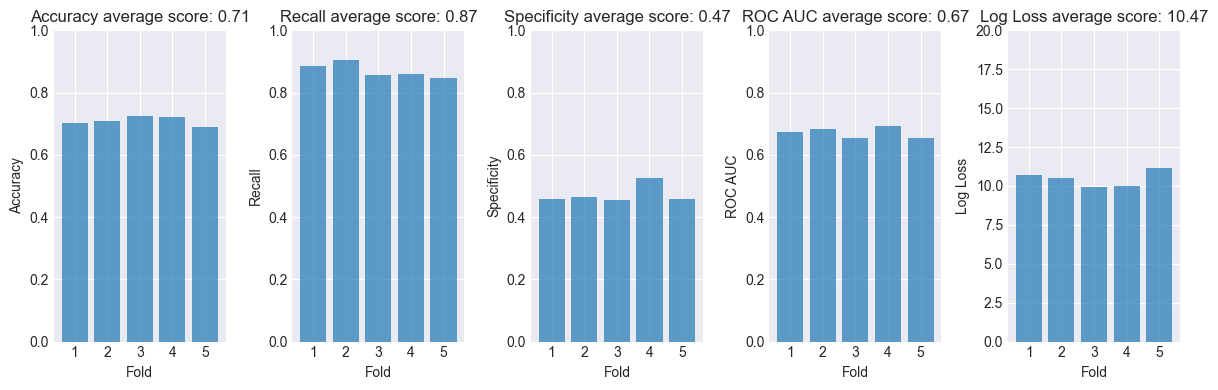

[0.7094210383654571, 0.8711159499731963, 0.47150707073938314, 0.6713115103562898, 10.47352737532503]


In [684]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = random_forest_kfold(fold_pca_3d)
th_rf_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

### Random Forest + t-test

In [685]:
data_ttest_3d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape_Sphericity  Subtlety  \
0                      0.124353         5   
1                      0.118720         2   
2                      0.163177         1   
3                      0.247734         5   
4                      0.195385         4   
...                         ...       ...   
2607                   0.161158         5   
2608                   0.133374         5   
2609                   0.145364         5   
2610                   0.159166         1   
2611                   0.289373         4   

      original_shape_Maximum2DDiameterRow  original_shape_MinorAxisLength  \
0                               49.010203                       45.550617   
1                               47.169906                       34.257045   
2                               37.947332                       32.288129   
3                               17.262677                       12.501689   
4                               18.788294                       19.950917   
...                                   ...                             ...   
2607                            27.000000                       22.014102   
2608                            52.839379                       27.175070   
2609                            35.468296                       30.306794   
2610                            28.160256                       26.813846   
2611                            15.297059                       12.680470   

      original_shape_MajorAxisLength  original_shape_Maximum3DDiameter  ...  \
0                          48.819234                         50.019996  ...   
1                          43.589345                         53.018865  ...   
2                          38.641489                         37.947332  ...   
3                          17.516392                         17.262677  ...   
4                          21.100653                         19.000000  ...   
...                              ...                               ...  ...   
2607                       27.280467                         28.017851  ...   
2608                       48.431996                         58.677082  ...   
2609                       38.337072                         35.468296  ...   
2610                       30.534011                         28.160256  ...   
2611                       15.297228                         15.297059  ...   

      original_firstorder_Uniformity  original_glrlm_ShortRunEmphasis  \
0                           0.991510                         0.876955   
1                           0.962354                         0.863305   
2                           0.988930                         0.876231   
3                           1.000000                         0.878266   
4                           1.000000                         0.879559   
...                              ...                              ...   
2607                        0.872166                         0.891968   
2608                        1.000000                         0.864611   
2609                        1.000000                         0.861718   
2610                        0.972104                         0.887794   
2611                        1.000000                         0.927437   

      original_glrlm_LowGrayLevelRunEmpha

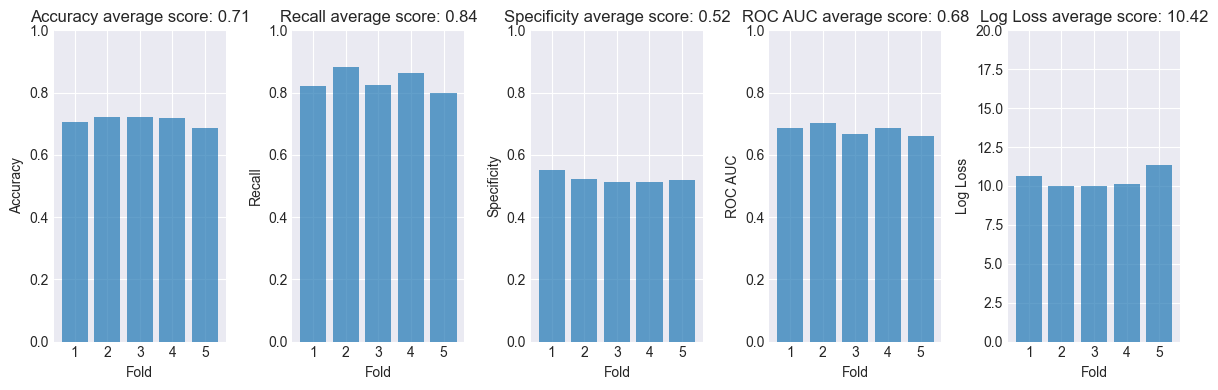

[0.710947012153579, 0.8383330177628728, 0.523459679084568, 0.6808963484237204, 10.418525705025088]


In [686]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = random_forest_kfold(fold_ttest_3d)
th_rf_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

### Random Forest + Random Forest (seleção de features)

In [687]:
data_randomforest_3d

Calcification  Lobulation  Subtlety  original_shape_MinorAxisLength  \
0                 6           3         5                       45.550617   
1                 6           1         2                       34.257045   
2                 6           1         1                       32.288129   
3                 6           2         5                       12.501689   
4                 6           1         4                       19.950917   
...             ...         ...       ...                             ...   
2607              6           1         5                       22.014102   
2608              6           3         5                       27.175070   
2609              6           1         5                       30.306794   
2610              6           1         1                       26.813846   
2611              6           1         4                       12.680470   

      original_shape_Elongation  diagnostics_Image-original_Size_x  Margin  \
0                      0.933047                              133.0       4   
1                      0.785904                              261.0       1   
2                      0.835582                              140.0       2   
3                      0.713714                              140.0       3   
4                      0.945512                              140.0       4   
...                         ...                                ...     ...   
2607                   0.806955                              133.0       4   
2608                   0.561097                              133.0       4   
2609                   0.790535                              133.0       3   
2610                   0.878163                              133.0       2   
2611                   0.828939                              166.0       2   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                        0.878266   
4                                        0.879559   
...                                           ...   
2607                                     0.828548   
2608                                     0.864611   
2609                                     0.861718   
2610                                     0.873611   
2611                                     0.927437   

      diagnostics_Mask-original_Size_x  original_shape_MajorAxisLength  ...  \
0                                133.0                       48.819234  ...   
1                                261.0                       43.589345  ...   
2                                140.0                       38.641489  ...   
3                                140.0                       17.516392  ...   
4                                140.0                       21.100653  ...   
...                                ...                             ...  ...   
2607                             133.0                       27.280467  ...   
2608                             133.0                       48.431996  ...   
2609                             133.0                       38.337072  ...   
2610                             133.0                       30.534011  ...   
2611                             166.0                       15.297228  ...   

      original_firstorder_Range  original_firstorder_RootMeanSquared  \
0                          66.0                           999.749918   
1                         596.0                           996.825952   
2                         135.0                           999.563877   
3                           0.0                          1000.000000   
4                           0.0                          1000.000000   
...                         ...                                  ...   
2607                      134.0                       

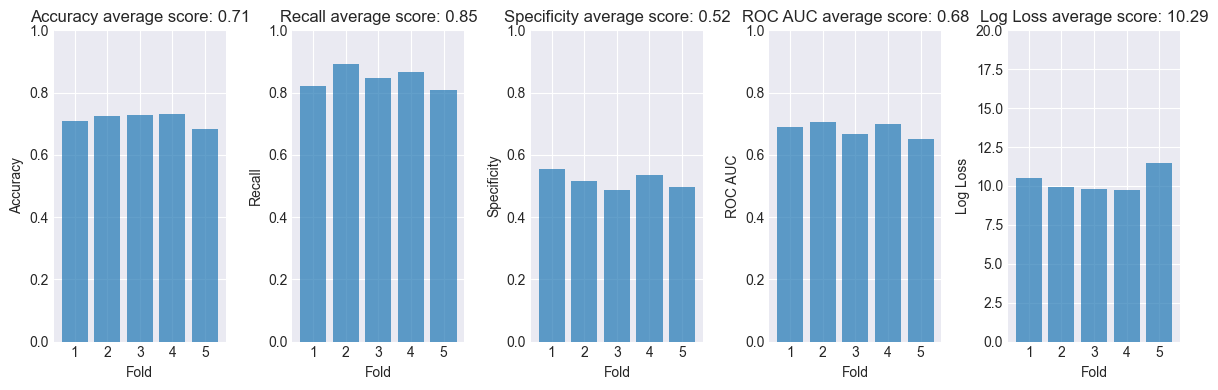

[0.7143938228463844, 0.8469889329491276, 0.5179228207416148, 0.6824558768453712, 10.294290055115713]


In [688]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = random_forest_kfold(fold_randomforest_3d)
th_rf_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

### Random Forest + LASSO

In [689]:
data_lasso_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  original_shape_Elongation  \
0          4            5        5                   0.933047   
1          1            1        1                   0.785904   
2          2            1        1                   0.835582   
3          3            2        4                   0.713714   
4          4            1        5                   0.945512   
...      ...          ...      ...                        ...   
2607       4            5        4                   0.806955   
2608       4            1        5                   0.561097   
2609       3            1        5                   0.790535   
2610       2            1        1                   0.878163   
2611       2            1        5                   0.828939   

      original_shape_Sphericity  ...  \
0                      0.124353  ...   
1                      0.118720  ...   
2                      0.163177  ...   
3                      0.247734  ...   
4                      0.195385  ...   
...                         ...  ...   
2607                   0.161158  ...   
2608                   0.133374  ...   
2609                   0.145364  ...   
2610                   0.159166  ...   
2611                   0.289373  ...   

      original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                    174845.116667   
1                                     98101.395383   
2                                     72092.347222   
3                                     11236.000000   
4                                     37636.000000   
...                                            ...   
2607                                   4521.250631   
2608                                 495616.000000   
2609                                 309136.000000   
2610                                  12973.778935   
2611                                   2916.000000   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.116667   
1                                         0.057643   
2                                         0.097223   
3                                         0.000089   
4                                         0.000027   
...                                            ...   
2607                                      0.088386   
2608                                      0.000002   
2609                                      0.000003   
2610                                      0.278937   
2611                                      0.000343   

      original_glszm_ZoneVariance  original_firstorder_10Percentile  \
0                   139576.960000                           -1000.0   
1                    95477.767258                           -1000.0   
2                    53868.000000                           -1000.0   
3                        0.000000                           -1000.0   
4                        0.000000                           -1000.0   
...                           ...                               ...   
2607                  4051.471074   

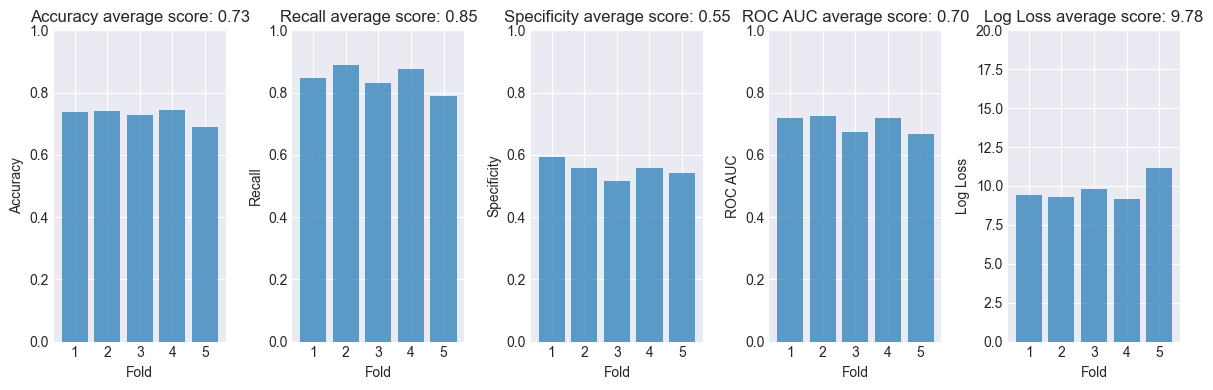

[0.7285517534413163, 0.8468588979051056, 0.5535804781643365, 0.7002196880347211, 9.783986512044809]


In [690]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = random_forest_kfold(folds_lasso_3d)
th_rf_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_rf_3d.append(average_metrics_3d)

### Resultados Random Forest - 3D

In [691]:
print(results_rf_3d)

[[0.7082686827395734, 0.84197287853919, 0.5121802848215602, 0.677076581680375, 10.515062482085384], [0.7094210383654571, 0.8711159499731963, 0.47150707073938314, 0.6713115103562898, 10.47352737532503], [0.710947012153579, 0.8383330177628728, 0.523459679084568, 0.6808963484237204, 10.418525705025088], [0.7143938228463844, 0.8469889329491276, 0.5179228207416148, 0.6824558768453712, 10.294290055115713], [0.7285517534413163, 0.8468588979051056, 0.5535804781643365, 0.7002196880347211, 9.783986512044809]]


In [692]:
print("Número de abordagens:", len(results_rf_3d))
for i, result in enumerate(results_rf_3d):
    print(f"{i+1}: {result}")


Número de abordagens: 5
1: [0.7082686827395734, 0.84197287853919, 0.5121802848215602, 0.677076581680375, 10.515062482085384]
2: [0.7094210383654571, 0.8711159499731963, 0.47150707073938314, 0.6713115103562898, 10.47352737532503]
3: [0.710947012153579, 0.8383330177628728, 0.523459679084568, 0.6808963484237204, 10.418525705025088]
4: [0.7143938228463844, 0.8469889329491276, 0.5179228207416148, 0.6824558768453712, 10.294290055115713]
5: [0.7285517534413163, 0.8468588979051056, 0.5535804781643365, 0.7002196880347211, 9.783986512044809]


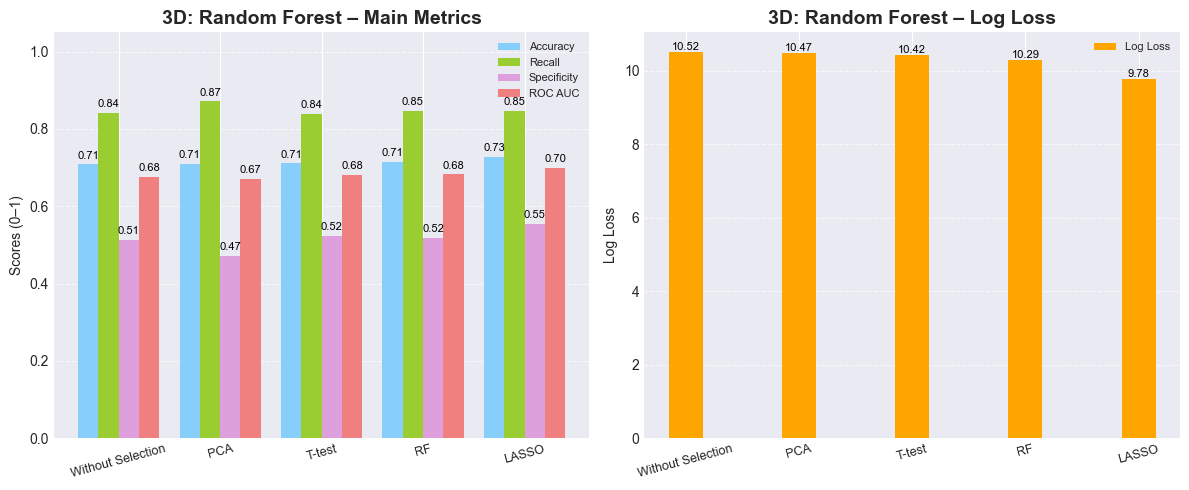

In [693]:
plot_scores(results_rf_3d, "3D: Random Forest")

## XGBOOST - 3D

### XGBoost Sem Seleção de Features

In [694]:
data_all_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  diagnostics_Image-original_Maximum  \
0          4            5        5                               400.0   
1          1            1        1                               400.0   
2          2            1        1                               400.0   
3          3            2        4                               400.0   
4          4            1        5                               400.0   
...      ...          ...      ...                                 ...   
2607       4            5        4                               400.0   
2608       4            1        5                               400.0   
2609       3            1        5                               400.0   
2610       2            1        1                               400.0   
2611       2            1        5                               400.0   

      original_shape_Elongation  ...  original_glrlm_RunVariance  \
0                      0.933047  ...                    0.520519   
1                      0.785904  ...                    0.545514   
2                      0.835582  ...                    0.540904   
3                      0.713714  ...                    0.364716   
4                      0.945512  ...                    0.449092   
...                         ...  ...                         ...   
2607                   0.806955  ...                    0.432866   
2608                   0.561097  ...                    0.433158   
2609                   0.790535  ...                    0.566699   
2610                   0.878163  ...                    0.411385   
2611                   0.828939  ...                    0.336309   

      original_glrlm_ShortRunEmphasis  \
0                            0.876955   
1                            0.863305   
2                            0.876231   
3                            0.878266   
4                            0.879559   
...                               ...   
2607                         0.891968   
2608                         0.864611   
2609                         0.861718   
2610                         0.887794   
2611                         0.927437   

      original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                         0.912478   
1                                         3.358479   
2                                         0.981826   
3                                         0.878266   
4                                         0.879559   
...                                            ...   
2607                                      1.542134   
2608                                      0.864611   
2609                                      0.861718   
2610                                      1.011445   
2611                                      0.927437   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                

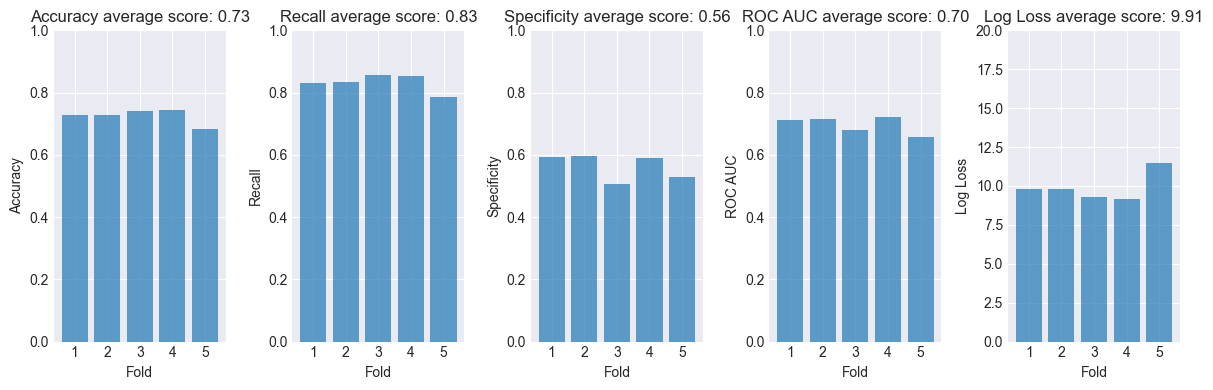

[0.7251122685948295, 0.8324285170793668, 0.5626616578851312, 0.6975450874822491, 9.9079581116887]


In [695]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = xgboost_k_fold(fold_all_3d)
th_xgb_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

### XGBoost + PCA

In [696]:
data_pca_3d

PC0        PC1       PC2       PC3       PC4       PC5       PC6  \
0    -1.278067   9.576904 -1.156507  3.757274 -1.615755 -3.860658 -1.097963   
1    -6.446833  13.619389 -3.613062  0.596606 -2.112019 -0.131476 -1.602061   
2    -0.996221   5.733703  0.031564  2.192263 -2.008760 -3.745283  0.056094   
3     2.203329  -1.096471  0.069448  2.726237  0.137445  0.199358 -0.468743   
4     2.113985  -0.136765 -0.356323  2.454730  0.104751  0.309677 -0.594976   
...        ...        ...       ...       ...       ...       ...       ...   
2607 -5.297076   2.860926  4.356948  2.181465 -1.113462 -0.902548 -0.763268   
2608  1.107153   5.528833 -2.353303  4.048105  0.710450  0.830768 -1.735930   
2609  1.557863   3.749841 -2.025833  2.536779  0.565856  0.668404 -1.483379   
2610 -0.981719   3.371373  1.978289  2.922428 -1.974097 -3.661183  0.200367   
2611  2.216879  -1.944034  0.831802  4.757672 -0.218913  0.312784  0.211815   

           PC7       PC8       PC9  ...      PC13      PC14       PC15  \
0     0.430526  1.950767 -0.486700  ...  1.429148  0.091078  -0.486037   
1    -2.048227 -4.508803 -1.437513  ...  1.605232 -0.481154   1.909910   
2    -2.082406 -3.410250  1.629019  ...  1.256107 -0.167175  -0.215375   
3    -0.203385  0.871312 -0.268072  ... -0.346194  0.011146   0.096051   
4     0.899847 -0.135164  0.450913  ...  0.609936  0.529577  -0.175882   
...        ...       ...       ...  ...       ...       ...        ...   
2607 -0.579069  2.122959  0.914349  ... -0.885684 -1.704124  13.339463   
2608  0.689661  1.794291  1.167974  ... -1.398670  0.002915   0.758514   
2609  1.044880  0.158526  1.756955  ...  0.420673  0.066838   0.350159   
2610 -2.419413 -2.747674  1.499801  ...  0.156578  0.334455  -1.066082   
2611  0.091883 -0.484289 -0.103599  ... -0.151501  0.481568  -0.306185   

          PC16      PC17      PC18      PC19      PC20      PC21      PC22  
0     0.381170 -0.210300 -0.527217 -0.658950 -0.495133 -1.122424 -0.235036  
1    -0.465967 -0.636408  0.342292 -1.850376 -1.022287  2.162197  0.509957  
2    -0.675650 -0.835954 -1.635870 -0.566318  0.133759  0.135643 -0.098179  
3    -0.277266 -0.440305 -0.274018  0.529545 -0.285955  0.179709  0.749678  
4     0.877427  0.687000  0.821011 -0.328398  0.449049 -0.672370  0.574434  
...        ...       ...       ...       ...       ...       ...       ...  
2607 -1.843934  2.795739 -0.400100  3.961215  0.882348 -1.066333 -0.489437  
2608  0.104635 -1.757344 -0.842843 -0.055677  0.057312 -1.122804  1.180295  
2609  0.338420 -0.979148  0.077650 -0.098412  0.242742 -0.963399  1.002933  
2610 -0.456464  0.526858 -1.207021 -0.362193 -1.182742 -1.125125  0.163694  
2611  0.125837  0.686246  0.485241  0.604918 -0.100905  0.884664 -0.466499  

[2612 rows x 23 columns]

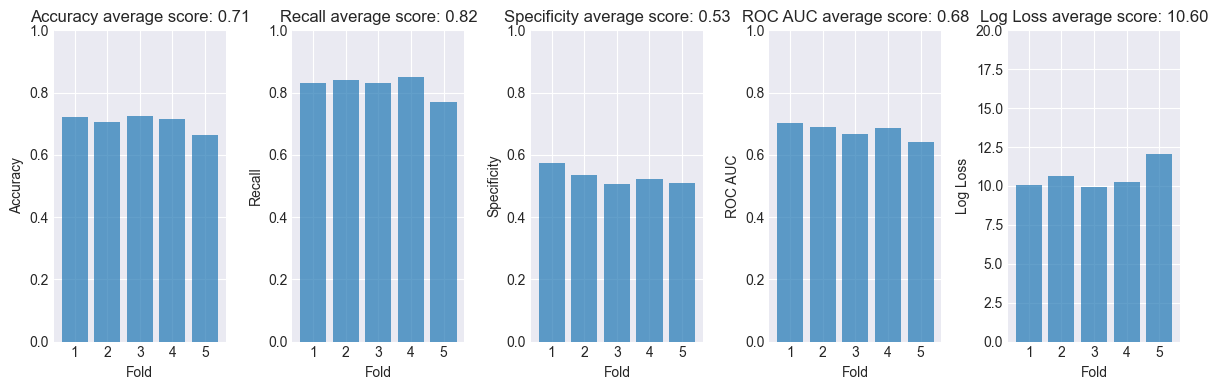

[0.7059669018263335, 0.824787698031679, 0.5293299732792153, 0.677058835655447, 10.59802707549989]


In [697]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = xgboost_k_fold(fold_pca_3d)
th_xgb_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

### XGBoost + t-test

In [698]:
data_ttest_3d

Calcification  Lobulation  Spiculation  Margin  \
0                 6           3            5       4   
1                 6           1            1       1   
2                 6           1            1       2   
3                 6           2            2       3   
4                 6           1            1       4   
...             ...         ...          ...     ...   
2607              6           1            5       4   
2608              6           3            1       4   
2609              6           1            1       3   
2610              6           1            1       2   
2611              6           1            1       2   

      original_shape_Sphericity  Subtlety  \
0                      0.124353         5   
1                      0.118720         2   
2                      0.163177         1   
3                      0.247734         5   
4                      0.195385         4   
...                         ...       ...   
2607                   0.161158         5   
2608                   0.133374         5   
2609                   0.145364         5   
2610                   0.159166         1   
2611                   0.289373         4   

      original_shape_Maximum2DDiameterRow  original_shape_MinorAxisLength  \
0                               49.010203                       45.550617   
1                               47.169906                       34.257045   
2                               37.947332                       32.288129   
3                               17.262677                       12.501689   
4                               18.788294                       19.950917   
...                                   ...                             ...   
2607                            27.000000                       22.014102   
2608                            52.839379                       27.175070   
2609                            35.468296                       30.306794   
2610                            28.160256                       26.813846   
2611                            15.297059                       12.680470   

      original_shape_MajorAxisLength  original_shape_Maximum3DDiameter  ...  \
0                          48.819234                         50.019996  ...   
1                          43.589345                         53.018865  ...   
2                          38.641489                         37.947332  ...   
3                          17.516392                         17.262677  ...   
4                          21.100653                         19.000000  ...   
...                              ...                               ...  ...   
2607                       27.280467                         28.017851  ...   
2608                       48.431996                         58.677082  ...   
2609                       38.337072                         35.468296  ...   
2610                       30.534011                         28.160256  ...   
2611                       15.297228                         15.297059  ...   

      original_firstorder_Uniformity  original_glrlm_ShortRunEmphasis  \
0                           0.991510                         0.876955   
1                           0.962354                         0.863305   
2                           0.988930                         0.876231   
3                           1.000000                         0.878266   
4                           1.000000                         0.879559   
...                              ...                              ...   
2607                        0.872166                         0.891968   
2608                        1.000000                         0.864611   
2609                        1.000000                         0.861718   
2610                        0.972104                         0.887794   
2611                        1.000000                         0.927437   

      original_glrlm_LowGrayLevelRunEmpha

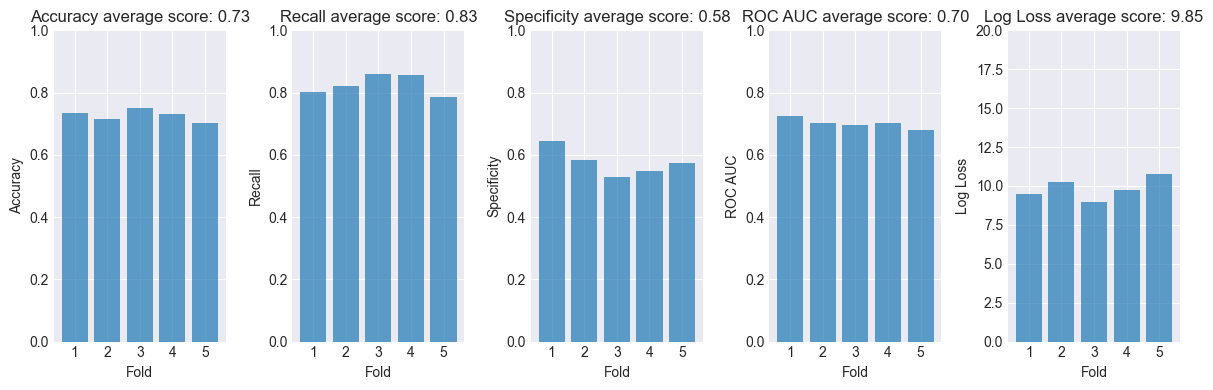

[0.7266470333985334, 0.8255594574258526, 0.5765619144591516, 0.7010606859425021, 9.852639581070182]


In [699]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = xgboost_k_fold(fold_ttest_3d)
th_xgb_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

### XGBoost + Random Forest (seleção de Features)

In [700]:
data_randomforest_3d

Calcification  Lobulation  Subtlety  original_shape_MinorAxisLength  \
0                 6           3         5                       45.550617   
1                 6           1         2                       34.257045   
2                 6           1         1                       32.288129   
3                 6           2         5                       12.501689   
4                 6           1         4                       19.950917   
...             ...         ...       ...                             ...   
2607              6           1         5                       22.014102   
2608              6           3         5                       27.175070   
2609              6           1         5                       30.306794   
2610              6           1         1                       26.813846   
2611              6           1         4                       12.680470   

      original_shape_Elongation  diagnostics_Image-original_Size_x  Margin  \
0                      0.933047                              133.0       4   
1                      0.785904                              261.0       1   
2                      0.835582                              140.0       2   
3                      0.713714                              140.0       3   
4                      0.945512                              140.0       4   
...                         ...                                ...     ...   
2607                   0.806955                              133.0       4   
2608                   0.561097                              133.0       4   
2609                   0.790535                              133.0       3   
2610                   0.878163                              133.0       2   
2611                   0.828939                              166.0       2   

      original_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                        0.872459   
1                                        0.840952   
2                                        0.870237   
3                                        0.878266   
4                                        0.879559   
...                                           ...   
2607                                     0.828548   
2608                                     0.864611   
2609                                     0.861718   
2610                                     0.873611   
2611                                     0.927437   

      diagnostics_Mask-original_Size_x  original_shape_MajorAxisLength  ...  \
0                                133.0                       48.819234  ...   
1                                261.0                       43.589345  ...   
2                                140.0                       38.641489  ...   
3                                140.0                       17.516392  ...   
4                                140.0                       21.100653  ...   
...                                ...                             ...  ...   
2607                             133.0                       27.280467  ...   
2608                             133.0                       48.431996  ...   
2609                             133.0                       38.337072  ...   
2610                             133.0                       30.534011  ...   
2611                             166.0                       15.297228  ...   

      original_firstorder_Range  original_firstorder_RootMeanSquared  \
0                          66.0                           999.749918   
1                         596.0                           996.825952   
2                         135.0                           999.563877   
3                           0.0                          1000.000000   
4                           0.0                          1000.000000   
...                         ...                                  ...   
2607                      134.0                       

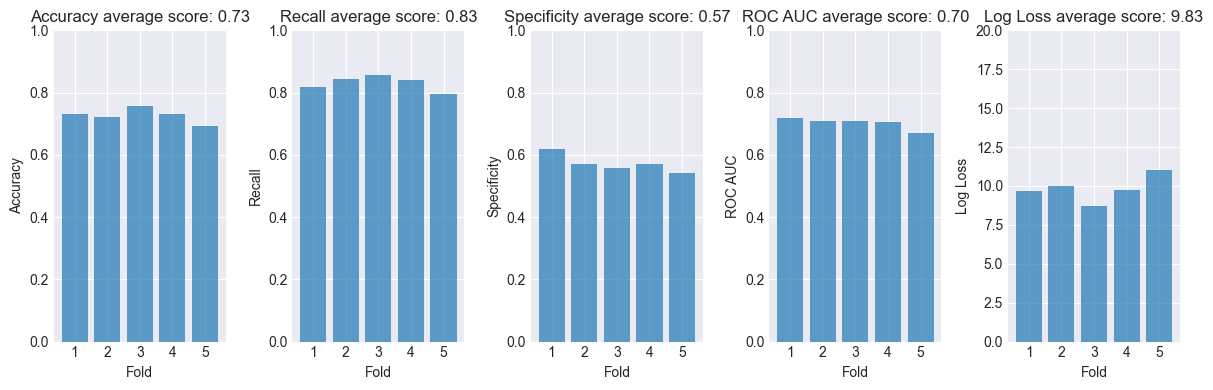

[0.7274118517541739, 0.831160436608727, 0.572466983937896, 0.7018137102733115, 9.825072733353839]


In [701]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = xgboost_k_fold(fold_randomforest_3d)
th_xgb_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

### XGBoost + LASSO

In [702]:
data_lasso_3d

InternalStructure  Sphericity  Calcification  Subtlety  Lobulation  \
0                     1           3              6         5           3   
1                     1           5              6         2           1   
2                     1           5              6         1           1   
3                     1           4              6         5           2   
4                     1           3              6         4           1   
...                 ...         ...            ...       ...         ...   
2607                  4           5              6         5           1   
2608                  1           3              6         5           3   
2609                  1           4              6         5           1   
2610                  1           4              6         1           1   
2611                  1           4              6         4           1   

      Margin  Spiculation  Texture  original_shape_Elongation  \
0          4            5        5                   0.933047   
1          1            1        1                   0.785904   
2          2            1        1                   0.835582   
3          3            2        4                   0.713714   
4          4            1        5                   0.945512   
...      ...          ...      ...                        ...   
2607       4            5        4                   0.806955   
2608       4            1        5                   0.561097   
2609       3            1        5                   0.790535   
2610       2            1        1                   0.878163   
2611       2            1        5                   0.828939   

      original_shape_Sphericity  ...  \
0                      0.124353  ...   
1                      0.118720  ...   
2                      0.163177  ...   
3                      0.247734  ...   
4                      0.195385  ...   
...                         ...  ...   
2607                   0.161158  ...   
2608                   0.133374  ...   
2609                   0.145364  ...   
2610                   0.159166  ...   
2611                   0.289373  ...   

      original_glszm_LargeAreaLowGrayLevelEmphasis  \
0                                    174845.116667   
1                                     98101.395383   
2                                     72092.347222   
3                                     11236.000000   
4                                     37636.000000   
...                                            ...   
2607                                   4521.250631   
2608                                 495616.000000   
2609                                 309136.000000   
2610                                  12973.778935   
2611                                   2916.000000   

      original_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                         0.116667   
1                                         0.057643   
2                                         0.097223   
3                                         0.000089   
4                                         0.000027   
...                                            ...   
2607                                      0.088386   
2608                                      0.000002   
2609                                      0.000003   
2610                                      0.278937   
2611                                      0.000343   

      original_glszm_ZoneVariance  original_firstorder_10Percentile  \
0                   139576.960000                           -1000.0   
1                    95477.767258                           -1000.0   
2                    53868.000000                           -1000.0   
3                        0.000000                           -1000.0   
4                        0.000000                           -1000.0   
...                           ...                               ...   
2607                  4051.471074   

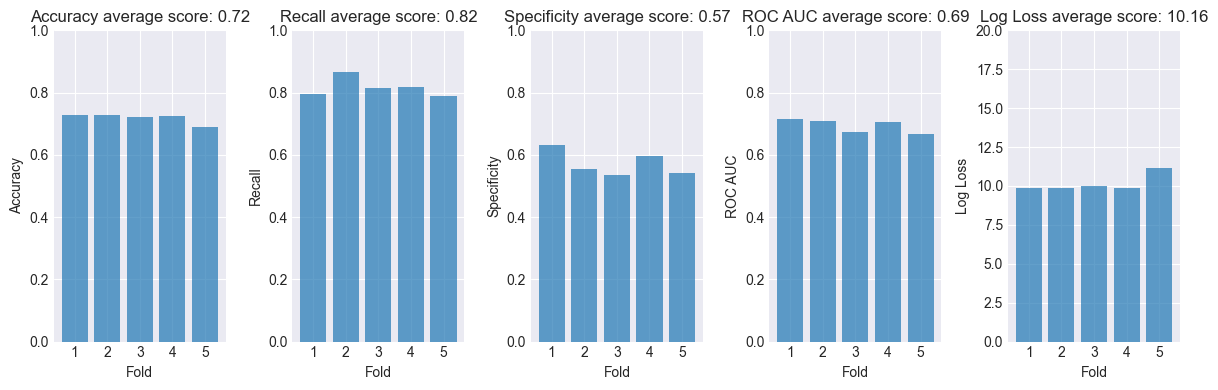

[0.7182171820399552, 0.8168763559048167, 0.5717240905026875, 0.6943002232037521, 10.156482221560552]


In [703]:
accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d = xgboost_k_fold(folds_lasso_3d)
th_xgb_3d.append([accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d])
average_metrics_3d = plot_metrics(accuracies_3d, recalls_3d, specifities_3d, roc_aucs_3d, log_losses_3d)
print(average_metrics_3d)
results_xgb_3d.append(average_metrics_3d)

### Resultados XGBoost - 3D

In [704]:
print(results_xgb_3d)

[[0.7251122685948295, 0.8324285170793668, 0.5626616578851312, 0.6975450874822491, 9.9079581116887], [0.7059669018263335, 0.824787698031679, 0.5293299732792153, 0.677058835655447, 10.59802707549989], [0.7266470333985334, 0.8255594574258526, 0.5765619144591516, 0.7010606859425021, 9.852639581070182], [0.7274118517541739, 0.831160436608727, 0.572466983937896, 0.7018137102733115, 9.825072733353839], [0.7182171820399552, 0.8168763559048167, 0.5717240905026875, 0.6943002232037521, 10.156482221560552]]


In [705]:
print("Número de abordagens:", len(results_xgb_3d))
for i, result in enumerate(results_xgb_3d):
    print(f"{i+1}: {result}")


Número de abordagens: 5
1: [0.7251122685948295, 0.8324285170793668, 0.5626616578851312, 0.6975450874822491, 9.9079581116887]
2: [0.7059669018263335, 0.824787698031679, 0.5293299732792153, 0.677058835655447, 10.59802707549989]
3: [0.7266470333985334, 0.8255594574258526, 0.5765619144591516, 0.7010606859425021, 9.852639581070182]
4: [0.7274118517541739, 0.831160436608727, 0.572466983937896, 0.7018137102733115, 9.825072733353839]
5: [0.7182171820399552, 0.8168763559048167, 0.5717240905026875, 0.6943002232037521, 10.156482221560552]


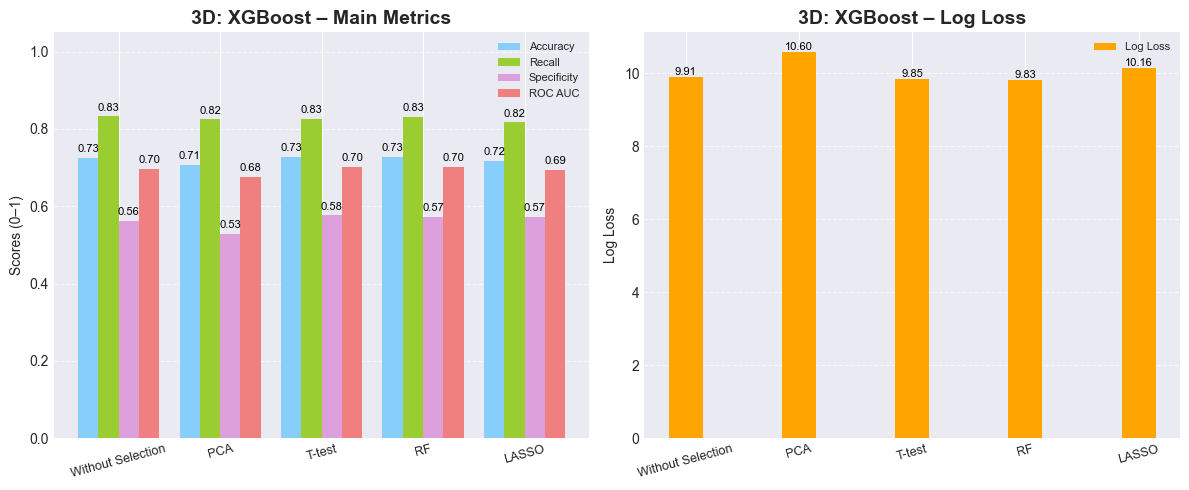

In [706]:
plot_scores(results_xgb_3d, "3D: XGBoost")

## Comparação entre diferentes modelos para o mesmo método de seleção de features

O código tem como finalidade comparar o desempenho de três modelos de machine learning (SVM, Random Forest e XGBoost) aplicados a distintos métodos de extração de features (Sem Seleção, PCA, t-test, Random Forest e LASSO).
A avaliação é conduzida com base em cinco métricas de desempenho: Accuracy, Recall, Specificity, ROC AUC, Log Loss, calculadas a partir de cinco folds dos dados.



O propósito central deste código é identificar, de forma estatisticamente fundamentada, se algum dos modelos apresenta desempenho significativamente superior aos outros em cada combinação de método de extração de features e métrica de avaliação. Ao realizar essa análise, é possível escolher o modelo de machine learning mais adequado para cada cenário específico de extração de features, maximizando assim o desempenho de acordo com a métrica que é mais importante para a aplicação.

**Aplicação dos Testes de Hipóteses**

Para avaliar as diferenças de desempenho entre os modelos, o procedimento recorre a testes estatísticos clássicos de comparação de médias. A análise é composta por duas etapas principais:

**1. Teste ANOVA (Análise de Variância)**

O teste ANOVA é utilizado para verificar se as médias das métricas obtidas pelos três modelos diferem significativamente para cada método de extração de features.
Para cada métrica e para cada método de extração de features, o teste compara as médias dos valores obtidos pelos modelos.
Quando o teste identifica diferenças significativas (um p-valor inferior a 0,05), isso indica que pelo menos um dos modelos apresenta desempenho estatisticamente distinto dos outros, sugerindo que pode haver um modelo com performance superior.

**2. Teste de Tukey (Comparações Múltiplas – Post Hoc)**

Quando o ANOVA detecta uma diferença significativa, aplica-se o teste de Tukey para identificar quais pares de modelos diferem entre si.
Esse teste post hoc realiza comparações múltiplas de forma controlada, permitindo determinar especificamente se um modelo é consistentemente melhor ou pior que os outros em termos de uma métrica particular.
Por exemplo, o teste pode revelar que o XGBoost supera estatisticamente o SVM e o Random Forest em accuracy para determinado método de extração, confirmando a sua superioridade com base em evidência estatística.

In [707]:

def avaliar_modelos_por_metodo(th_svm, th_rf, th_xgb):
    # Nome das métricas e modelos para análise
    metricas = ["Accuracy", "Recall", "Specificity", "ROC AUC", "Log Loss"]
    modelos = ["SVM", "Random Forest", "XGBoost"]
    metodos = ["Sem Seleção", "PCA", "t-test", "Random Forest", "LASSO"]
    
    # Iterar sobre cada método de extração de features
    for metodo_idx, metodo in enumerate(metodos):
        print(f"\nAnalisando método de extração de features: {metodo}\n" + "="*50)
        
        melhores_modelos = {}

        # Iterar sobre cada métrica (accuracy, log loss, dice coefficient)
        for metrica_idx, metrica in enumerate(metricas):
            print(f"\nMétrica: {metrica}\n" + "-"*50)
            
            # Extrair os dados para a métrica específica de cada modelo
            dados_metrica = [
                th_svm[metodo_idx][metrica_idx],  # Dados para SVM no método e métrica atual
                th_rf[metodo_idx][metrica_idx],   # Dados para Random Forest no método e métrica atual
                th_xgb[metodo_idx][metrica_idx]   # Dados para XGBoost no método e métrica atual
            ]
            
            # Calcular as médias para cada modelo para a métrica em questão
            medias = [np.mean(valores) for valores in dados_metrica]
            
            # Executar o teste ANOVA de uma via para comparar as médias entre os modelos
            f_stat, p_val = stats.f_oneway(*dados_metrica)
            
            if p_val < 0.05:
                print(f"Diferença significativa encontrada na métrica {metrica} (p = {p_val:.4f})")
                
                # Preparar dados para o teste de Tukey
                dados_flat = np.concatenate(dados_metrica)
                grupos = np.array([modelo for modelo in modelos for _ in range(5)])  # Repetir cada modelo 5 vezes
                
                # Executar o teste post hoc de Tukey para identificar quais modelos diferem
                tukey_result = pairwise_tukeyhsd(dados_flat, grupos, alpha=0.05)
                print(tukey_result)
                
                # Determinar o melhor modelo com base nas comparações de Tukey
                melhores = []
                if metrica == "Log Loss":
                    # Para log loss, menor média é melhor
                    for j, media in enumerate(medias):
                        # Verificar se o modelo atual é significativamente melhor que os outros
                        significativo = all(
                            tukey_result.reject[idx] 
                            for idx, group in enumerate(tukey_result.groupsunique) 
                            if modelos[j] == group
                        )
                        if significativo:
                            melhores.append((modelos[j], media))
                    melhor_modelo = min(melhores, key=lambda x: x[1])[0] if melhores else "Nenhum se destacou"
                    
                else:
                    # Para accuracy e dice coefficient, maior média é melhor
                    for j, media in enumerate(medias):
                        # Verificar se o modelo atual é significativamente melhor que os outros
                        significativo = all(
                            tukey_result.reject[idx] 
                            for idx, group in enumerate(tukey_result.groupsunique) 
                            if modelos[j] == group
                        )
                        if significativo:
                            melhores.append((modelos[j], media))
                    melhor_modelo = max(melhores, key=lambda x: x[1])[0] if melhores else "Nenhum se destacou"
                
                melhores_modelos[metrica] = melhor_modelo
                print(f"Melhor modelo para {metrica} com base no teste de hipóteses: {melhor_modelo}")
            
            else:
                print(f"Não há diferença significativa entre os modelos para a métrica {metrica} (p = {p_val:.4f})")
                melhores_modelos[metrica] = "Nenhum modelo se destacou"
        
        # Exibir o resumo dos melhores modelos para o método atual
        print(f"\nResumo dos melhores modelos para o método de extração '{metodo}':")
        for metrica, modelo in melhores_modelos.items():
            print(f"{metrica}: {modelo}")

Agora, vamos ver com as features 2d:

### Análise e Discussão : comparação de modelos por método de seleção (2D)

In [721]:
melhores_modelos = avaliar_modelos_por_metodo(th_svm_2d, th_rf_2d, th_xgb_2d)
print("\nMelhores modelos por método de seleção:", melhores_modelos)


Analisando método de extração de features: Sem Seleção

Métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0001)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.1144 0.0004 -0.1705 -0.0584   True
Random Forest XGBoost   0.0023 0.9934 -0.0538  0.0584  False
          SVM XGBoost   0.1167 0.0003  0.0607  0.1728   True
------------------------------------------------------------
Melhor modelo para Accuracy com base no teste de hipóteses: XGBoost

Métrica: Recall
--------------------------------------------------
Diferença significativa encontrada na métrica Recall (p = 0.0000)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------

Os resultados das análises evidenciam uma predominância do XGBoost em grande parte dos métodos de extração de features, demonstrando um desempenho consistentemente superior nas métricas avaliadas.
No método de extração Sem Seleção (onde não foi aplicado feature selection), o XGBoost destacou-se em quase todas as métricas: Accuracy, Specificity, ROC AUC e Log Loss, superando significativamente o SVM e o Random Forest. Apenas na métrica Recall o Random Forest apresentou uma leve vantagem, sugerindo maior sensibilidade, mas sem comprometer a superioridade global do XGBoost neste cenário.

Ao analisar o método PCA, não foram observadas diferenças estatisticamente significativas em várias métricas, como Accuracy, ROC AUC e Log Loss. Contudo, o Random Forest apresentou melhor desempenho em Recall, enquanto o XGBoost obteve os melhores valores em Specificity. Estes resultados indicam que a redução de dimensionalidade promovida pelo PCA tende a equilibrar o desempenho entre os modelos, reduzindo as discrepâncias observadas em outros métodos.

Com a utilização do t-test como técnica de seleção de features, o XGBoost voltou a destacar-se de forma consistente. Este modelo apresentou os melhores resultados em Accuracy, Specificity, ROC AUC e Log Loss, demonstrando robustez na identificação de padrões relevantes após a filtragem estatística das features.

No método de extração Random Forest, os resultados mantiveram o mesmo padrão: o XGBoost foi novamente o modelo com melhor desempenho geral, destacando-se em Accuracy, Specificity, ROC AUC e Log Loss. O Random Forest destacou-se em Recall, reforçando a sua tendência em maximizar a taxa de verdadeiros positivos, mas sem alcançar o mesmo equilíbrio entre métricas que o XGBoost apresentou.

Por fim, no método LASSO, verificou-se uma inversão parcial dessa tendência. O Random Forest apresentou o melhor desempenho em quatro das cinco métricas (Accuracy, Recall, ROC AUC e Log Loss), enquanto o XGBoost foi superior em Specificity. Esse resultado sugere que a regularização imposta pelo LASSO favorece modelos baseados em árvores, que se beneficiam da eliminação de features irrelevantes e da redução da complexidade.

Em síntese, o XGBoost destacou-se como o modelo mais robusto e estável nos métodos Sem Seleção, t-test e Random Forest, enquanto o Random Forest demonstrou melhor adaptação aos métodos de extração PCA e LASSO, especialmente na métrica Recall. Assim, conclui-se que não há um modelo universalmente superior, mas o desempenho ideal depende da interação entre o método de seleção de features e as características do modelo, sendo o XGBoost o mais consistente na generalização global e o Random Forest o mais sensível na identificação de padrões positivos.

Agora, vamos ver com as features 3d:

### Análise e Discussão : comparação de modelos por método de seleção (3D)

In [728]:
melhores_modelos = avaliar_modelos_por_metodo(th_svm_3d, th_rf_3d, th_xgb_3d)
print("\nMelhores modelos por método de seleção:", melhores_modelos)


Analisando método de extração de features: Sem Seleção

Métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Random Forest     SVM  -0.1099 0.0002 -0.1604 -0.0593   True
Random Forest XGBoost   0.0168 0.6571 -0.0337  0.0674  False
          SVM XGBoost   0.1267 0.0001  0.0761  0.1772   True
------------------------------------------------------------
Melhor modelo para Accuracy com base no teste de hipóteses: XGBoost

Métrica: Recall
--------------------------------------------------
Diferença significativa encontrada na métrica Recall (p = 0.0000)
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
    group1     group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------

A análise dos métodos de extração de features evidencia variações relevantes no desempenho dos modelos Random Forest, SVM e XGBoost em cada métrica avaliada.

No método de Sem Seleção, o XGBoost apresentou o melhor desempenho global, destacando-se nas métricas Accuracy, Specificity, ROC AUC e Log Loss, o que demonstra a sua capacidade de generalização mesmo sem redução ou filtragem prévia das features. O Random Forest superou os demais apenas na métrica Recall, evidenciando maior sensibilidade na detecção de casos positivos, mas sem igualar a consistência geral do XGBoost.

Para o método de PCA, não foram encontradas diferenças significativas entre os modelos em várias métricas, como Accuracy, ROC AUC e Log Loss, sugerindo desempenhos semelhantes. No entanto, o Random Forest destacou-se em Recall, enquanto o XGBoost apresentou melhor Specificity. Esses resultados indicam que o PCA tende a nivelar o desempenho entre os modelos, reduzindo diferenças expressivas e tornando-os comparáveis entre si.

Quando aplicou-se o método de seleção t-test, o XGBoost voltou a demonstrar superioridade na maioria das métricas, Accuracy, Specificity, ROC AUC e Log Loss, confirmando a sua eficácia em cenários onde as features são selecionadas com base em critérios estatísticos. O Random Forest, entretanto, manteve o melhor desempenho em Recall, reforçando a sua propensão a identificar corretamente amostras positivas, embora com ligeira perda de precisão.

No método de extração baseado em Random Forest, o padrão manteve-se semelhante ao do t-test: o XGBoost foi o melhor modelo em Accuracy, Specificity, ROC AUC e Log Loss, enquanto o Random Forest obteve os melhores resultados em Recall. Esse comportamento sugere que o XGBoost mantém boa generalização mesmo quando as features são selecionadas por outro modelo de árvores, enquanto o Random Forest continua a privilegiar a sensibilidade.

Por fim, no método LASSO, observou-se uma mudança no padrão de desempenho. O Random Forest apresentou os melhores resultados em quatro das cinco métricas, Accuracy, Recall, ROC AUC e Log Loss, enquanto o XGBoost foi superior apenas em Specificity. Isso indica que a regularização imposta pelo LASSO beneficia modelos baseados em árvores, ao reduzir a dimensionalidade e eliminar features menos relevantes.

Em síntese, os resultados mostram que o XGBoost é o modelo com melhor desempenho nos métodos Sem Seleção, t-test e Random Forest. Não existe, no entanto, um modelo que se sobressaia em todos os contextos: o desempenho ideal depende da combinação entre o método de seleção de features e as características do modelo, sendo o XGBoost mais equilibrado e o Random Forest mais sensível às instâncias positivas.

## Comparação entre diferentes métodos de seleção de features para um mesmo modelo de classificação

Este código foi desenvolvido para avaliar diferentes métodos de seleção de features para um modelo de machine learning específico (SVM, Random Forest, ou XGBoost) com base em cinco métricas de desempenho: accuracy, recall, specificity, roc auc e log loss. Ele compara cinco métodos de seleção de features (Sem Seleção, PCA, t-test, Random Forest e LASSO) e utiliza testes de hipóteses para identificar se há diferenças estatisticamente significativas no desempenho desses métodos.

O código visa ajudar na escolha do melhor método de seleção de features para um modelo específico ao analisar qual método se destaca em cada métrica de avaliação. Isso é feito ao comparar as médias de desempenho dos métodos em várias métricas para avaliar se as diferenças observadas são estatisticamente significativas. Depois é identificado o método com o desempenho significativamente melhor para cada métrica, proporcionando uma escolha fundamentada para o pré-processamento de dados no contexto do modelo em uso.

**Uso dos Testes de Hipóteses:** Para garantir que as diferenças entre os métodos de seleção de features não resultam apenas de variação aleatória, o código recorre a uma abordagem estatística baseada em testes de hipóteses em duas etapas:

**Teste ANOVA:**

O teste ANOVA  é aplicado inicialmente para verificar se existem diferenças significativas entre as médias de desempenho obtidas pelos métodos de seleção para cada métrica.
A hipótese nula assume que todos os métodos apresentam o mesmo desempenho médio, enquanto a hipótese alternativa indica que pelo menos um deles difere significativamente.
Um p-valor inferior a 0,05 leva à rejeição da hipótese nula, indicando que há diferenças reais entre os métodos e justificando uma análise comparativa mais detalhada.

**Teste post hoc de Tukey (Comparações Múltiplas):**

Quando o ANOVA identifica uma diferença significativa, o teste de Tukey é executado para determinar exatamente quais pares de métodos de seleção apresentam diferenças estatisticamente relevantes.
Este teste realiza comparações emparelhadas entre todos os métodos, identificando quais obtêm resultados significativamente superiores, oferecendo uma visão precisa sobre quais técnicas de seleção se destacam em cada métrica.

**Critério para Seleção do Melhor Método:**

**Para log loss:** O menor valor indica melhor desempenho, então o método de seleção de features com a menor média e com diferenças significativas em relação aos outros é escolhido.
**Para accuracy e dice coefficient:** O maior valor indica melhor desempenho, então o método de seleção de features com a maior média e com diferenças significativas é selecionado.

Este critério garante que o método escolhido para cada métrica é significativamente melhor do que os outros métodos, e não apenas aparentemente superior devido a flutuações nos dados.

In [729]:
def avaliar_metodos(th_svm, name):
    # Nome das métricas e métodos para análise
    metricas = ["Accuracy", "Recall", "Specificity", "ROC AUC", "Log Loss"]
    metodos = ["Sem Seleção", "PCA", "t-test", "Random Forest", "LASSO"]
    melhores_metodos = {}
    
    print(f"\n --------- Modelo selecionado: {name} --------- \n")
    
    # Iterar sobre cada métrica (accuracy, log loss, dice coefficient)
    for i, metrica in enumerate(metricas):
        print(f"\nAnalisando métrica: {metrica}\n" + "-"*50)
        
        # Extrair os dados para cada métrica específica
        dados_metrica = [metodo[i] for metodo in th_svm]
        
        # Calcular as médias para cada método para a métrica em questão
        medias = [np.mean(valores) for valores in dados_metrica]
        
        # Executar o teste ANOVA de uma via para comparar as médias entre os métodos
        f_stat, p_val = stats.f_oneway(*dados_metrica)
        
        if p_val < 0.05:
            print(f"Diferença significativa encontrada na métrica {metrica} (p = {p_val:.4f})")
            
            # Preparar dados para o teste de Tukey
            dados_flat = np.concatenate(dados_metrica)
            grupos = np.array([metodo for metodo in metodos for _ in range(5)])  # Repetir cada método 5 vezes
            
            # Executar o teste post hoc de Tukey para identificar quais métodos diferem
            tukey_result = pairwise_tukeyhsd(dados_flat, grupos, alpha=0.05)
            print(tukey_result)
            
            # Identificar métodos que são significativamente melhores com base no teste de Tukey
            significativos = {metodos[j]: medias[j] for j in range(len(medias)) 
                              if all(tukey_result.reject[idx] 
                                     for idx, comparacao in enumerate(tukey_result._results_table.data[1:]) 
                                     if metodos[j] in comparacao[:2])}
            
            # Selecionar o melhor método entre os que têm diferença significativa
            if metrica == "Log Loss":
                # Para log loss, menor média é melhor
                melhor_metodo = min(significativos, key=significativos.get, default="Nenhum se destacou")
            else:
                # Para accuracy e dice coefficient, maior média é melhor
                melhor_metodo = max(significativos, key=significativos.get, default="Nenhum se destacou")
                
            melhores_metodos[metrica] = melhor_metodo
            print(f"Melhor método para {metrica} com base no teste de hipóteses: {melhor_metodo}")
        
        else:
            print(f"Não há diferença significativa entre os métodos para a métrica {metrica} (p = {p_val:.4f})")
            melhores_metodos[metrica] = "Nenhum método se destacou"
    
    # Exibir o resumo dos melhores métodos
    print("\nResumo dos melhores métodos:")
    for metrica, metodo in melhores_metodos.items():
        print(f"{metrica}: {metodo}")

Agora, vamos ver com as features 2d:

### Análise e Discussão: Comparação de métodos de seleção de features para cada modelo (2D)

In [730]:
melhor_metodo_svm = avaliar_metodos(th_svm_2d, "SVM")
melhor_metodo_rf = avaliar_metodos(th_rf_2d, "Random Forest")
melhor_metodo_svm = avaliar_metodos(th_xgb_2d, "XGBoost")


 --------- Modelo selecionado: SVM --------- 


Analisando métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0000)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
        LASSO           PCA   0.0448 0.2469 -0.0182  0.1077  False
        LASSO Random Forest  -0.0838 0.0058 -0.1468 -0.0209   True
        LASSO   Sem Seleção  -0.0834 0.0061 -0.1464 -0.0205   True
        LASSO        t-test  -0.0547 0.1078 -0.1177  0.0082  False
          PCA Random Forest  -0.1286 0.0001 -0.1916 -0.0657   True
          PCA   Sem Seleção  -0.1282 0.0001 -0.1912 -0.0653   True
          PCA        t-test  -0.0995 0.0011 -0.1625 -0.0366   True
Random Forest   Sem Seleção   0.0004    1.0 -0.0626  0.0633  False
Random Forest        t-test   0.0291 0.6453 -0.0339   0.092  False

No caso do SVM, verificaram-se diferenças significativas em várias métricas, embora nem sempre com um método claramente superior. O t-test destacou-se de forma consistente na métrica Recall, apresentando um desempenho estatisticamente superior aos restantes métodos. Este resultado indica que o t-test potencia a sensibilidade do SVM, melhorando a capacidade do modelo para identificar corretamente os casos positivos. Para as restantes métricas (Accuracy, Specificity, ROC AUC e Log Loss), não se observaram diferenças robustas entre os métodos, sugerindo que o impacto da seleção de features sobre o desempenho global do SVM é limitado.

No Random Forest, não foram identificadas diferenças estatisticamente significativas em nenhuma das métricas avaliadas. Este comportamento é esperado, uma vez que o próprio algoritmo incorpora mecanismos internos de seleção de features durante a construção das árvores, o que o torna menos dependente de técnicas externas de redução ou filtragem de variáveis. Assim, o Random Forest demonstrou um desempenho estável e consistente independentemente do método de feature selection aplicado.

Em relação ao XGBoost, observaram-se algumas diferenças pontuais em métricas como Accuracy, ROC AUC e Log Loss, mas estas não foram suficientemente consistentes para indicar um método de seleção claramente superior. Em geral, o XGBoost apresentou desempenho elevado em todos os cenários, mantendo valores competitivos de Accuracy e AUC independentemente do método de feature selection. Este resultado sugere que o XGBoost, tal como o Random Forest, beneficia de mecanismos internos de regularização e de ponderação das features, que mitigam a influência de técnicas externas de seleção.

De forma global, conclui-se que não existe um método de seleção de features universalmente melhor para todos os modelos e métricas analisadas. O SVM mostrou-se o mais sensível à escolha do método de feature selection, beneficiando especificamente do t-test, enquanto o Random Forest e o XGBoost apresentaram maior robustez e estabilidade face à variação das features. Entre os três modelos, o XGBoost manteve-se como o classificador mais consistente, apresentando desempenho elevado em todas as métricas e demonstrando boa capacidade de generalização mesmo sem depender de um método específico de seleção de features.

Agora, vamos ver com as features 3d:

### Análise e Discussão: Comparação de métodos de seleção de features para cada modelo (3D)

In [731]:
melhor_metodo_svm = avaliar_metodos(th_svm_3d, "SVM")
melhor_metodo_rf = avaliar_metodos(th_rf_3d, "Random Forest")
melhor_metodo_xgb = avaliar_metodos(th_xgb_3d, "XGBoost")


 --------- Modelo selecionado: SVM --------- 


Analisando métrica: Accuracy
--------------------------------------------------
Diferença significativa encontrada na métrica Accuracy (p = 0.0002)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
        LASSO           PCA   0.1259 0.0007  0.0493  0.2025   True
        LASSO Random Forest   0.0011    1.0 -0.0755  0.0777  False
        LASSO   Sem Seleção   0.0011    1.0 -0.0755  0.0777  False
        LASSO        t-test   0.0011    1.0 -0.0755  0.0777  False
          PCA Random Forest  -0.1248 0.0008 -0.2014 -0.0482   True
          PCA   Sem Seleção  -0.1248 0.0008 -0.2014 -0.0482   True
          PCA        t-test  -0.1248 0.0008 -0.2014 -0.0482   True
Random Forest   Sem Seleção      0.0    1.0 -0.0766  0.0766  False
Random Forest        t-test      0.0    1.0 -0.0766  0.0766  False

A análise estatística comparativa entre os diferentes métodos de seleção de features revelou variações relevantes no desempenho dos modelos de machine learning, sobretudo no SVM.

No caso do SVM, observaram-se diferenças estatisticamente significativas em todas as métricas avaliadas (p < 0,05), com destaque consistente para o método PCA. Este método apresentou o melhor desempenho em Accuracy, Recall, Specificity, ROC AUC e Log Loss, sendo o único a apresentar superioridade estatística face aos restantes métodos de seleção de features. Estes resultados indicam que o PCA foi particularmente eficaz para o SVM, provavelmente por reduzir a dimensionalidade e eliminar features redundantes, o que melhora a separabilidade das classes e a estabilidade da margem de decisão do modelo. Assim, pode-se concluir que o PCA é o método de seleção que mais beneficia o desempenho do SVM neste conjunto de dados.

Para o Random Forest, a maioria das métricas não apresentou diferenças estatisticamente significativas entre os métodos de seleção de features. Apenas na métrica Specificity se observou uma diferença pontual (p = 0,0338), mas sem que nenhum método se destacasse de forma consistente. Estes resultados sugerem que o Random Forest é um modelo intrinsecamente robusto face à escolha do método de feature selection, o que é coerente com o facto de o algoritmo já realizar uma seleção interna de features com base na importância das variáveis durante a construção das árvores.

No XGBoost, não foram observadas diferenças significativas entre os métodos de seleção de features para nenhuma das métricas analisadas (p > 0,05 em todos os casos). Este comportamento reforça a natureza adaptativa do XGBoost, que combina regularização e ponderação iterativa das features, tornando-se menos dependente de técnicas externas de redução dimensional. O modelo apresentou desempenho estável e consistente independentemente do método aplicado.

De forma global, os resultados demonstram que o método PCA se destacou claramente apenas para o SVM, proporcionando melhorias significativas em todas as métricas avaliadas. Para os modelos Random Forest e XGBoost, não houve ganhos significativos com a aplicação de qualquer técnica de seleção de features, confirmando que ambos já integram mecanismos internos eficazes de seleção e ponderação de variáveis. Estes resultados sugerem que o impacto do método de feature selection é fortemente dependente do tipo de modelo utilizado — beneficiando mais os classificadores baseados em margens (como o SVM) do que os modelos baseados em ensembles de árvores, que já realizam essa filtragem de forma implícita.

# Dados 2D + 3D

Dada a evidência estatística de que o t-test (em 2D) e o PCA (em 3D) foram os métodos de seleção de features que mais beneficiaram o SVM, considerou-se a possibilidade de combinar ambos os conjuntos de dados, integrando as features 2D selecionadas pelo t-test com as features 3D obtidas via PCA.
Essa combinação tem por objetivo explorar a complementaridade entre as features discriminativas (2D) e as features estruturais (3D), de modo a potenciar o desempenho global do SVM.
Após a junção dos datasets, aplicou-se normalização e nova validação cruzada para verificar se a integração dos dois domínios resulta em melhorias significativas nas métricas de desempenho e robustez do modelo.

Para evitar a modificação dos blocos originais de código e preservar a integridade das análises realizadas anteriormente, foram criadas cópias completas dos datasets finais, denominadas data_ttest_2d_final e data_pca_3d_final.
Estas versões incluíram explicitamente as colunas PatientID e Malignancy, de modo a permitir a fusão posterior entre ambos os conjuntos sem perda de rastreabilidade entre pacientes e respetivos rótulos.
As cópias foram geradas através de concatenação de colunas com base no índice, garantindo a correspondência exata entre as linhas de cada amostra.

In [732]:
data_ttest_2d_final = pd.concat(
    [
        radiomics_final_selected_2d['PatientID'].reset_index(drop=True),
        y_ttest_2d.reset_index(drop=True),
        data_ttest_2d.reset_index(drop=True)
    ],
    axis=1
)

data_pca_3d_final = pd.concat(
    [
        radiomics_final_selected_3d['PatientID'].reset_index(drop=True),
        y_pca_3d.reset_index(drop=True),
        data_pca_3d.reset_index(drop=True)
    ],
    axis=1
)

label_col = 'Malignancy'   # coluna das classes
group_col = 'PatientID'    # coluna que identifica o paciente

#  Usar os novos DataFrames completos
X_2d_ttest = data_ttest_2d_final.drop(columns=[label_col, group_col])
y_2d = data_ttest_2d_final[label_col]
groups = data_ttest_2d_final[group_col]

X_3d_pca = data_pca_3d_final.drop(columns=[label_col, group_col])
y_3d = data_pca_3d_final[label_col]


assert y_2d.equals(y_3d), "Os labels dos datasets 2D e 3D não correspondem!"
assert np.all(groups.values == data_pca_3d_final[group_col].values), "Os grupos não estão alinhados entre datasets!"



X_combined = pd.concat([X_2d_ttest, X_3d_pca], axis=1)
y_combined = y_2d.copy()

print(f" Dataset combinado criado com {X_combined.shape[0]} amostras e {X_combined.shape[1]} features.")


scaler = StandardScaler()
X_combined_scaled = pd.DataFrame(scaler.fit_transform(X_combined), columns=X_combined.columns)


folds = group_k_fold_split(X_combined_scaled, y_combined, groups, n_splits=5)


svm_model = SVC(kernel='rbf', probability=True, random_state=42)
metrics = {"Accuracy": [], "Recall": [], "Specificity": [], "ROC AUC": [], "Log Loss": []}

for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds, start=1):
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["Specificity"].append(tn / (tn + fp))
    metrics["ROC AUC"].append(roc_auc_score(y_test, y_proba))
    metrics["Log Loss"].append(log_loss(y_test, y_proba))

    print(f"Fold {fold_idx} concluído.")


df_results_combined = pd.DataFrame(metrics)

print("\nResultados do SVM com dataset combinado (2D_ttest + 3D_PCA):")
display(df_results_combined)
print("\nMédias e desvios-padrão:")
display(df_results_combined.agg(['mean', 'std']).T)

 Dataset combinado criado com 2612 amostras e 69 features.
Fold 1 concluído.
Fold 2 concluído.
Fold 3 concluído.
Fold 4 concluído.
Fold 5 concluído.

Resultados do SVM com dataset combinado (2D_ttest + 3D_PCA):


Accuracy    Recall  Specificity   ROC AUC  Log Loss
0  0.717017  0.933333     0.426009  0.800688  0.525763
1  0.711281  0.951724     0.412017  0.795605  0.529708
2  0.775862  0.922857     0.476744  0.775299  0.509735
3  0.727969  0.915309     0.460465  0.778964  0.544920
4  0.693487  0.896774     0.396226  0.742864  0.568632


Médias e desvios-padrão:


mean       std
Accuracy     0.725123  0.030987
Recall       0.924000  0.020456
Specificity  0.434292  0.033545
ROC AUC      0.778684  0.022722
Log Loss     0.535752  0.022239

A comparação entre os três modelos, o SVM treinado apenas com features 2D (selecionadas por t-test), apenas com features 3D (reduzidas por PCA) e o modelo combinado (2D + 3D), mostra uma evolução clara no comportamento do classificador à medida que se enriquece a representação dos dados.

O modelo baseado em features 2D revelou um bom desempenho global, especialmente na capacidade de identificar nódulos malignos, refletindo a utilidade das características de textura e contraste local. Já o modelo com features 3D apresentou desempenho semelhante, com ligeiras melhorias na separação entre classes, resultado da incorporação de informação volumétrica e morfológica.

Contudo, o modelo combinado (2D + 3D) destacou-se pela sua maior sensibilidade e estabilidade, conseguindo detetar mais casos malignos sem comprometer significativamente a capacidade de reconhecer casos benignos. Este equilíbrio demonstra que os dois tipos de features são complementares, fornecendo ao modelo perspetivas distintas sobre a estrutura e a aparência dos nódulos pulmonares.

Além disso, o modelo combinado mostrou menor variabilidade entre os folds da validação cruzada e previsões mais consistentes, o que sugere uma melhor generalização e uma calibração mais fiável das probabilidades. A fusão das features locais (2D) com as estruturais (3D) permitiu que o SVM capturasse padrões mais complexos, aproximando-se de uma representação mais completa e clinicamente relevante das imagens.

# **Referências**

https://www.nature.com/articles/s41598-023-46391-7?error=cookies_not_supported&code=de0b64ae-c60d-448e-9e08-a9bae8e99e57#:~:text=cases%2C%20%27Correlation%27%20emerges%20as%20the,the%20training%20set%2C%20ranks%20as

https://pubs.rsna.org/doi/full/10.1148/ryai.210290

[AFMH+22] Jose Arimateia Batista Araujo-Filho, Maria Mayoral, Natally Horvat, Fernando Santini,
Peter Gibbs, and Michelle S Ginsberg. Radiogenomics in personalized management of
lung cancer patients: Where are we? Clinical Imaging, 2022. 

[AMB+15] Samuel G. Armato III, Geoffrey McLennan, Luc Bidaut, Michael F. McNitt-Gray,
Charles R. Meyer, Anthony P. Reeves, and L. P. Clarke. Data From LIDC-IDRI, 2015.

[Ame19] American Cancer Society. Facts & Figures 2019. Technical report, 2019.

[AMea11] Samuel G. Armato, Geoffrey McLennan, and et al. The Lung Image Database Consortium
(LIDC) and Image Database Resource Initiative (IDRI): A completed reference database
of lung nodules on CT scans. Medical Physics, 2011.

[CZM+18] Jason L. Causey, Junyu Zhang, Shiqian Ma, Bo Jiang, Jake A. Qualls, David G. Politte,
Fred Prior, Shuzhong Zhang, and Xiuzhen Huang. Highly accurate model for prediction
of lung nodule malignancy with CT scans. Scientific Reports, 2018.

[GHSH18] Lee G, Park H, Bak SH, and Lee HY. Radiomics in Lung Cancer from Basic to Advanced:
Current Status and Future Directions. Korean J Radiol, 2018.

[LLZ18] Lu Liu, Yapeng Liu, and Hongyuan Zhao. Benign and malignant solitary pulmonary nodules classification based on CNN and SVM. In ACM International Conference Proceeding
Series, 2018.

[SZY+15] Wei Shen, Mu Zhou, Feng Yang, Caiyun Yang, and Jie Tian. Multi-scale convolutional
neural networks for lung nodule classification. In Lecture Notes in Computer Science
(including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), 2015.


[TDM+23] Guillermo Torres, Jan Rodriguez Due˜nas, Sonia Baeza Mena, Antoni Rosell Gratac´os,
Carles Sanchez, and Debora Gil. Prediction of malignancy in lung cancer using several
strategies for the fusion of multi-channel pyradiomics images. In 2023 25th International
Symposium on Symbolic and Numeric Algorithms for Scientific Computing (SYNASC),
pages 236–240, 2023.

[Wor18] World Health Organisation. Latest global cancer data: Cancer burden rises to 18.1 million
new cases and 9.6 million cancer deaths in 2018. Int. Agency Res. Cancer, 2018.

[XZX+18] Yutong Xie, Jianpeng Zhang, Yong Xia, Michael Fulham, and Yanning Zhang. Fusing texture, shape and deep model-learned information at decision level for automated
classification of lung nodules on chest CT. Information Fusion, 2018.